In [ ]:
n=100000000
i=[]
while True:
  i.append(n*65*1000)

In [2]:
!unzip "/content/drive/MyDrive/home.zip"

Archive:  /content/drive/MyDrive/home.zip
   creating: home/
   creating: home/home/
   creating: home/home/ACRNet/
   creating: home/home/ACRNet/.git/
  inflating: home/home/ACRNet/.git/config  
  inflating: home/home/ACRNet/.git/description  
  inflating: home/home/ACRNet/.git/HEAD  
   creating: home/home/ACRNet/.git/hooks/
  inflating: home/home/ACRNet/.git/hooks/applypatch-msg.sample  
  inflating: home/home/ACRNet/.git/hooks/commit-msg.sample  
  inflating: home/home/ACRNet/.git/hooks/fsmonitor-watchman.sample  
  inflating: home/home/ACRNet/.git/hooks/post-update.sample  
  inflating: home/home/ACRNet/.git/hooks/pre-applypatch.sample  
  inflating: home/home/ACRNet/.git/hooks/pre-commit.sample  
  inflating: home/home/ACRNet/.git/hooks/pre-merge-commit.sample  
  inflating: home/home/ACRNet/.git/hooks/pre-push.sample  
  inflating: home/home/ACRNet/.git/hooks/pre-rebase.sample  
  inflating: home/home/ACRNet/.git/hooks/pre-receive.sample  
  inflating: home/home/ACRNet/.git/hook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io as sio
from scipy.io import savemat
import numpy as np
import math
import random
import time
import matplotlib.pyplot as plt
from itertools import cycle
import itertools as it
from pathlib import Path
import os


In [4]:
from datetime import datetime
import sys
import traceback

DEBUG = -1
INFO = 0
EMPH = 1
WARNING = 2
ERROR = 3
FATAL = 4

log_level = INFO
line_seg = ''.join(['*'] * 65)


class LoggerFatalError(SystemExit):
    pass


def _format(level, messages):
    timestr = datetime.strftime(datetime.now(), '%m.%d/%H:%M')
    father = traceback.extract_stack()[-4]
    func_info = f'{father[0].split("/")[-1]}:{str(father[1]).ljust(4, " ")}'
    m = ' '.join(map(str, messages))
    msg = f'{level} {timestr} {func_info}] {m}'
    return msg


_log_file = None
_log_buffer = []
_RED = '\033[0;31m'
_GREEN = '\033[1;32m'
_LIGHT_RED = '\033[1;31m'
_ORANGE = '\033[0;33m'
_YELLOW = '\033[1;33m'
_NC = '\033[0m'  # No Color


def set_file(fname):
    global _log_file
    global _log_buffer
    if _log_file is not None:
        warning("Change log file to %s" % fname)
        _log_file.close()
    _log_file = open(fname, 'w')
    if len(_log_buffer):
        for s in _log_buffer:
            _log_file.write(s)
        _log_file.flush()


def debug(*messages, file=None):
    if log_level > DEBUG:
        return
    msg = _format('D', messages)

    if file is None:
        sys.stdout.write(_YELLOW + msg + _NC + '\n')
        sys.stdout.flush()
    else:
        with open(file, 'a+') as f:
            print(msg, file=f)


def info(*messages, file=None):
    if log_level > INFO:
        return
    msg = _format('I', messages)
    if file is None:
        sys.stdout.write(msg + '\n')
        sys.stdout.flush()
    else:
        with open(file, 'a+') as f:
            print(msg, file=f)


def emph(*messages, file=None):
    if log_level > EMPH:
        return
    msg = _format('EM', messages)
    if file is None:
        sys.stdout.write(_GREEN + msg + _NC + '\n')
        sys.stdout.flush()
    else:
        with open(file, 'a+') as f:
            print(msg, file=f)


def warning(*messages, file=None):
    if log_level > WARNING:
        return
    msg = _format('W', messages)
    if file is None:
        sys.stderr.write(_ORANGE + msg + _NC + '\n')
        sys.stderr.flush()
    else:
        with open(file, 'a+') as f:
            print(msg, file=f)


def error(*messages, file=None):
    if log_level > ERROR:
        return
    msg = _format('E', messages)
    if file is None:
        sys.stderr.write(_RED + msg + _NC + '\n')
        sys.stderr.flush()
    else:
        with open(file, 'a+') as f:
            print(msg, file=f)


def fatal(*messages, file=None):
    if log_level > FATAL:
        return
    msg = _format('F', messages)
    if file is None:
        sys.stderr.write(_LIGHT_RED + msg + _NC + '\n')
        sys.stderr.flush()
    else:
        with open(file, 'a+') as f:
            print(msg, file=f)

    raise LoggerFatalError(-1)


In [ ]:
noise='noisy_codeword'

In [5]:
torch.manual_seed(0)

In [6]:
from zmq import OUT_BATCH_SIZE
from torch import nn
from collections import OrderedDict

#from utils import logger


__all__ = ["acrnet"]


class ConvBN(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, groups=1):
        if not isinstance(kernel_size, int):
            padding = [(i - 1) // 2 for i in kernel_size]
        else:
            padding = (kernel_size - 1) // 2
        super(ConvBN, self).__init__(OrderedDict([
            ('conv', nn.Conv2d(in_channels=in_planes,
                               out_channels=out_planes,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               groups=groups,
                               bias=False)),
            ('bn', nn.BatchNorm2d(out_planes))
        ]))


class ACRDecoderBlock(nn.Module):
    r""" Inverted residual with extensible width and group conv
    """
    def __init__(self, expansion):
        super(ACRDecoderBlock, self).__init__()
        width = 8 * expansion
        self.conv1_bn = ConvBN(2, width, [1, 9])
        self.prelu1 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv2_bn = ConvBN(width, width, 7, groups=4 * expansion)
        self.prelu2 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv3_bn = ConvBN(width, 2, [9, 1])
        self.prelu3 = nn.PReLU(num_parameters=2, init=0.3)
        self.identity = nn.Identity()

    def forward(self, x):
        identity = self.identity(x)

        residual = self.prelu1(self.conv1_bn(x))
        residual = self.prelu2(self.conv2_bn(residual))
        residual = self.conv3_bn(residual)

        return self.prelu3(identity + residual)


class ACREncoderBlock(nn.Module):
    def __init__(self):
        super(ACREncoderBlock, self).__init__()
        self.conv_bn1 = ConvBN(2, 2, [1, 9])
        self.prelu1 = nn.PReLU(num_parameters=2, init=0.3)
        self.conv_bn2 = ConvBN(2, 2, [9, 1])
        self.prelu2 = nn.PReLU(num_parameters=2, init=0.3)
        self.identity = nn.Identity()

    def forward(self, x):
        identity = self.identity(x)

        residual = self.prelu1(self.conv_bn1(x))
        residual = self.conv_bn2(residual)

        return self.prelu2(identity + residual)


class ACRNet(nn.Module):
    def __init__(self,
                 in_channels=2,
                 reduction=4
                 , expansion=1):
        super(ACRNet, self).__init__()
        info(f"=> Model ACRNet with reduction={reduction}")
        total_size, w, h = 2048, 32, 32

        self.encoder_feature = nn.Sequential(OrderedDict([
            ("conv5x5_bn", ConvBN(in_channels, 2, 5)),
            ("prelu", nn.PReLU(num_parameters=2, init=0.3)),
            ("ACREncoderBlock1", ACREncoderBlock()),
            ("ACREncoderBlock2", ACREncoderBlock()),
        ]))
        self.encoder_fc = nn.Linear(total_size, total_size // reduction)
        #self.add_noise()
        self.batchnorm  = nn.BatchNorm1d(num_features=total_size // reduction)
        self.fully_connect_layer=nn.Linear(total_size // reduction,512)
        self.sigmoid_sparse=nn.Sigmoid()
        self.fully_connect_layer_2=nn.Linear(512,1024)
        self.sigmoid_sparse=nn.Sigmoid()
        self.fully_connect_layer_3=nn.Linear(1024,512)
        self.sigmoid_sparse=nn.Linear()
        self.fully_connect_layer_4=nn.Linear(512,256)



        self.decoder_fc = nn.Linear(total_size // reduction, total_size)
        self.decoder_feature = nn.Sequential(OrderedDict([
            ("conv5x5_bn", ConvBN(2, in_channels, 5)),
            ("prelu", nn.PReLU(num_parameters=2, init=0.3)),
            ("ACRDecoderBlock1", ACRDecoderBlock(expansion=expansion)),
            ("ACRDecoderBlock2", ACRDecoderBlock(expansion=expansion)),
            ("sigmoid", nn.Sigmoid())
        ]))

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def add_noise(self,x):
     noise = x+torch.randn_like(x)
     #noise = torch.clip(noise,0.,1.)
     return noise

    def forward(self, x):
        n, c, h, w = x.detach().size()

        out = self.encoder_feature(x)
        out = self.encoder_fc(out.view(n, -1))
        #out=out +torch.randn(out.size())
        #adding nosie to code word
        out_skip=self.add_noise(out)
        #batch normalization
        out=self.batchnorm(out_skip)
        #fully connect layer
        out=self.fully_connect_layer(out)
        # activation function
        out=self.sigmoid_sparse(out)
        out.to_sparse_csr()
        #fully connected layer
        out=self.fully_connect_layer_2(out)
        #activation function
        out=self.sigmoid_sparse(out)
        out.to_sparse_csr()
        # fully connected layer
        out=self.fully_connect_layer_3(out)
        #activation
        out=self.sigmoid_sparse(out)
        out.to_sparse_csr()
        #fully_connected_layer
        out=self.fully_connect_layer_4(out)



        out=out-out_skip
        out = self.decoder_fc(out)
        out = self.decoder_feature(out.view(n, c, h, w))

        return out


def acrnet(reduction=4,expansion=1):
    r""" Create an ACRNet architecture.
    """
    model = ACRNet(reduction=reduction,expansion=expansion)
    return model


In [ ]:
class RefineNet(nn.Module):
    def __init__(self, img_channels=2):
        super(RefineNet, self).__init__()

        self.conv = nn.Sequential(nn.Conv2d(img_channels, 8, kernel_size=(3, 3), padding=(1,1)),
                                  nn.BatchNorm2d(8, eps=1e-03, momentum=0.99),
                                  nn.LeakyReLU(negative_slope=0.3),
                                  nn.Conv2d(8, 16, kernel_size=(3, 3), padding=(1,1)),
                                  nn.BatchNorm2d(16, eps=1e-03, momentum=0.99),
                                  nn.LeakyReLU(negative_slope=0.3),
                                  nn.Conv2d(16, 2, kernel_size=(3, 3), padding=(1,1)),
                                  nn.BatchNorm2d(2, eps=1e-03, momentum=0.99))

        self.leakyRelu = nn.LeakyReLU(negative_slope=0.3)

    def forward(self, x):
        ori_x = x.clone()

        # concatenate
        x = self.conv(x) + ori_x

        return self.leakyRelu(x)


class CsiNet(nn.Module):
    def __init__(self, img_height=32, img_width=32, img_channels=2, residual_num=2, encoded_dim=512):
        super(CsiNet, self).__init__()

        img_total = img_height * img_width * img_channels

        self.conv1 = nn.Sequential(nn.Conv2d(img_channels, 2, kernel_size=(3, 3), padding=(1,1)),
                                   nn.BatchNorm2d(2, eps=1e-03, momentum=0.99),
                                   nn.LeakyReLU(negative_slope=0.3))

        self.dense = nn.Sequential(nn.Linear(img_total, encoded_dim),
                                   nn.Tanh(),
                                   #nn.Sigmoid(),
                                   nn.Linear(encoded_dim, img_total))

        self.decoder = nn.ModuleList([RefineNet(img_channels)
                                      for _ in range(residual_num)])

        self.conv2 = nn.Sequential(nn.Conv2d(img_channels, 2, kernel_size=(3, 3), padding=(1,1)),
                                   nn.Sigmoid())

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        # Encoder, convolution & reshape
        x = self.conv1(x)
        x = x.contiguous().view(batch_size, channels * height * width)

        # Dense & reshape
        x = self.dense(x)
        x = x.contiguous().view(batch_size, channels, height, width)

        # Residual decoders
        for layer in self.decoder:
            x = layer(x)

        # Final convolution
        x = self.conv2(x)

        # x = self.Encoder(x)
        # x = self.Decoder(x)

        return x

In [7]:
envir ='indoor'  # 'indoor' or 'outdoor'
# image params
img_height = 32
img_width = 32
img_channels = 2
img_total = img_height * img_width * img_channels
# network params
residual_num = 2
encoded_dim = 512  # compress rate=1/4->dim.=512, compress rate=1/16->dim.=128, compress rate=1/32->dim.=64, compress rate=1/64->dim.=32
# Data loading
if envir == 'indoor':
    mat = sio.loadmat('/content/home/home/cost2100/DATA_Htrainin.mat')
    x_train = mat['HT']  # array
    mat = sio.loadmat('/content/home/home/cost2100/DATA_Hvalin.mat')
    x_val = mat['HT']  # array
    mat = sio.loadmat('/content/home/home/cost2100/DATA_Htestin.mat')
    x_test = mat['HT']  # array
    mat = sio.loadmat('/content/home/home/cost2100/DATA_HtestFin_all.mat')
    X_test = mat['HF_all']  # array

elif envir == 'outdoor':
    mat = sio.loadmat('/content/home/home/cost2100/DATA_Htrainout.mat')
    x_train = mat['HT']  # array
    mat = sio.loadmat('/content/home/home/cost2100/DATA_Hvalout.mat')
    x_val = mat['HT']  # array
    mat = sio.loadmat('/content/home/home/cost2100/DATA_Htestout.mat')
    x_test = mat['HT']  # array
    mat = sio.loadmat('/content/home/home/cost2100/DATA_HtestFout_all.mat')
    X_test = mat['HF_all']  # array

In [8]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
X_test = X_test.astype('float32')

<ipython-input-8-a92e17f4a55e>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  X_test = X_test.astype('float32')


In [9]:
x_train_length = len(x_train)
print(len(x_train))
print(x_train.shape)
x_val_length = len(x_val)
print(len(x_val))
print(x_val.shape)
x_test_length = len(x_test)
print(len(x_test))
print(x_test.shape)
print(len(X_test))
print(X_test.shape)

100000
(100000, 2048)
30000
(30000, 2048)
20000
(20000, 2048)
20000
(20000, 4000)


In [10]:
x_train = np.reshape(x_train, (x_train_length, img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
x_val = np.reshape(x_val, (x_val_length, img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (x_test_length, img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format

In [ ]:
x_train.shape

(100000, 2, 32, 32)

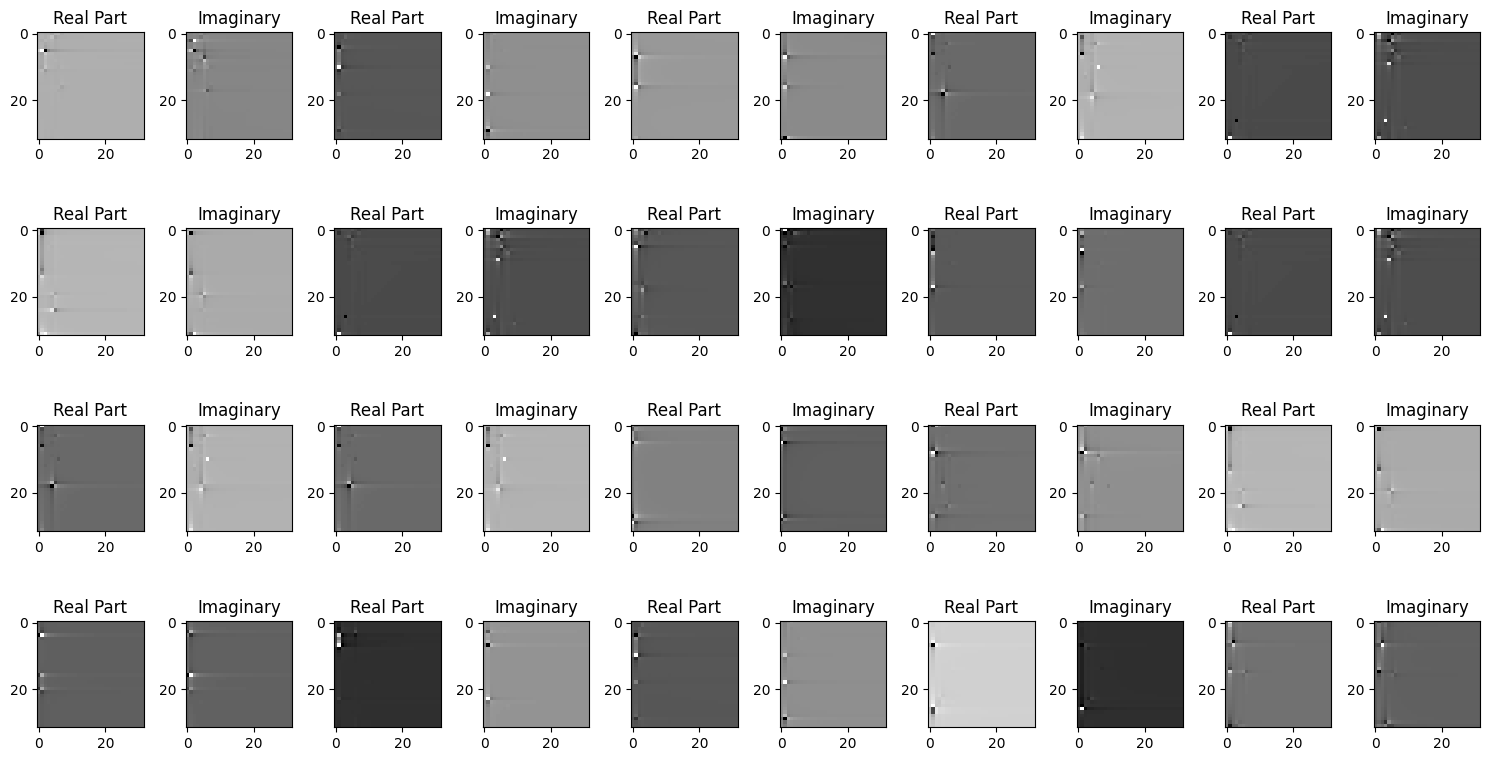

In [11]:
fig, axs = plt.subplots(4, 10, figsize=(15,8))
img_batch=x_train[200:220,:,:,:]

for i in range(0,10,2):
  for j in range(0,4):
    CSI_img = random.choice(img_batch)
    axs[j,i].imshow(np.array(CSI_img[0,:,:]), cmap='gist_gray')
    axs[j,i+1].imshow(np.array(CSI_img[1,:,:]), cmap='gist_gray')
    axs[j,i].set_title('Real Part')
    axs[j,i+1].set_title('Imaginary')
plt.tight_layout()

In [12]:
x_train = torch.tensor(x_train)
x_val = torch.tensor(x_val)
x_test = torch.tensor(x_test)
X_test = torch.tensor(X_test)

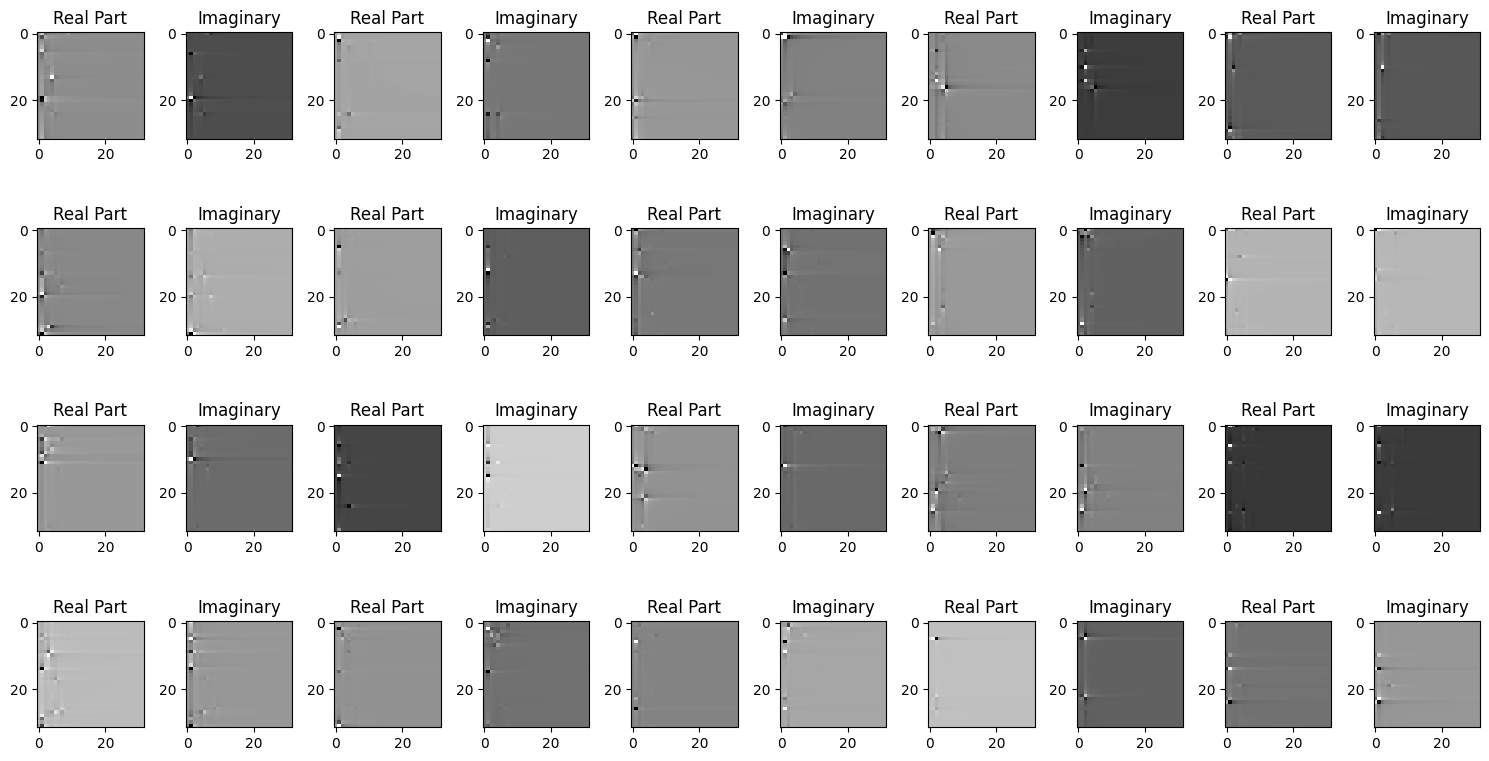

In [13]:
fig, axs = plt.subplots(4, 10, figsize=(15,8))
for i in range(0,10,2):
  for j in range(0,4):
    CSI_img = random.choice(x_train)
    axs[j,i].imshow(np.array(CSI_img[0,:,:]), cmap='gist_gray')
    axs[j,i+1].imshow(np.array(CSI_img[1,:,:]), cmap='gist_gray')
    axs[j,i].set_title('Real Part')
    axs[j,i+1].set_title('Imaginary')
plt.tight_layout()

In [14]:
# device
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)
x_train = x_train.to(device)
x_val = x_val.to(device)
x_test = x_test.to(device)
noise=torch.randn((1,512)).to(device)


cuda


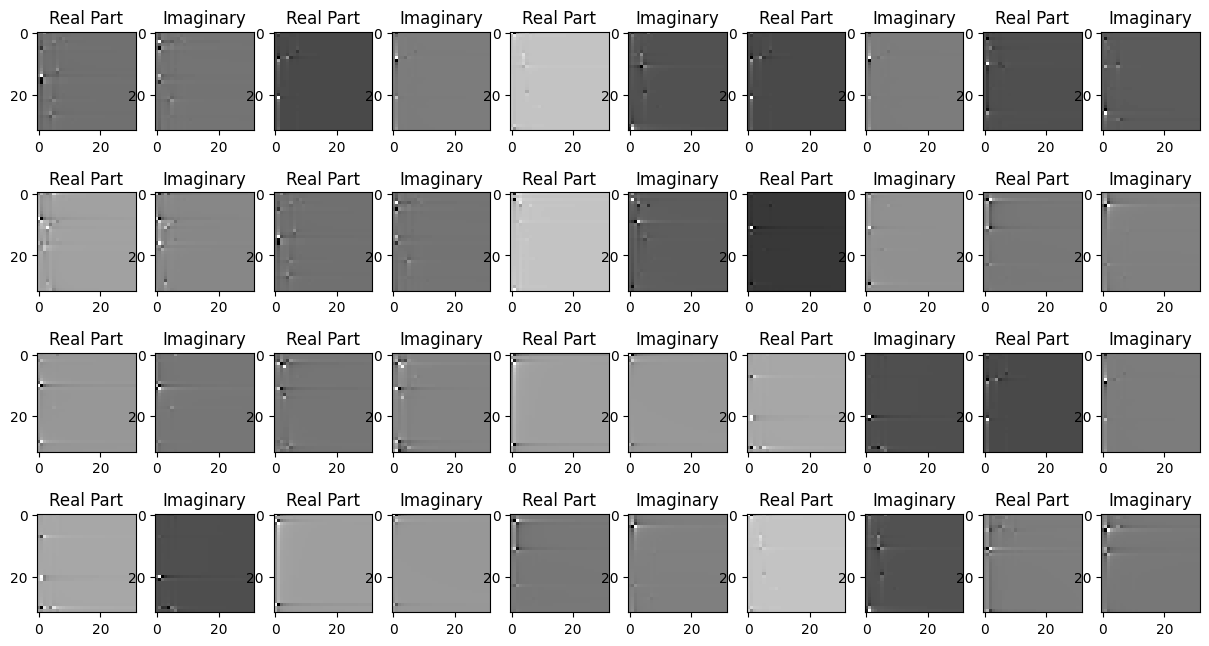

In [15]:
x_val_batch=x_val[0:20,:,:,:]
fig, axs = plt.subplots(4, 10, figsize=(15,8))
for i in range(0,10,2):
  for j in range(0,4):
    CSI_img = random.choice(x_val_batch.cpu())
    #print(CSI_img.shape)
    axs[j,i].imshow(np.array(CSI_img[0,:,:]), cmap='gist_gray')
    axs[j,i+1].imshow(np.array(CSI_img[1,:,:]), cmap='gist_gray')
    axs[j,i].set_title('Real Part')
    axs[j,i+1].set_title('Imaginary')
plt.show()

In [16]:
# model
model = acrnet(reduction=4, expansion=10).to(device)
#print(model)

I 07.20/11:56 <ipython-input-6-c7e33da91a25>:142 ] => Model ACRNet with reduction=4


torch.Size([5, 2, 32, 32])


<ipython-input-6-c7e33da91a25>:129: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  out.to_sparse_csr()


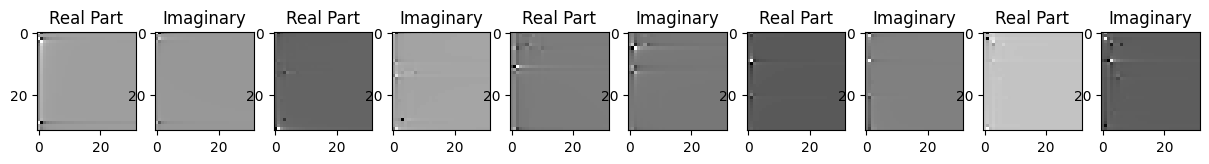

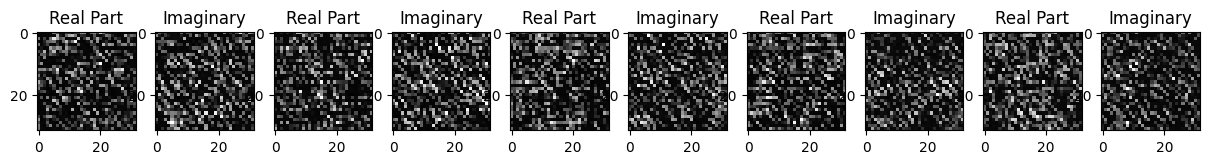

In [17]:
import itertools as it
with torch.no_grad():
  input=x_val[0:5,:,:,:]
  print(input.shape)
  model.eval()
  out = model(input)
  CSI_img_ = out.cpu()

  fig, axs = plt.subplots(1, 10, figsize=(15,8))
  for j, l in it.zip_longest(range(0, 5), range(1, 10,2)):
    in_img=input[j,0,:,:].cpu()
    axs[j*2].imshow(np.array(in_img.squeeze(0)), cmap='gist_gray')
    axs[j*2].set_title('Real Part')
    in_img=input[j,1,:,:].cpu()
    axs[l].imshow(np.array(in_img.squeeze(0)), cmap='gist_gray')
    axs[l].set_title('Imaginary')

  fig, axs = plt.subplots(1, 10, figsize=(15,8))
  for i, x in it.zip_longest(range(0, 5), range(1, 10,2)):

    #print(i)
    #CSI_img = random.choice(CSI_img_.cpu())
    img=CSI_img_[i,0,:,:]
    axs[i*2].imshow(np.array(img.squeeze(0)), cmap='gist_gray')
    axs[i*2].set_title('Real Part')
    img=CSI_img_[i,1,:,:]
    axs[x].imshow(np.array(img.squeeze(0)), cmap='gist_gray')
    axs[x].set_title('Imaginary')





  plt.show()

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-07)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

In [19]:
# loss function
criterion = nn.MSELoss()

n_epochs = 1000
batch_size = 200
total_batches = int(x_train_length/batch_size)

tStart = time.time()

train_loss_history = []
val_loss_history = []

In [ ]:
if os.path.exists('/content/drive/MyDrive/_model_1100_new.pth'):
  checkpoint = torch.load('/content/drive/MyDrive/_model_1100_new.pth',map_location=torch.device('cuda'))
  model.load_state_dict(checkpoint)

In [21]:
checkpoint = torch.load("/content/drive/MyDrive/_model_380_indoor_512.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['lr_state_dict'])
start_epoch = checkpoint['epoch']

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!pip install numba

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [22]:
x_val=x_val[0:10000,:,:,:]

In [23]:
x_val_1=x_val = x_val.to(device)

Epoch-1 lr: 0.000729
Loss:  1.1218579629712622e-06
torch.Size([5, 2, 32, 32])


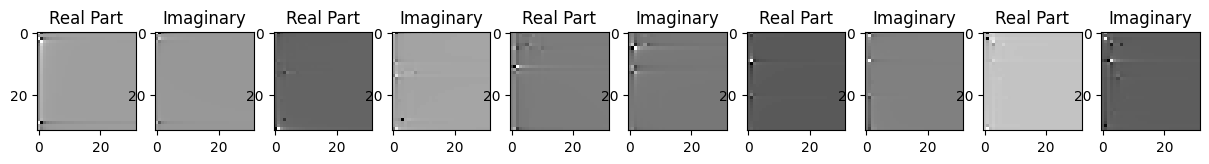

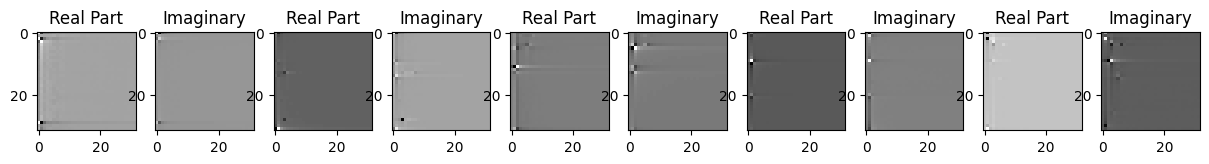

Saving model to: /content/drive/MyDrive/saved_model/_model_0_indoor_512.pth
Epoch-2 lr: 0.000729
Loss:  1.1138554327772e-06
torch.Size([5, 2, 32, 32])


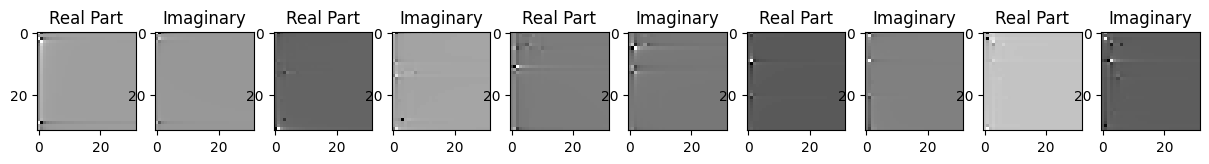

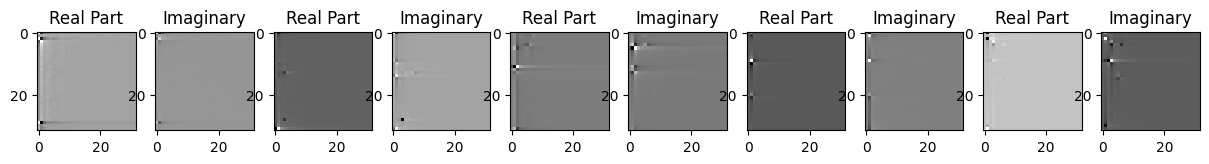

Epoch-3 lr: 0.000729
Loss:  1.1040469871659297e-06
torch.Size([5, 2, 32, 32])


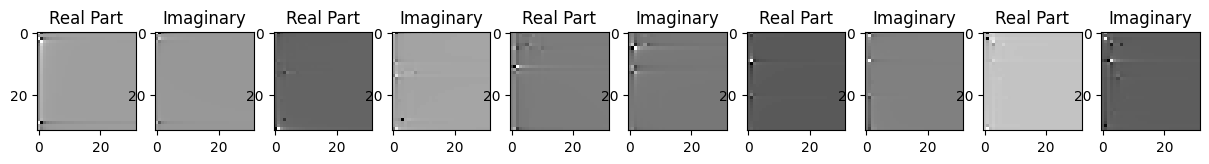

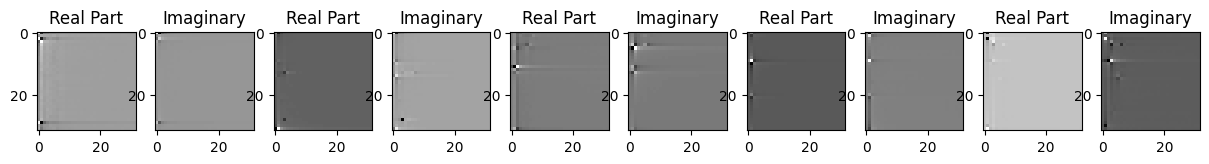

Epoch-4 lr: 0.000729
Loss:  1.0994655212925863e-06
torch.Size([5, 2, 32, 32])


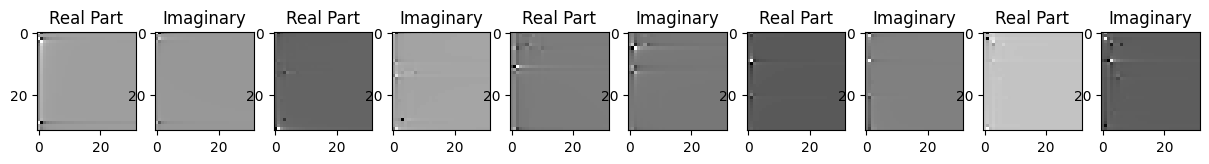

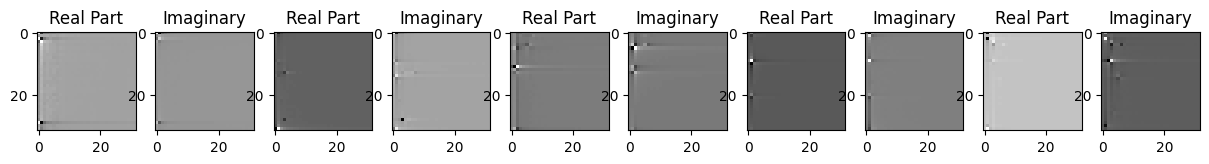

Epoch-5 lr: 0.000729
Loss:  1.0954336175927892e-06
torch.Size([5, 2, 32, 32])


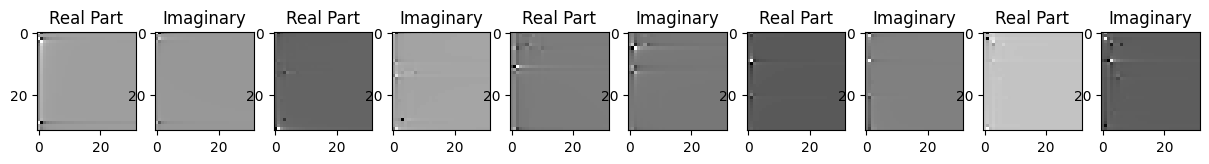

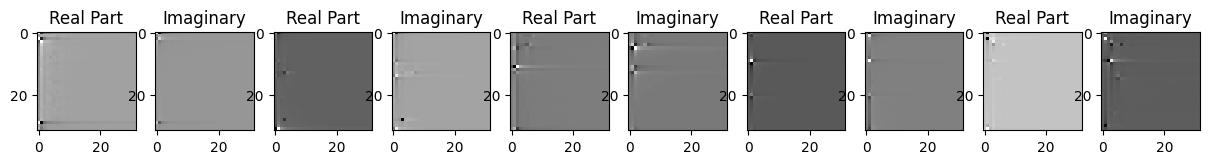

Epoch-6 lr: 0.000729
Loss:  1.0894609658862464e-06
torch.Size([5, 2, 32, 32])


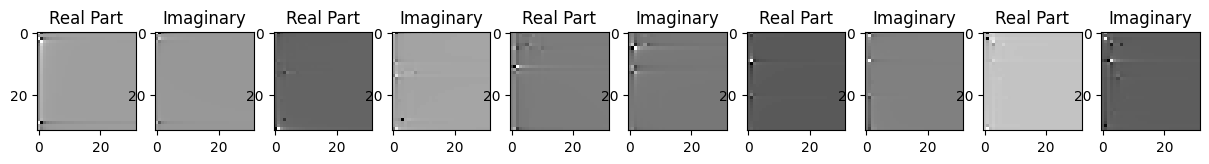

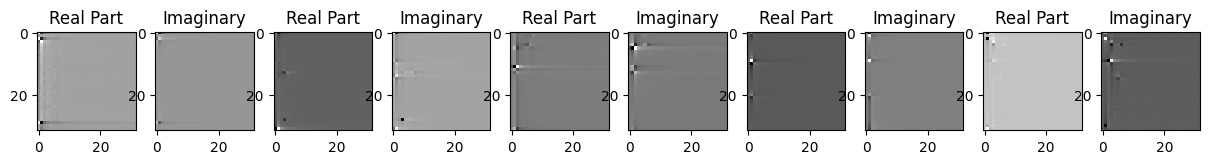

Epoch-7 lr: 0.000729
Loss:  1.087300006474834e-06
torch.Size([5, 2, 32, 32])


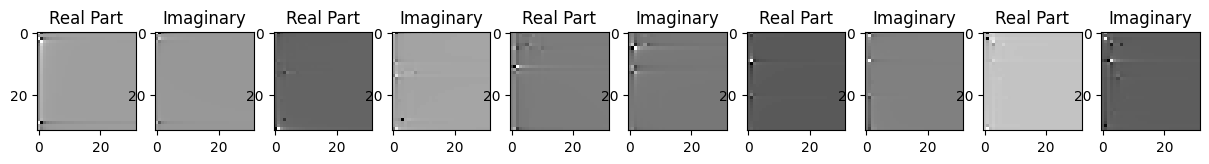

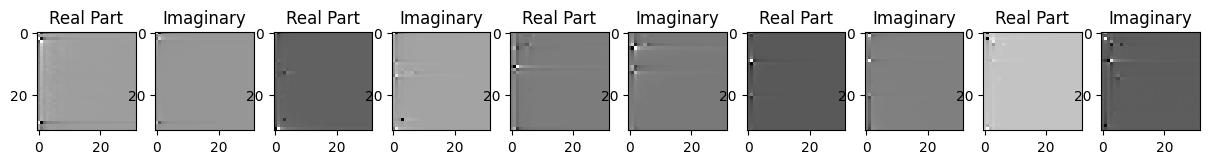

Epoch-8 lr: 0.000729
Loss:  1.0813729431902175e-06
torch.Size([5, 2, 32, 32])


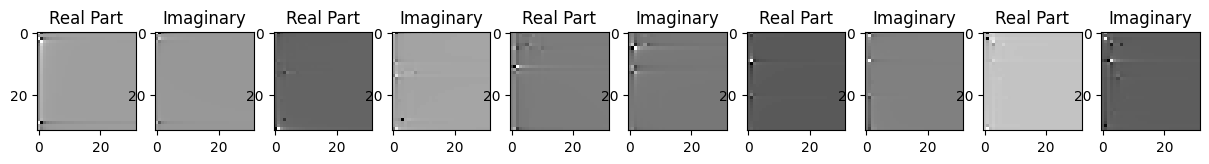

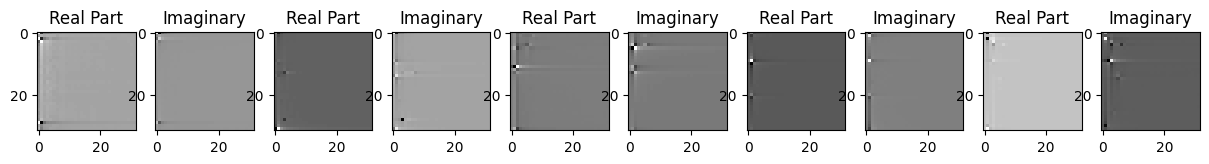

Epoch-9 lr: 0.000729
Loss:  1.0784488040371798e-06
torch.Size([5, 2, 32, 32])


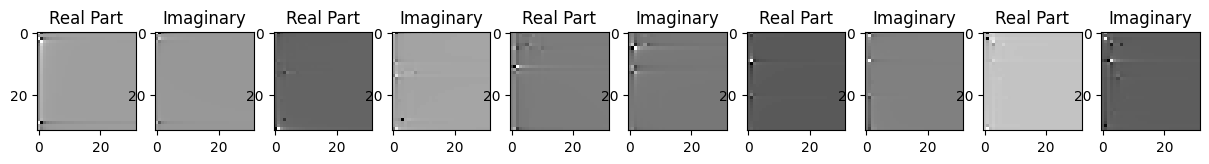

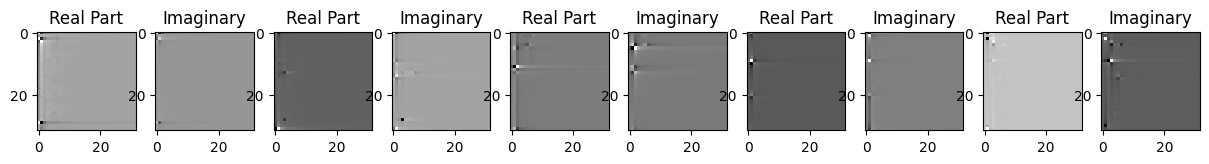

Epoch-10 lr: 0.000729
Loss:  1.0884117500609136e-06
torch.Size([5, 2, 32, 32])


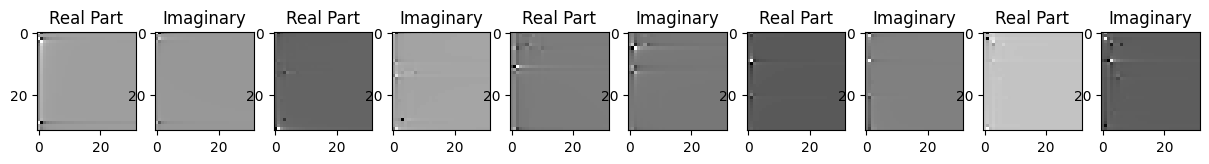

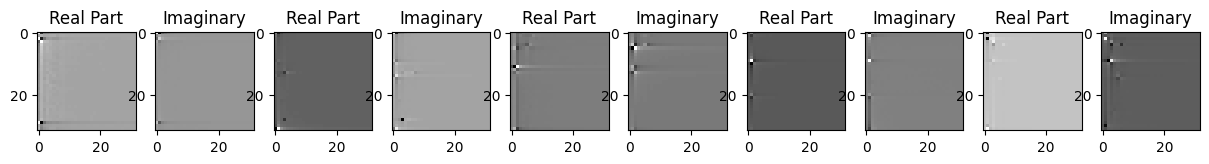

Epoch-11 lr: 0.000729
Loss:  1.0790664646265213e-06
torch.Size([5, 2, 32, 32])


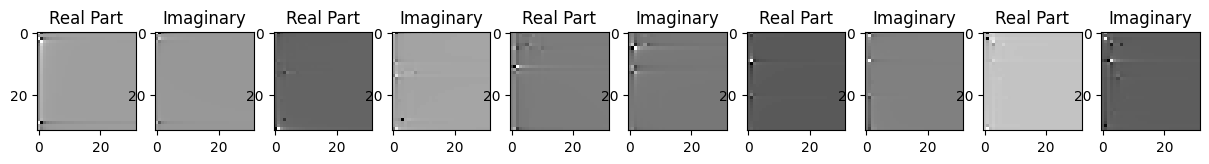

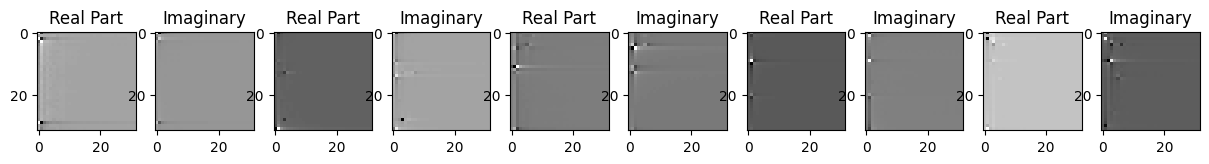

Epoch-12 lr: 0.000729
Loss:  1.0836563433258561e-06
torch.Size([5, 2, 32, 32])


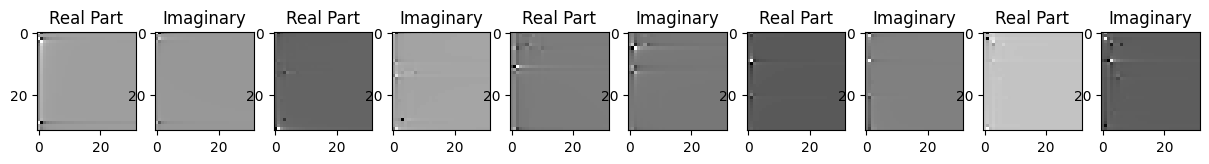

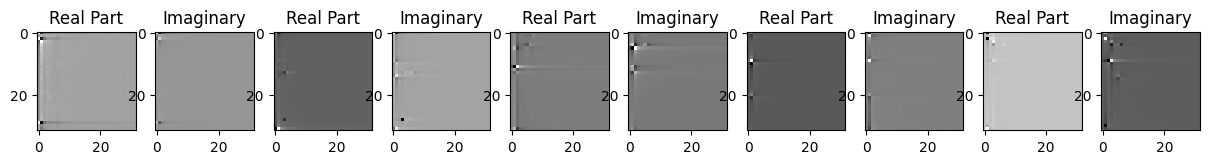

Epoch-13 lr: 0.000729
Loss:  1.0794805120895035e-06
torch.Size([5, 2, 32, 32])


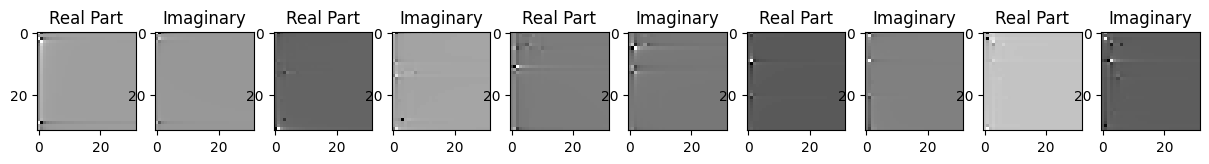

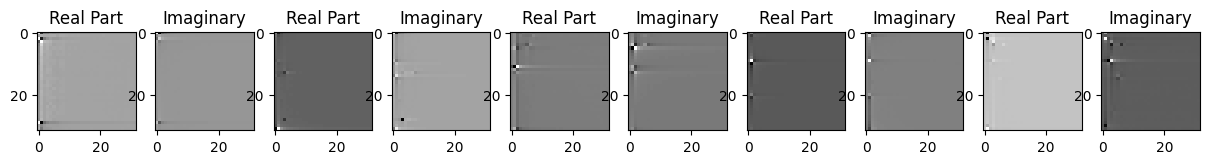

Epoch-14 lr: 0.000729
Loss:  1.0913329333561705e-06
torch.Size([5, 2, 32, 32])


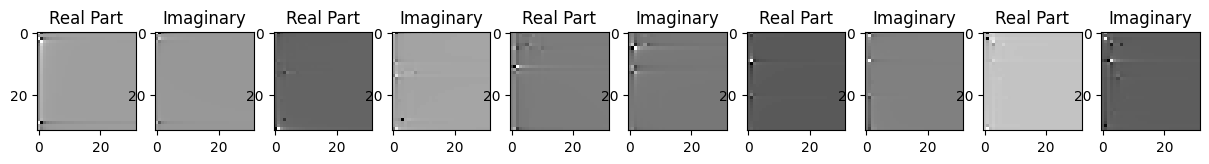

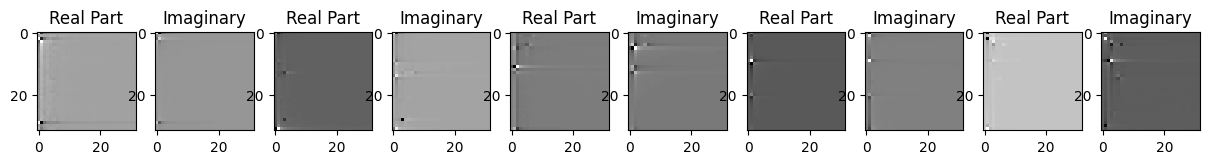

Epoch-15 lr: 0.000729
Loss:  1.1063234524044674e-06
torch.Size([5, 2, 32, 32])


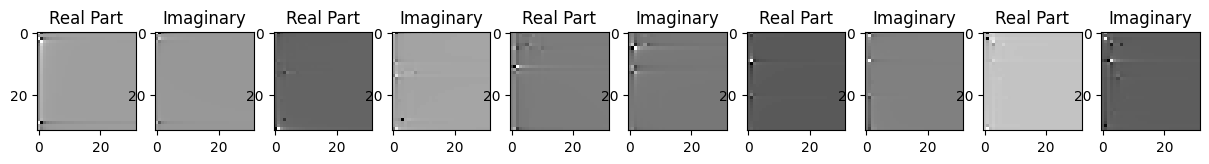

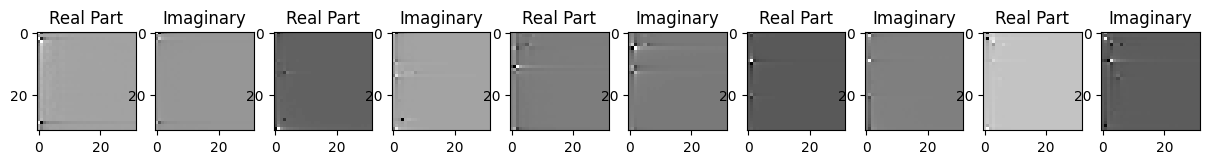

Epoch-16 lr: 0.000729
Loss:  1.142556811828399e-06
torch.Size([5, 2, 32, 32])


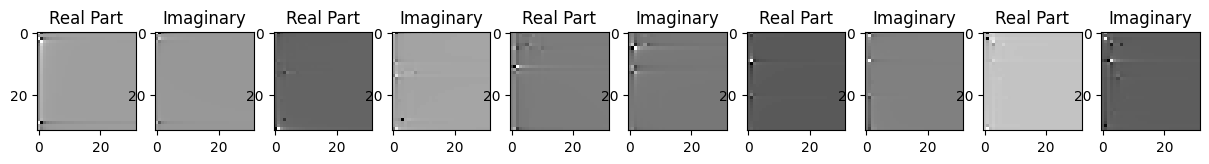

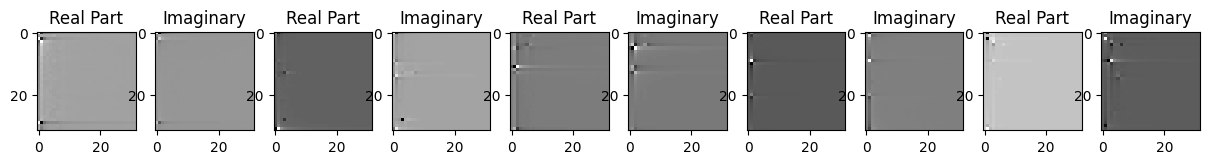

Epoch-17 lr: 0.0006561000000000001
Loss:  1.7301083516940707e-06
torch.Size([5, 2, 32, 32])


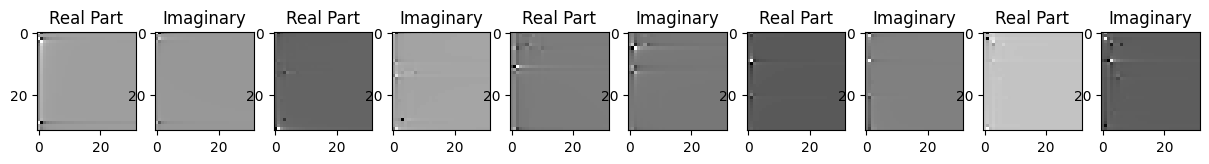

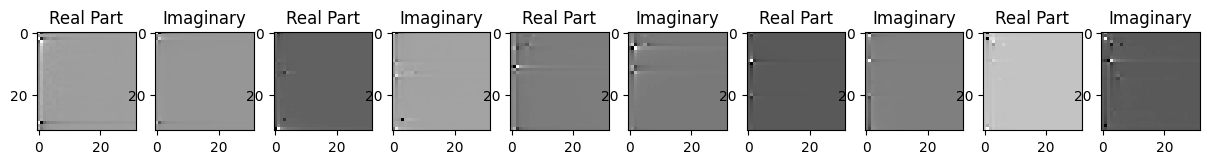

Epoch-18 lr: 0.0006561000000000001
Loss:  1.7041420505847782e-06
torch.Size([5, 2, 32, 32])


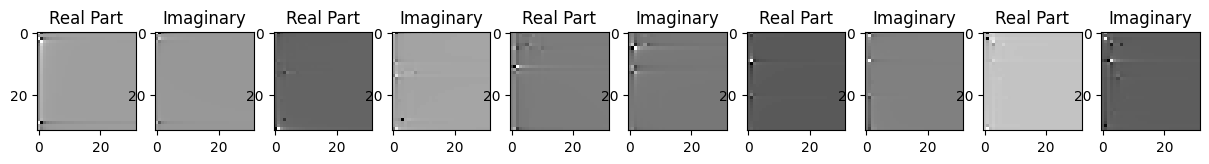

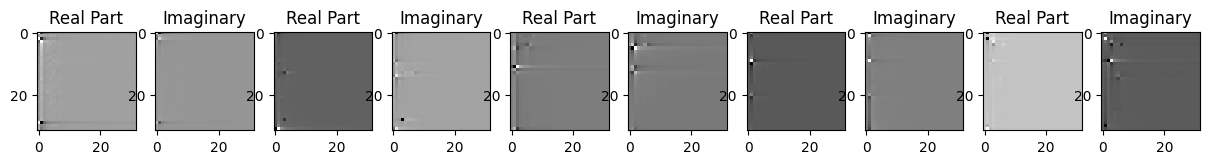

Epoch-19 lr: 0.0006561000000000001
Loss:  1.4333459148474503e-06
torch.Size([5, 2, 32, 32])


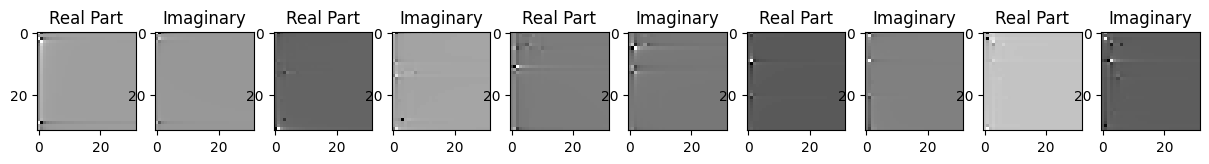

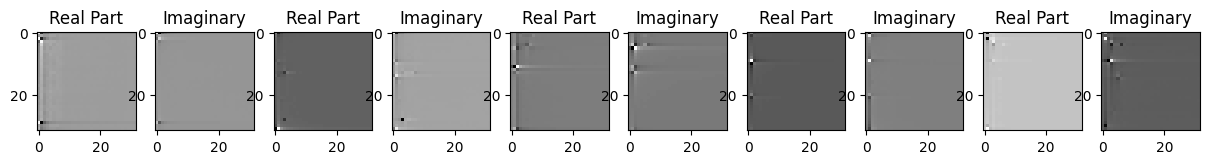

Epoch-20 lr: 0.0006561000000000001
Loss:  1.4020729395269882e-06
torch.Size([5, 2, 32, 32])


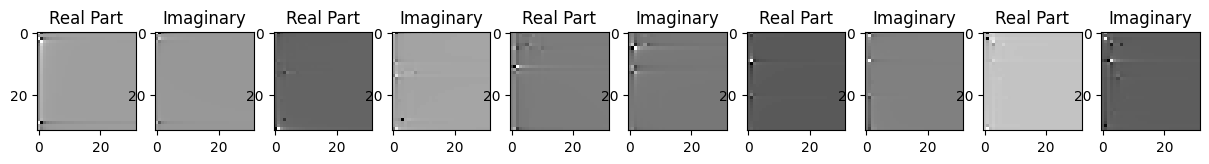

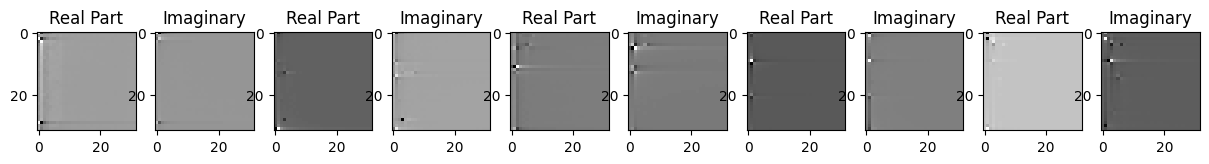

Epoch-21 lr: 0.0006561000000000001
Loss:  1.2915154457004974e-06
torch.Size([5, 2, 32, 32])


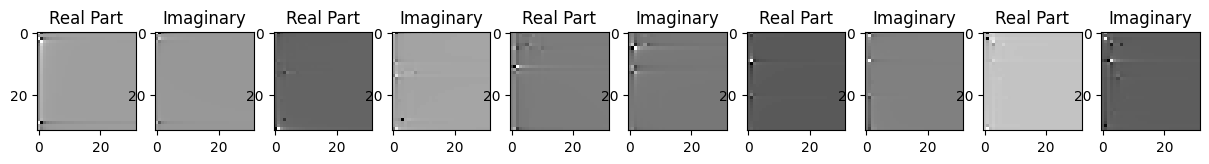

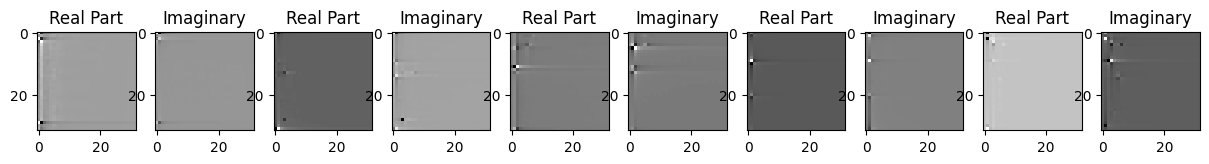

Saving model to: /content/drive/MyDrive/saved_model/_model_20_indoor_512.pth
Epoch-22 lr: 0.0006561000000000001
Loss:  1.4862905572954332e-06
torch.Size([5, 2, 32, 32])


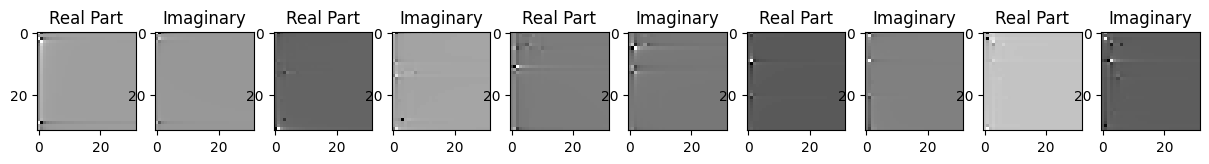

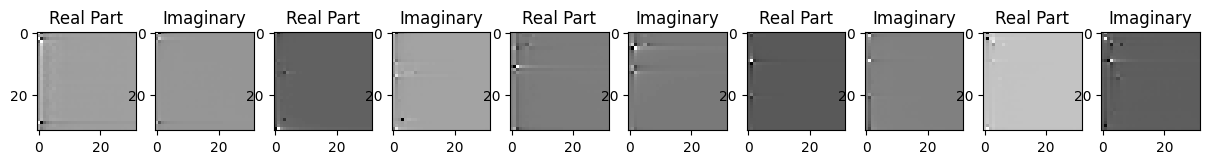

Epoch-23 lr: 0.0006561000000000001
Loss:  1.3894951962356572e-06
torch.Size([5, 2, 32, 32])


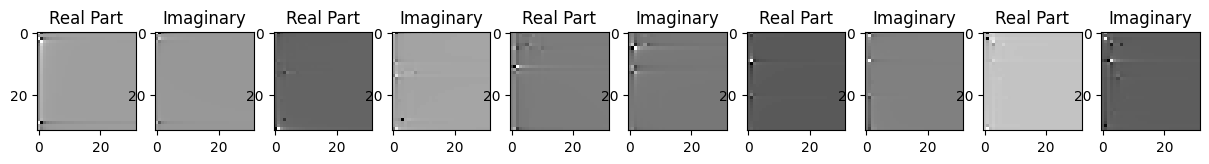

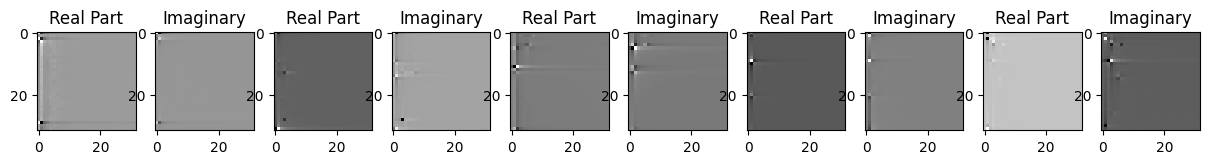

Epoch-24 lr: 0.0006561000000000001
Loss:  1.3533722267311532e-06
torch.Size([5, 2, 32, 32])


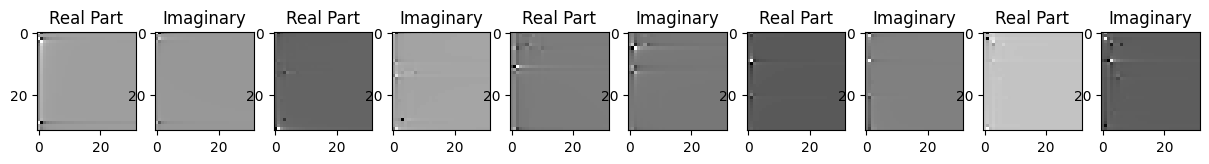

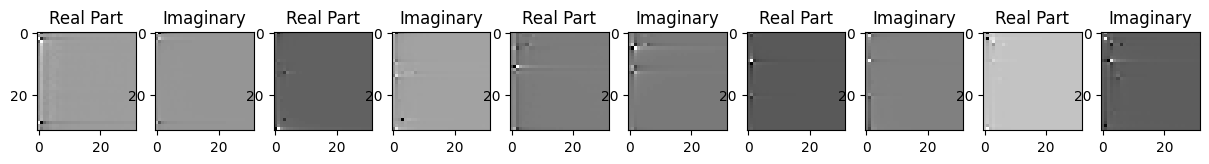

Epoch-25 lr: 0.0006561000000000001
Loss:  1.3217691048339475e-06
torch.Size([5, 2, 32, 32])


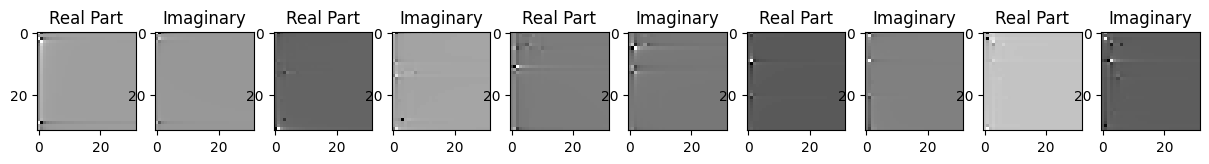

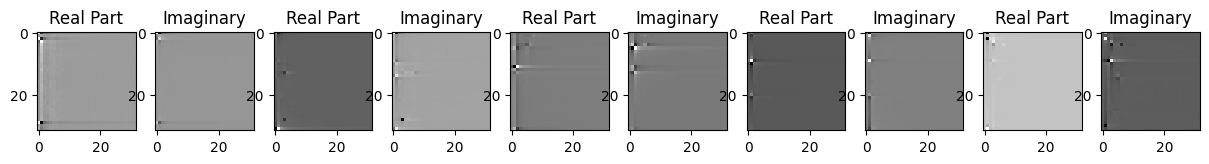

Epoch-26 lr: 0.0006561000000000001
Loss:  1.412531673850026e-06
torch.Size([5, 2, 32, 32])


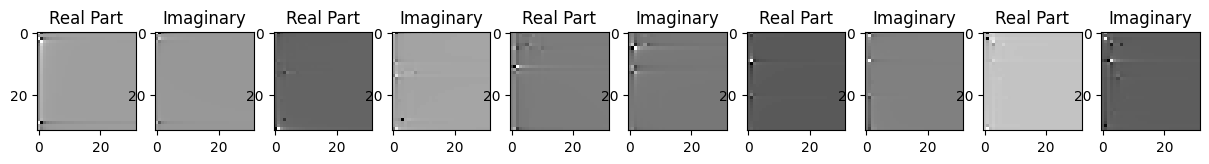

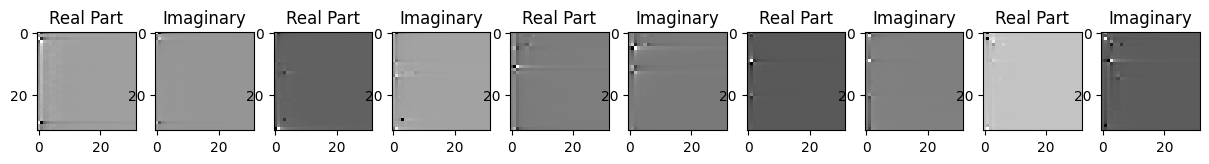

Epoch-27 lr: 0.0006561000000000001
Loss:  1.5568926983178244e-06
torch.Size([5, 2, 32, 32])


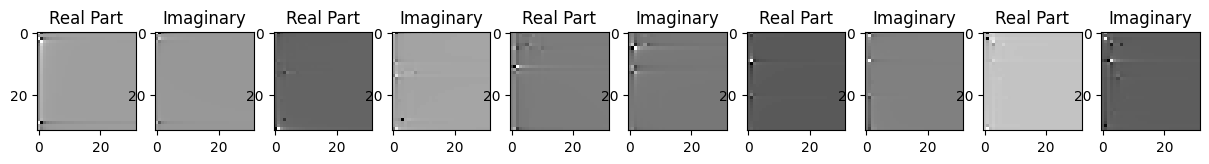

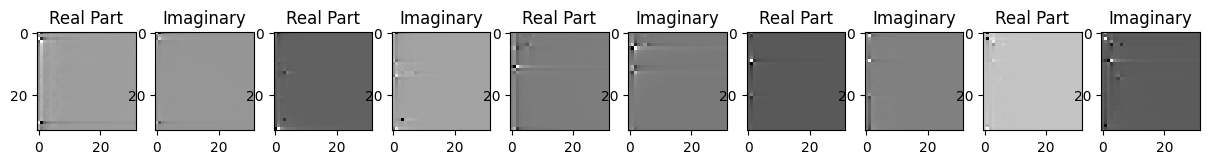

Epoch-28 lr: 0.0006561000000000001
Loss:  1.6424376099166693e-06
torch.Size([5, 2, 32, 32])


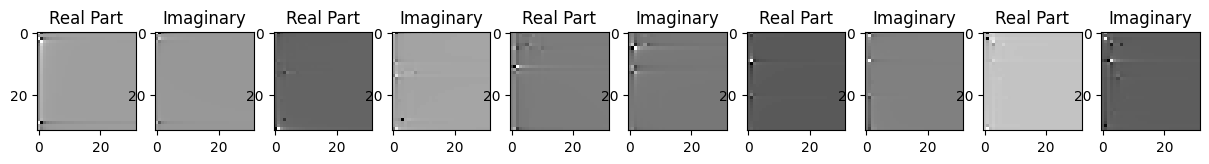

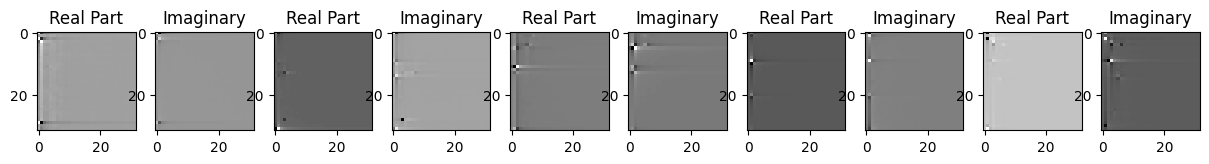

Epoch-29 lr: 0.0006561000000000001
Loss:  1.4171298516885145e-06
torch.Size([5, 2, 32, 32])


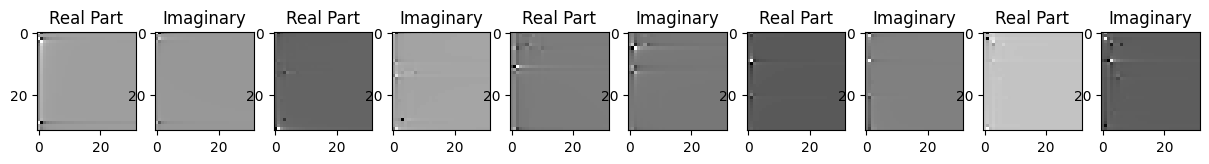

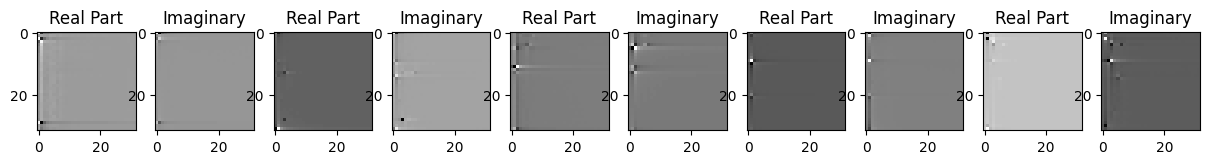

Epoch-30 lr: 0.0006561000000000001
Loss:  1.2729741456496413e-06
torch.Size([5, 2, 32, 32])


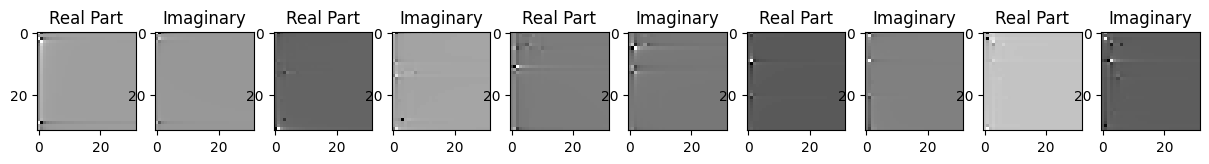

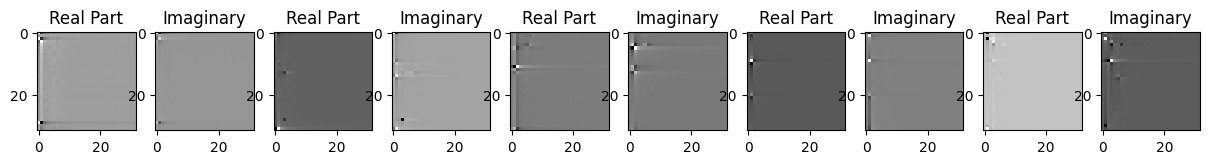

Epoch-31 lr: 0.0006561000000000001
Loss:  1.180924300570041e-06
torch.Size([5, 2, 32, 32])


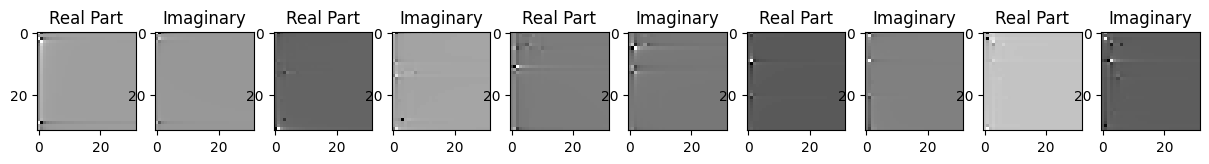

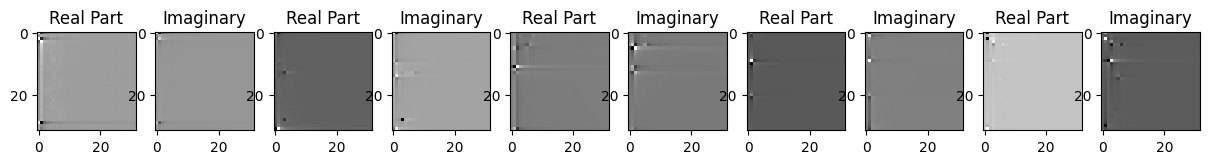

Epoch-32 lr: 0.0006561000000000001
Loss:  1.117079932555498e-06
torch.Size([5, 2, 32, 32])


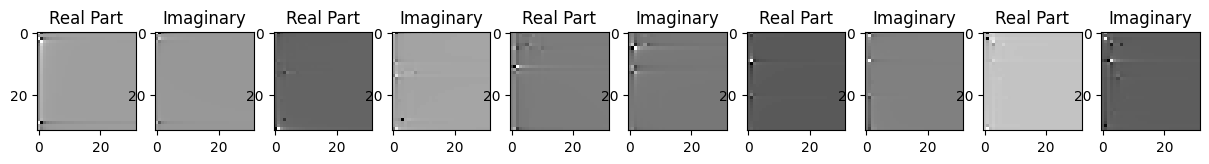

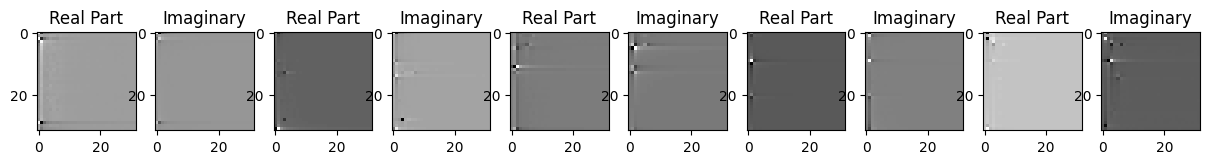

Epoch-33 lr: 0.0006561000000000001
Loss:  1.083365646081802e-06
torch.Size([5, 2, 32, 32])


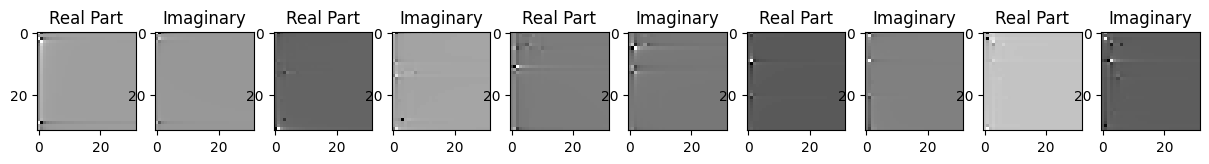

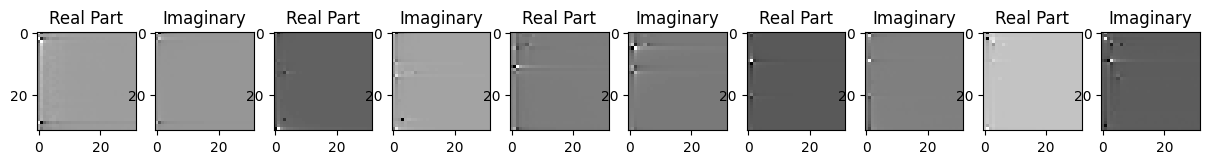

Epoch-34 lr: 0.0006561000000000001
Loss:  1.0849980753846467e-06
torch.Size([5, 2, 32, 32])


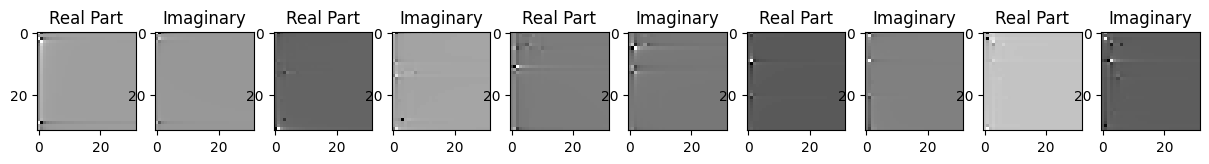

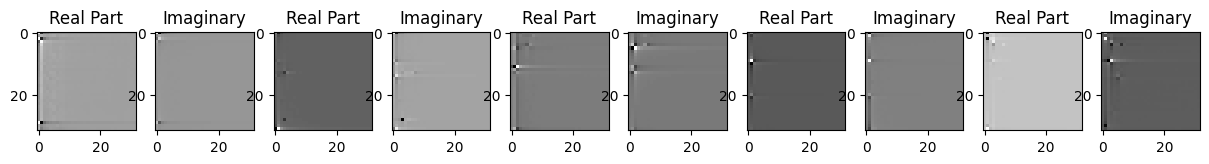

Epoch-35 lr: 0.0006561000000000001
Loss:  1.093045057132258e-06
torch.Size([5, 2, 32, 32])


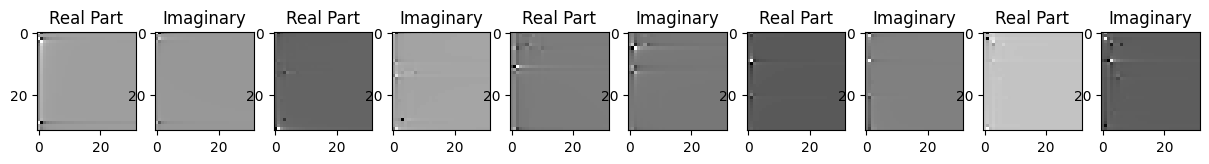

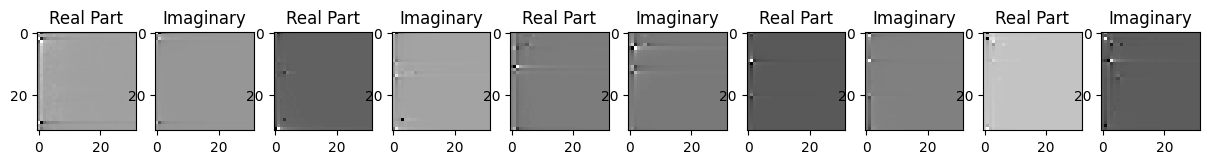

Epoch-36 lr: 0.0006561000000000001
Loss:  1.0890149724218645e-06
torch.Size([5, 2, 32, 32])


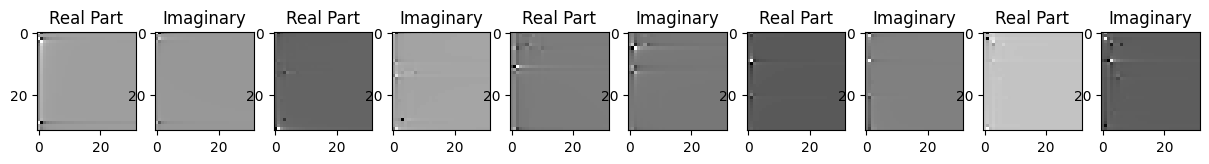

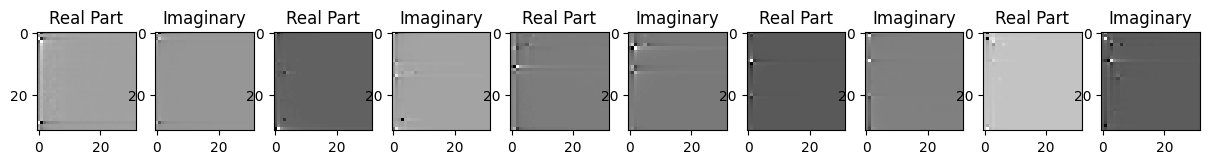

Epoch-37 lr: 0.0006561000000000001
Loss:  1.0862817134693614e-06
torch.Size([5, 2, 32, 32])


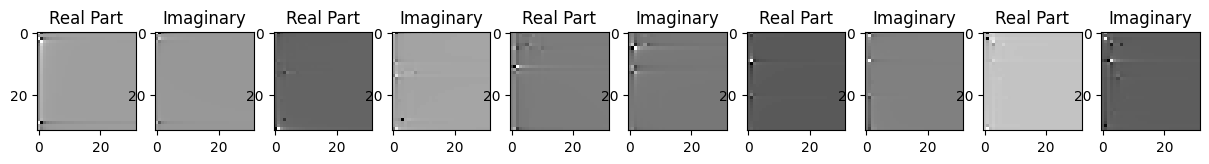

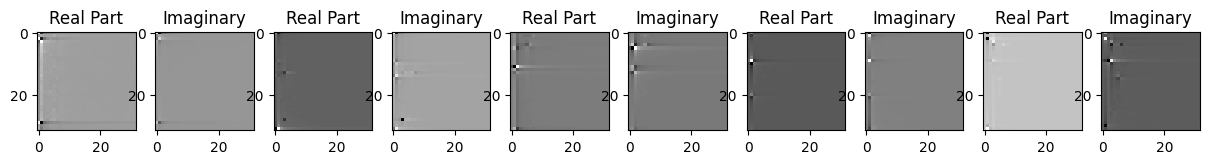

Epoch-38 lr: 0.0006561000000000001
Loss:  1.1031928579541272e-06
torch.Size([5, 2, 32, 32])


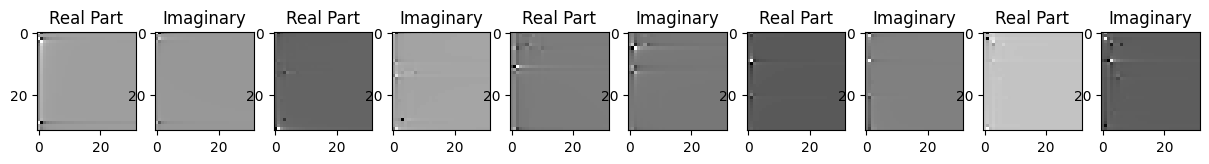

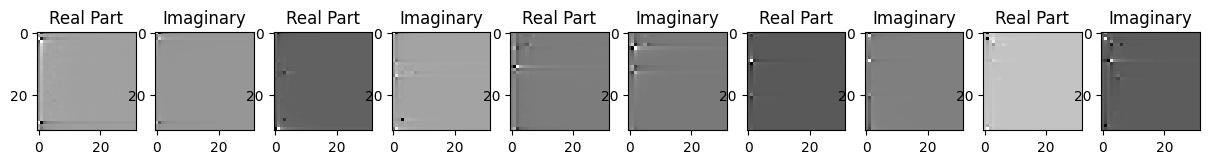

Epoch-39 lr: 0.0006561000000000001
Loss:  1.1183850574525422e-06
torch.Size([5, 2, 32, 32])


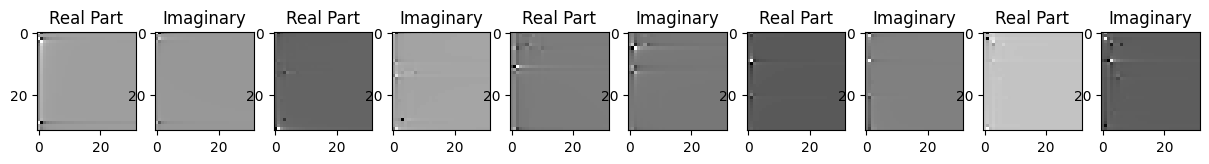

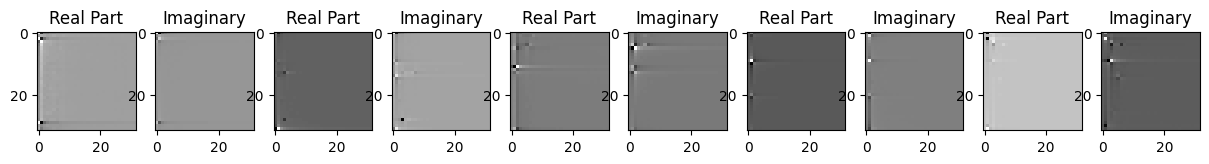

Epoch-40 lr: 0.0006561000000000001
Loss:  1.1090097586929915e-06
torch.Size([5, 2, 32, 32])


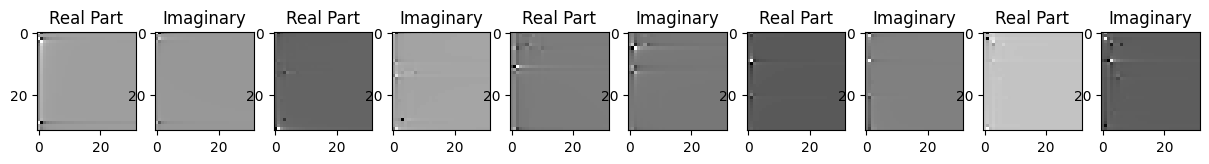

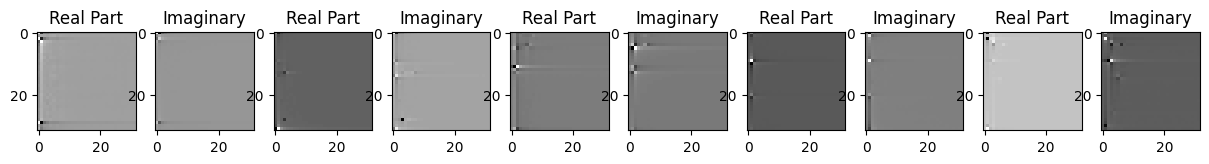

Epoch-41 lr: 0.0006561000000000001
Loss:  1.1169747722306056e-06
torch.Size([5, 2, 32, 32])


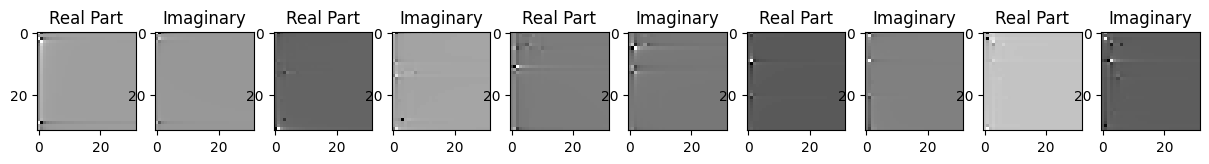

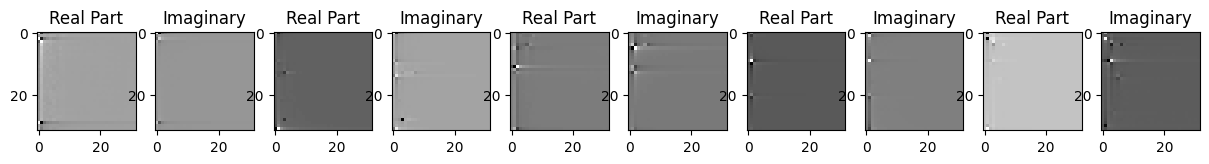

Saving model to: /content/drive/MyDrive/saved_model/_model_40_indoor_512.pth
Epoch-42 lr: 0.0006561000000000001
Loss:  1.1185894663867657e-06
torch.Size([5, 2, 32, 32])


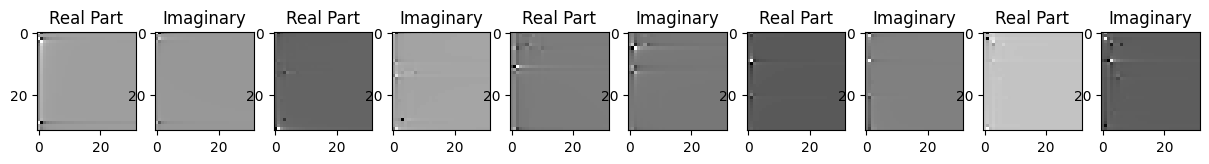

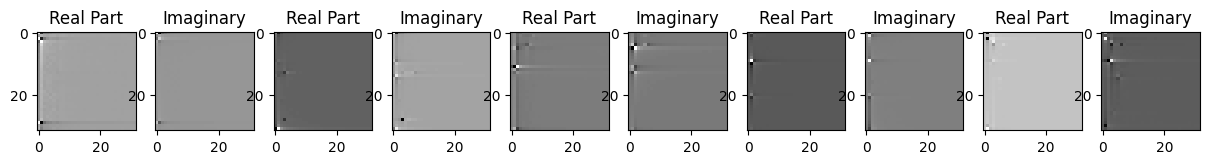

Epoch-43 lr: 0.0006561000000000001
Loss:  1.1063754072893062e-06
torch.Size([5, 2, 32, 32])


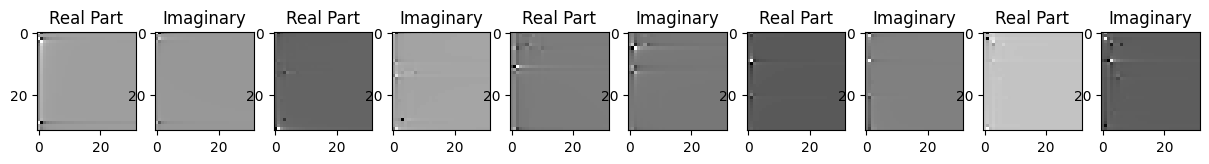

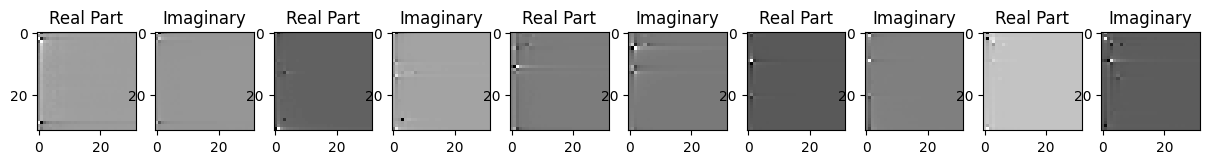

Epoch-44 lr: 0.0006561000000000001
Loss:  1.1053012940465123e-06
torch.Size([5, 2, 32, 32])


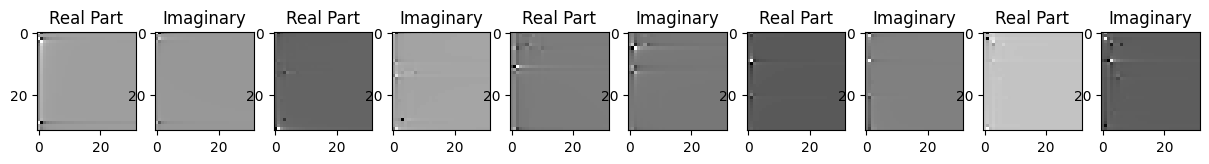

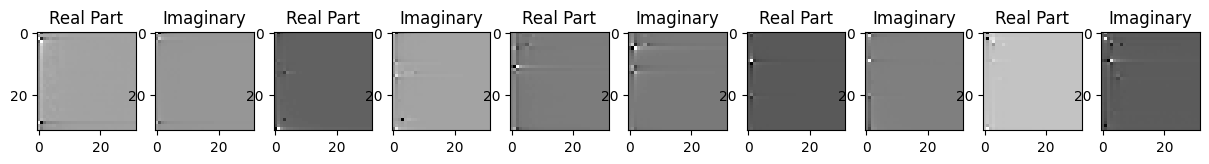

Epoch-45 lr: 0.0006561000000000001
Loss:  1.1023448678315617e-06
torch.Size([5, 2, 32, 32])


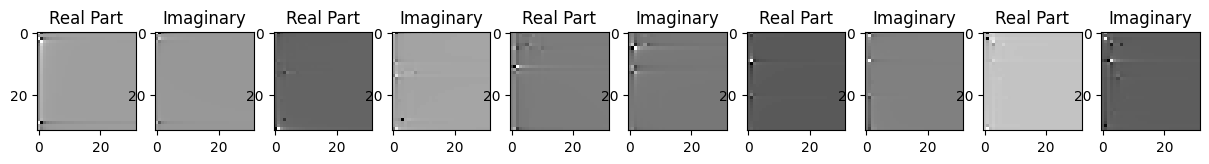

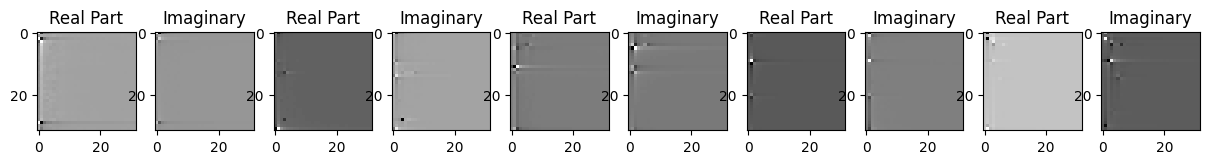

Epoch-46 lr: 0.0006561000000000001
Loss:  1.1024347941201995e-06
torch.Size([5, 2, 32, 32])


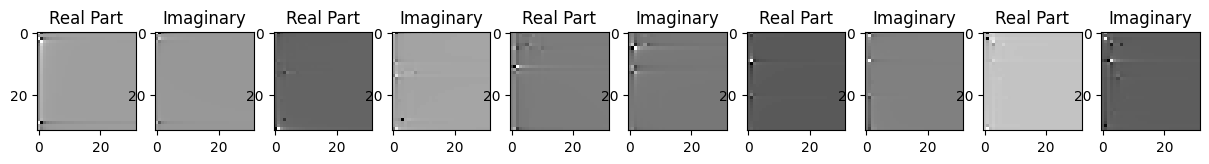

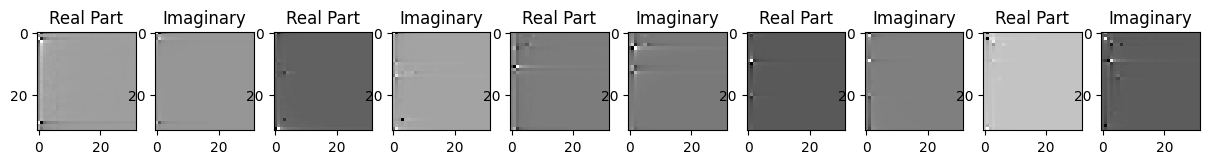

Epoch-47 lr: 0.0006561000000000001
Loss:  1.0818980626936536e-06
torch.Size([5, 2, 32, 32])


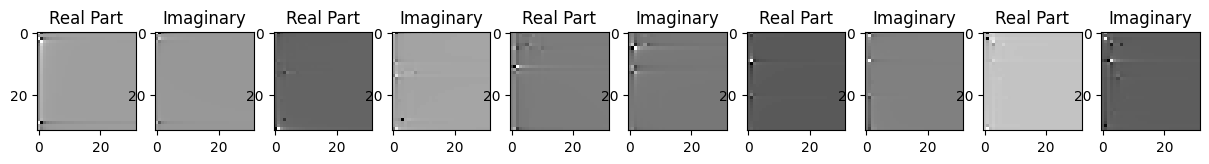

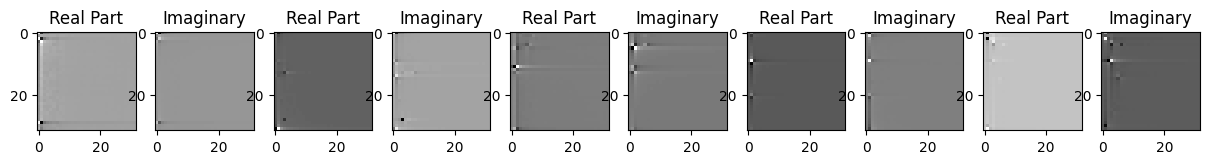

Epoch-48 lr: 0.0006561000000000001
Loss:  1.1099558605565107e-06
torch.Size([5, 2, 32, 32])


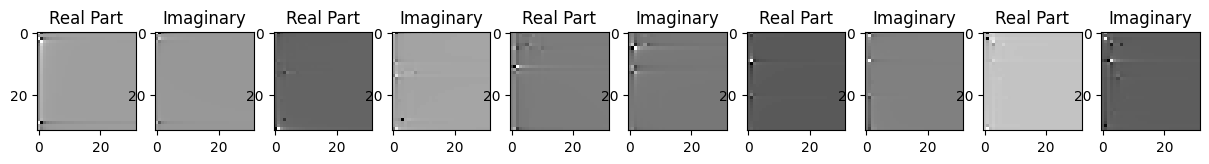

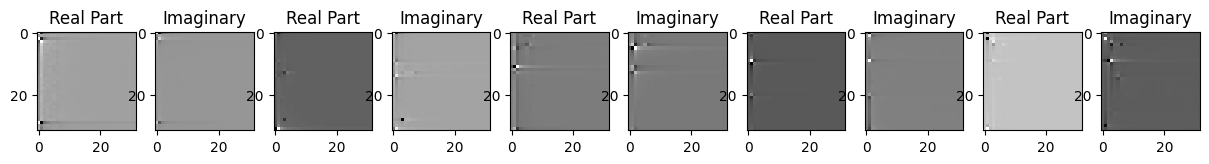

Epoch-49 lr: 0.0006561000000000001
Loss:  1.0796240985655459e-06
torch.Size([5, 2, 32, 32])


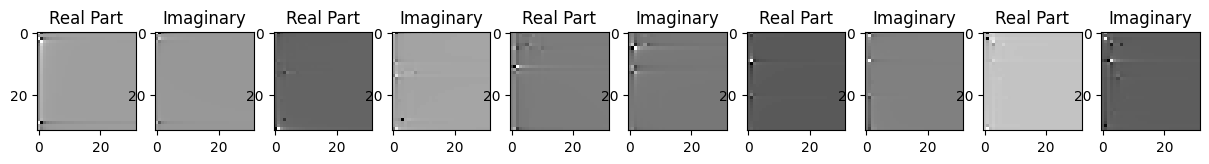

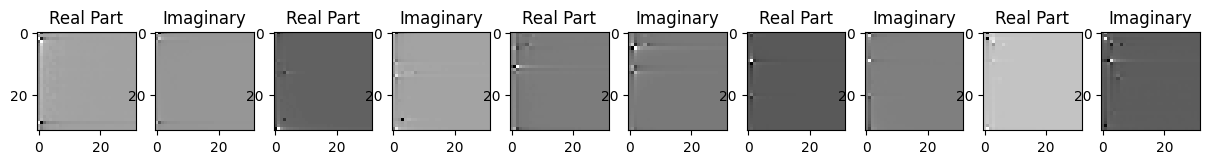

Epoch-50 lr: 0.0006561000000000001
Loss:  1.0949989928121795e-06
torch.Size([5, 2, 32, 32])


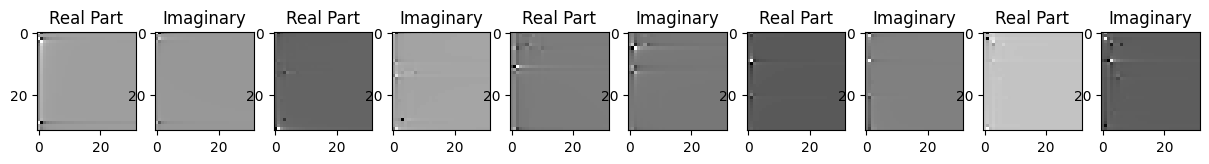

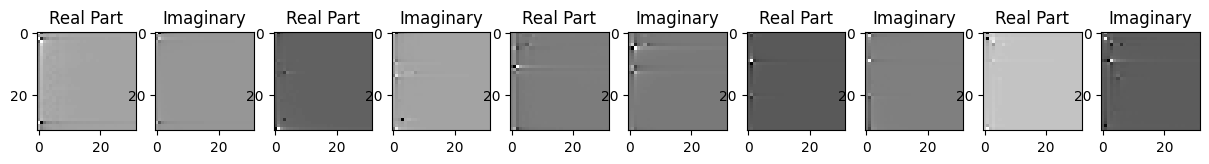

Epoch-51 lr: 0.0006561000000000001
Loss:  1.104468310586526e-06
torch.Size([5, 2, 32, 32])


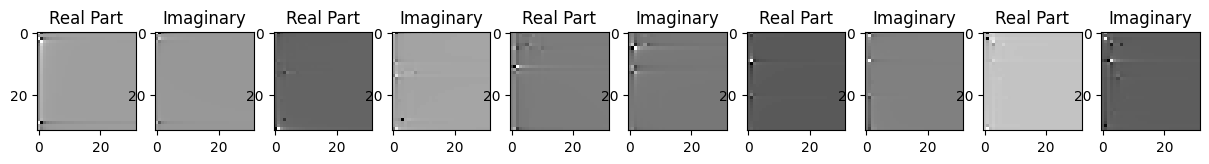

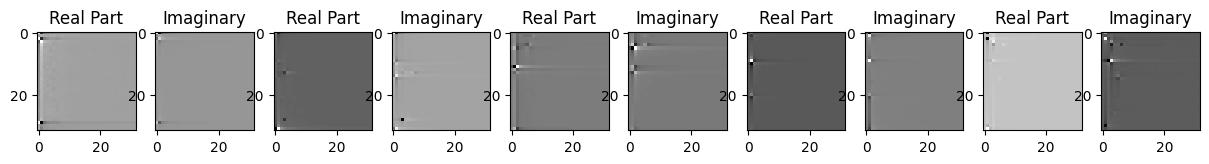

Epoch-52 lr: 0.0006561000000000001
Loss:  1.1271971516180201e-06
torch.Size([5, 2, 32, 32])


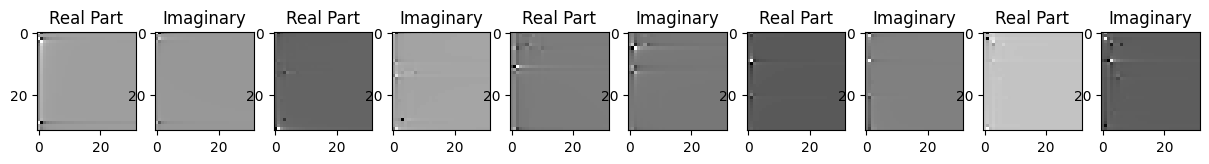

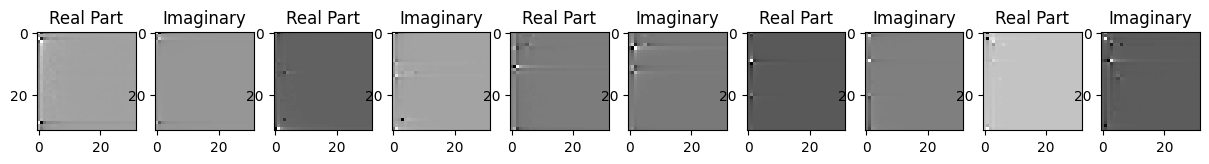

Epoch-53 lr: 0.0006561000000000001
Loss:  1.1435492979217088e-06
torch.Size([5, 2, 32, 32])


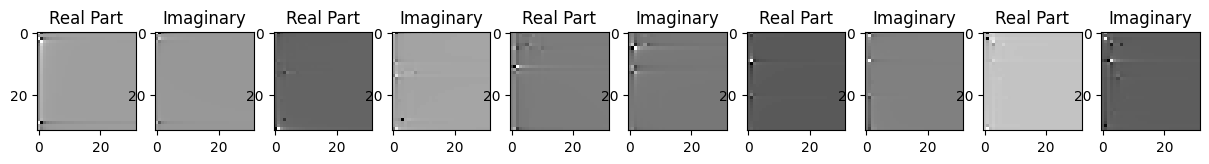

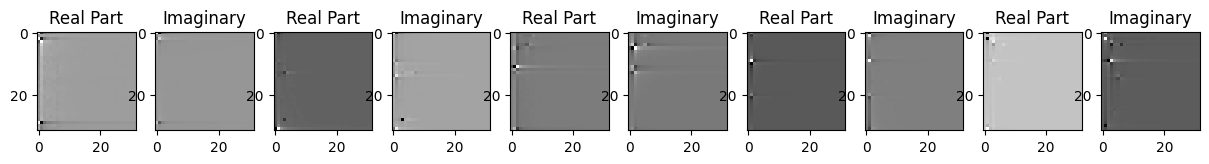

Epoch-54 lr: 0.0006561000000000001
Loss:  1.1492062412798987e-06
torch.Size([5, 2, 32, 32])


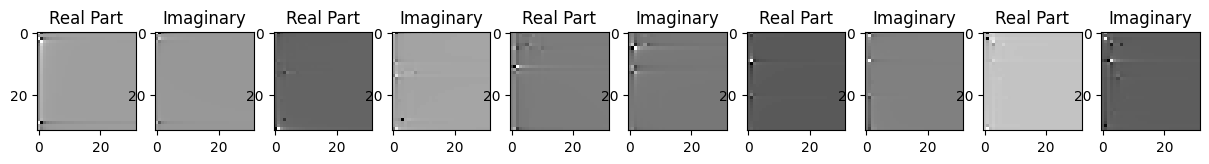

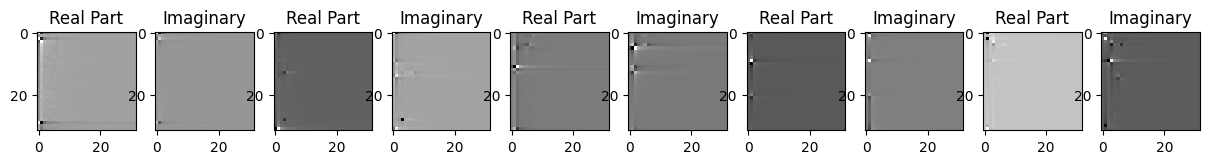

Epoch-55 lr: 0.0006561000000000001
Loss:  1.1644377764241653e-06
torch.Size([5, 2, 32, 32])


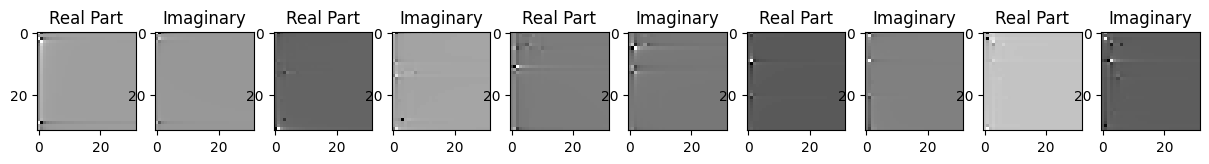

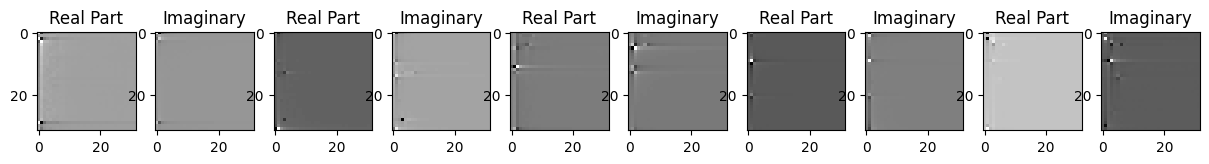

Epoch-56 lr: 0.0006561000000000001
Loss:  1.1332684834997053e-06
torch.Size([5, 2, 32, 32])


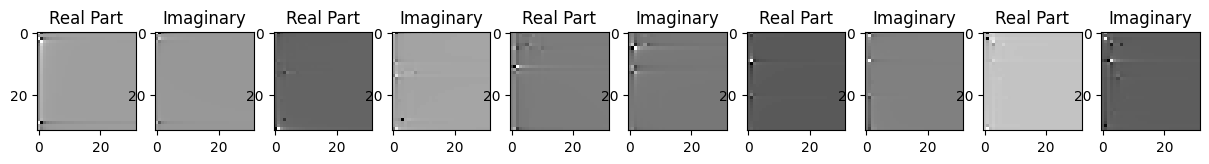

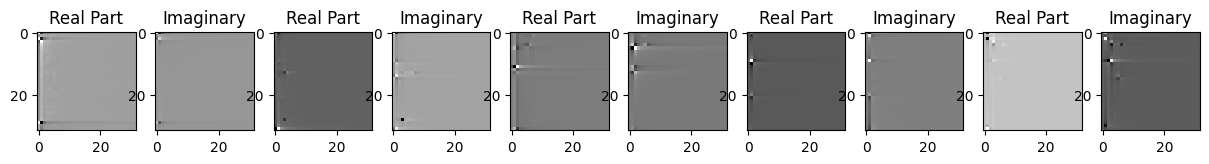

Epoch-57 lr: 0.0006561000000000001
Loss:  1.0964984085148899e-06
torch.Size([5, 2, 32, 32])


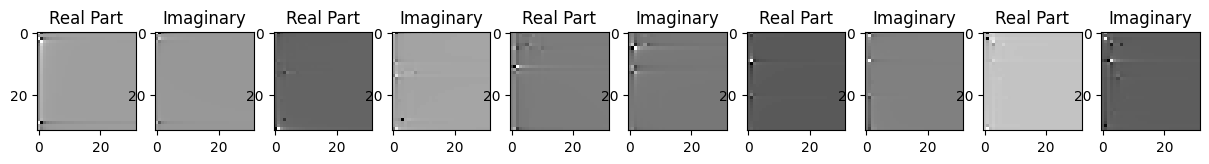

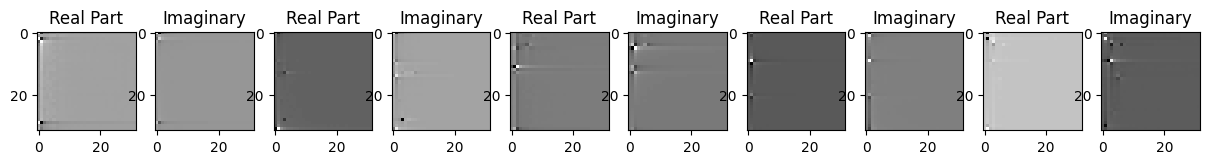

Epoch-58 lr: 0.0006561000000000001
Loss:  1.0881717571464833e-06
torch.Size([5, 2, 32, 32])


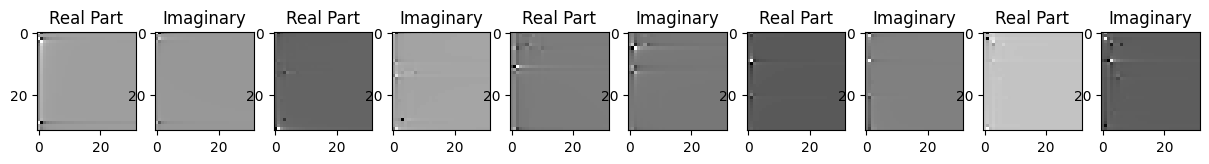

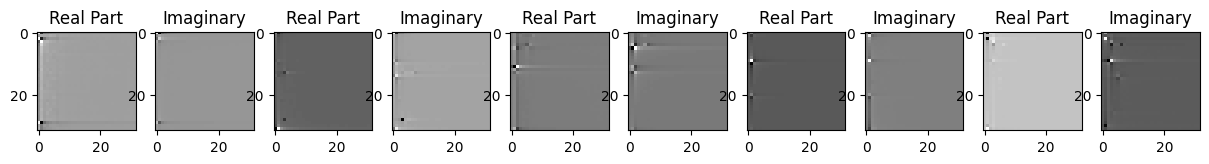

Epoch-59 lr: 0.0006561000000000001
Loss:  1.0807804073920124e-06
torch.Size([5, 2, 32, 32])


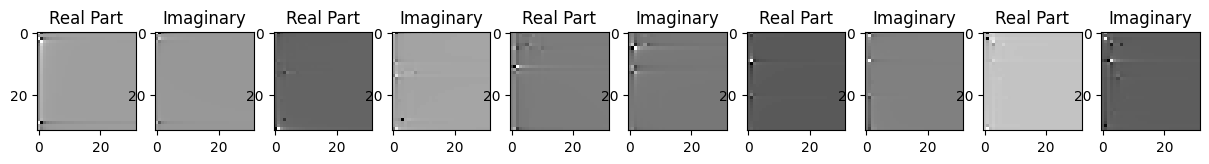

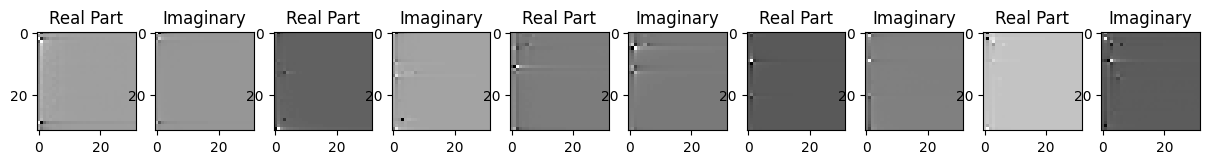

Epoch-60 lr: 0.0006561000000000001
Loss:  1.1166464446432656e-06
torch.Size([5, 2, 32, 32])


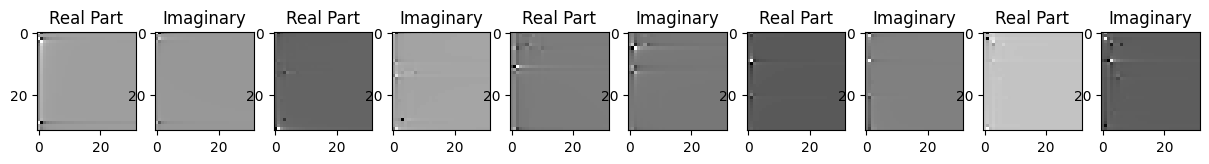

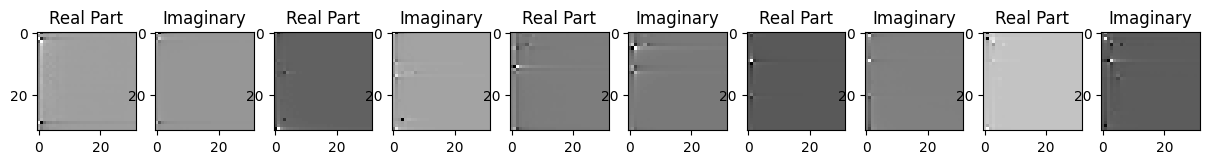

Epoch-61 lr: 0.0006561000000000001
Loss:  1.1456971833467833e-06
torch.Size([5, 2, 32, 32])


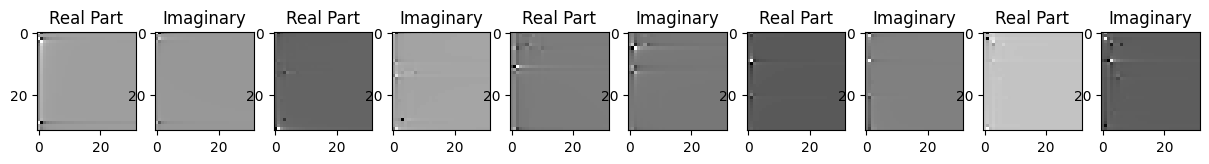

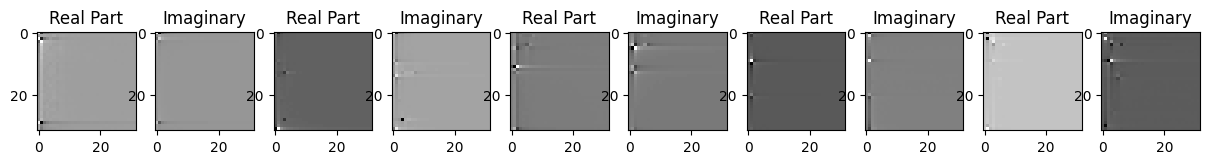

Saving model to: /content/drive/MyDrive/saved_model/_model_60_indoor_512.pth
Epoch-62 lr: 0.0006561000000000001
Loss:  1.1680988336593146e-06
torch.Size([5, 2, 32, 32])


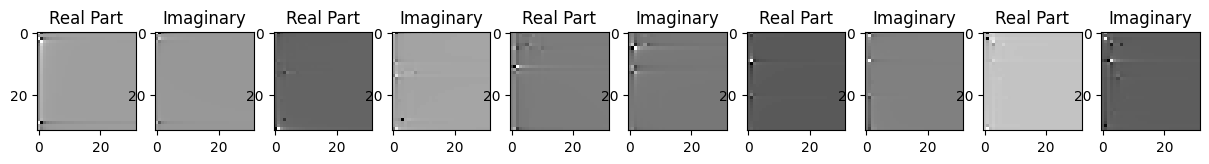

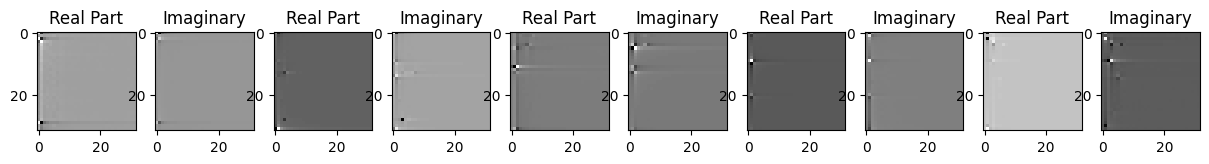

Epoch-63 lr: 0.0006561000000000001
Loss:  1.2170826266810764e-06
torch.Size([5, 2, 32, 32])


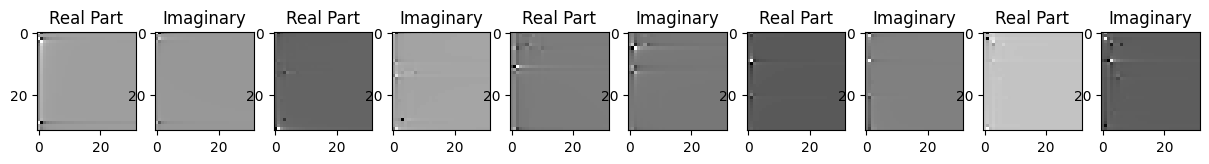

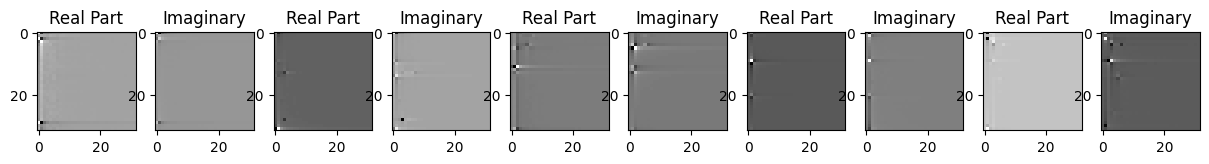

Epoch-64 lr: 0.0006561000000000001
Loss:  1.2041965646858444e-06
torch.Size([5, 2, 32, 32])


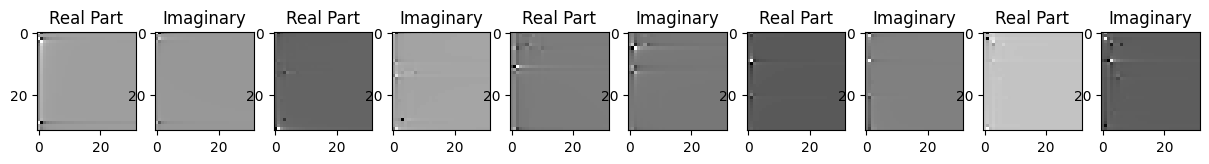

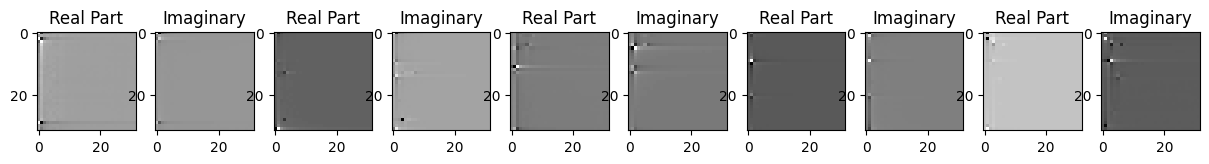

Epoch-65 lr: 0.0006561000000000001
Loss:  1.248045464308234e-06
torch.Size([5, 2, 32, 32])


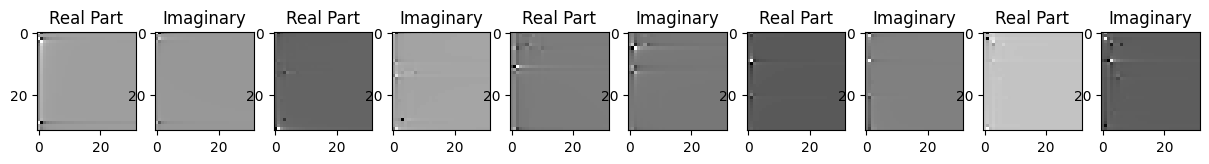

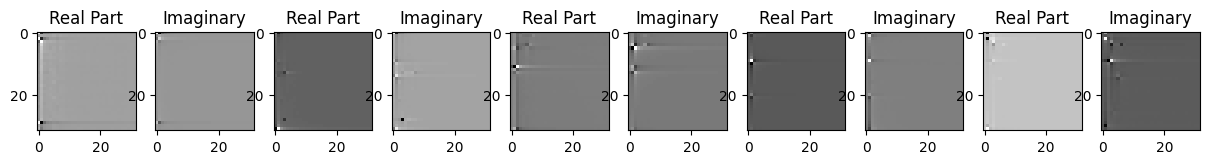

Epoch-66 lr: 0.0006561000000000001
Loss:  1.1905156043212628e-06
torch.Size([5, 2, 32, 32])


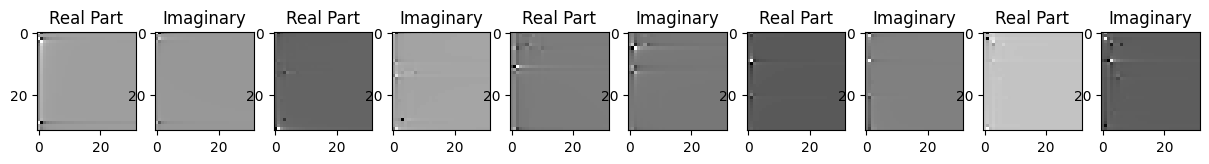

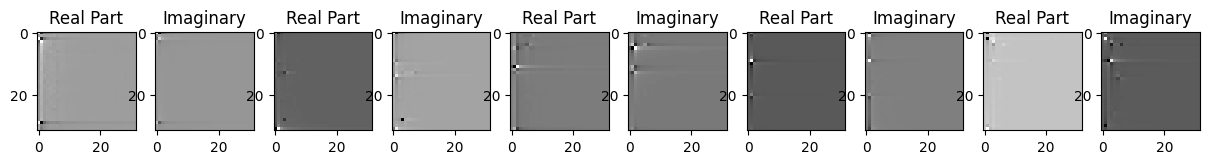

Epoch-67 lr: 0.0006561000000000001
Loss:  1.1990133543804404e-06
torch.Size([5, 2, 32, 32])


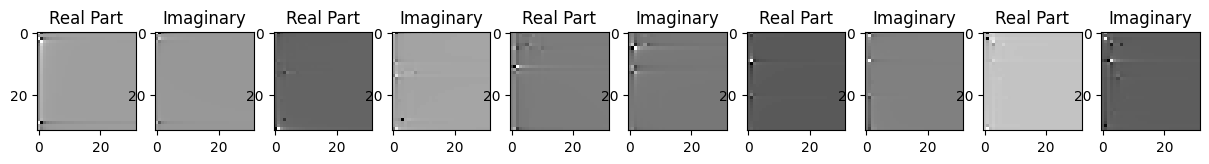

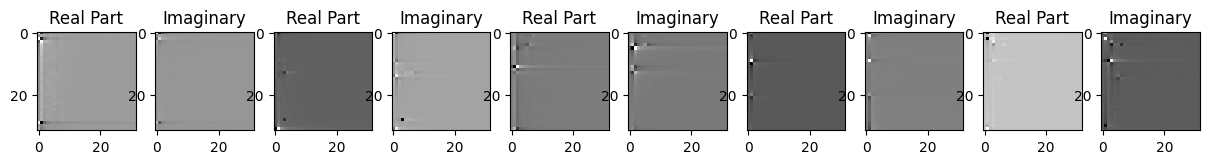

Epoch-68 lr: 0.0006561000000000001
Loss:  1.2024038369418122e-06
torch.Size([5, 2, 32, 32])


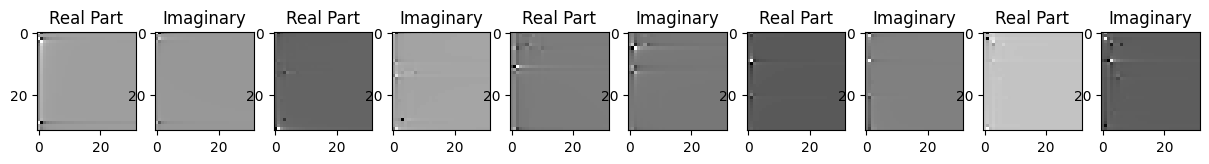

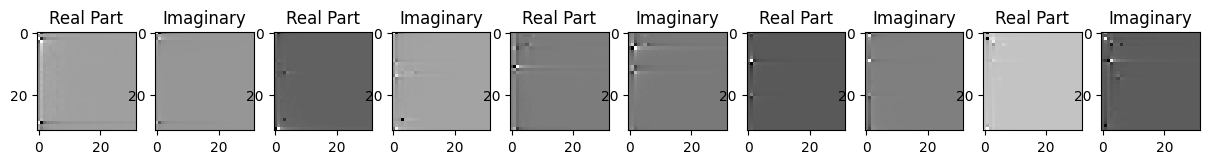

Epoch-69 lr: 0.0006561000000000001
Loss:  1.1833650432890863e-06
torch.Size([5, 2, 32, 32])


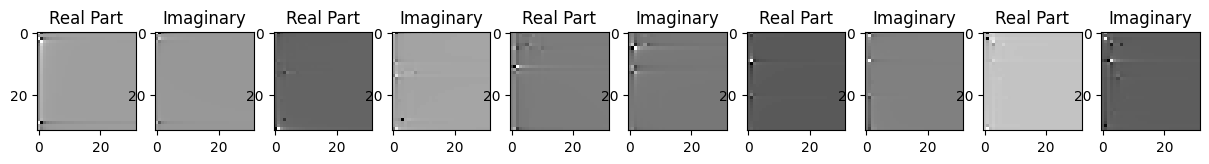

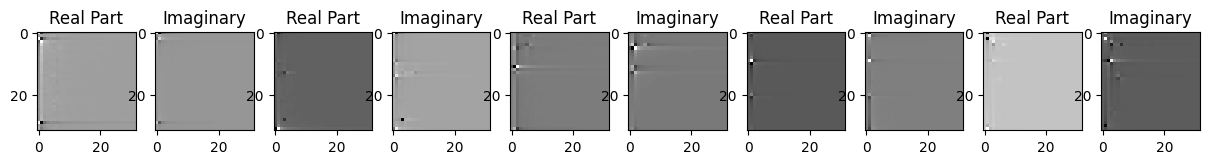

Epoch-70 lr: 0.0006561000000000001
Loss:  1.1683471257128986e-06
torch.Size([5, 2, 32, 32])


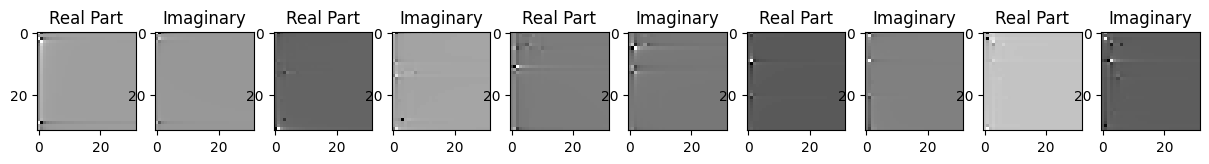

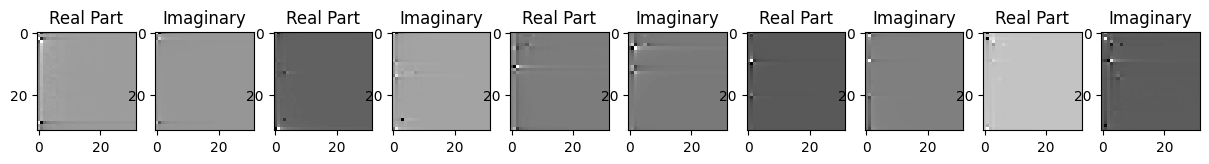

Epoch-71 lr: 0.0006561000000000001
Loss:  1.1758846767406794e-06
torch.Size([5, 2, 32, 32])


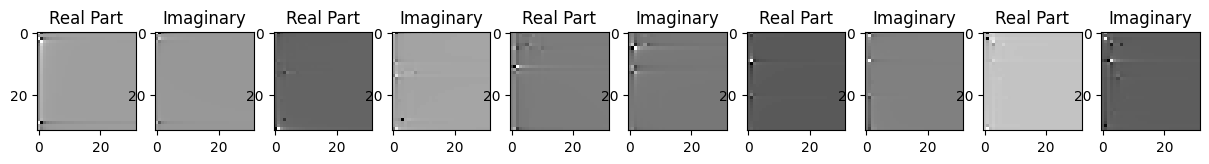

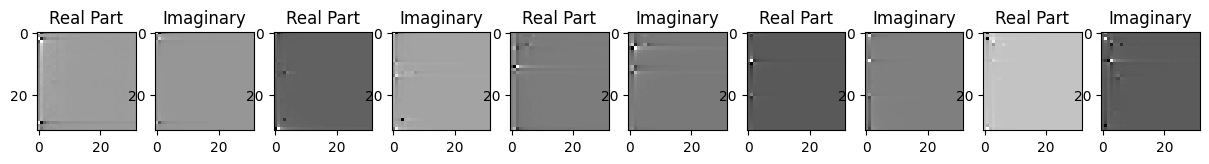

Epoch-72 lr: 0.0006561000000000001
Loss:  1.13861881345656e-06
torch.Size([5, 2, 32, 32])


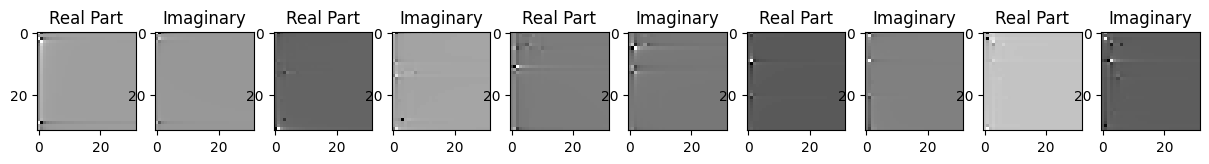

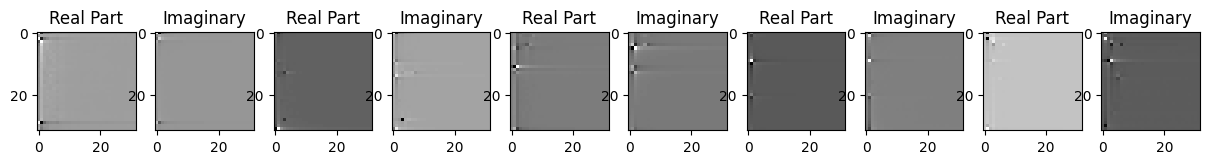

Epoch-73 lr: 0.0006561000000000001
Loss:  1.1434636917329044e-06
torch.Size([5, 2, 32, 32])


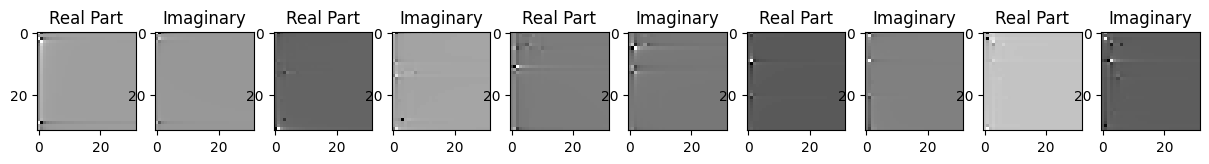

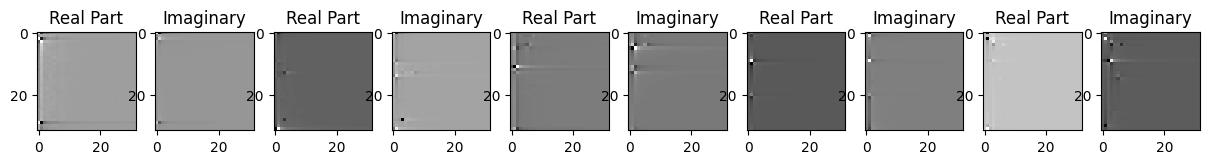

Epoch-74 lr: 0.0006561000000000001
Loss:  1.1313453569528065e-06
torch.Size([5, 2, 32, 32])


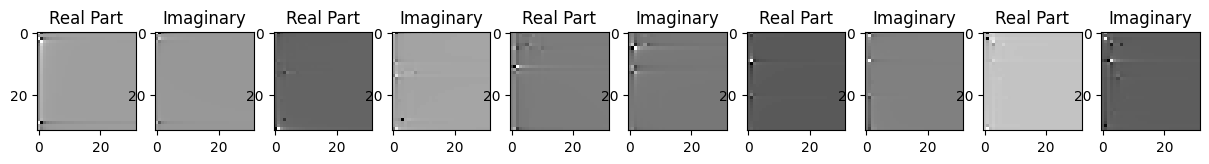

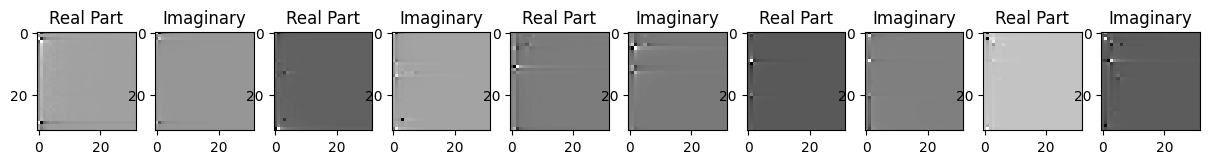

Epoch-75 lr: 0.0006561000000000001
Loss:  1.118163027058472e-06
torch.Size([5, 2, 32, 32])


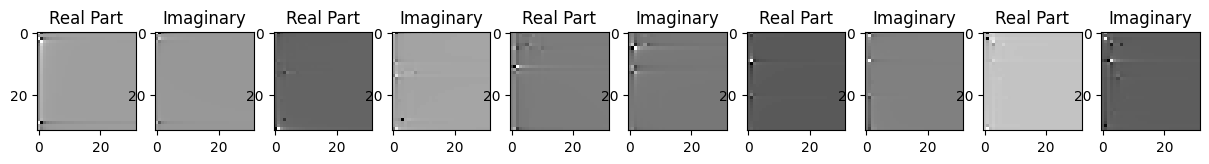

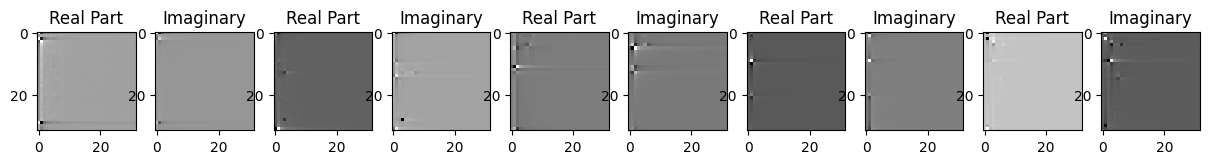

Epoch-76 lr: 0.0006561000000000001
Loss:  1.1132095778521034e-06
torch.Size([5, 2, 32, 32])


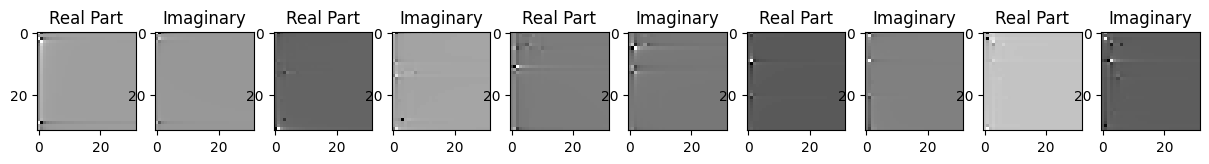

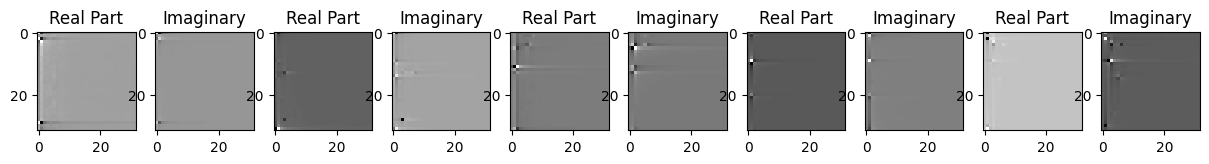

Epoch-77 lr: 0.0006561000000000001
Loss:  1.1108455737485201e-06
torch.Size([5, 2, 32, 32])


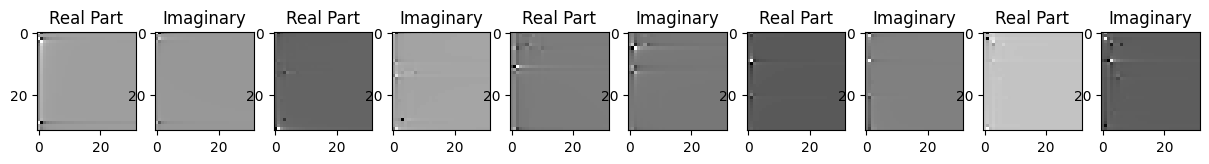

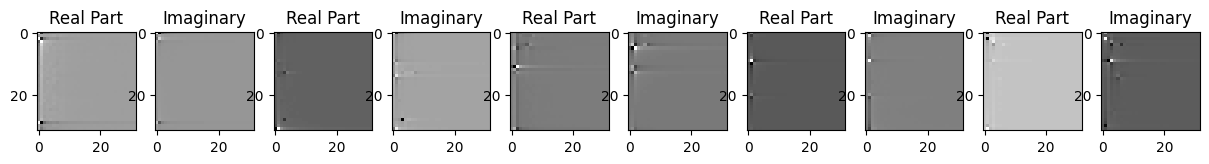

Epoch-78 lr: 0.0006561000000000001
Loss:  1.1250799616391305e-06
torch.Size([5, 2, 32, 32])


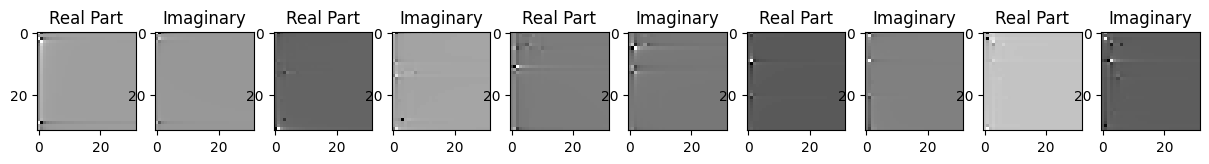

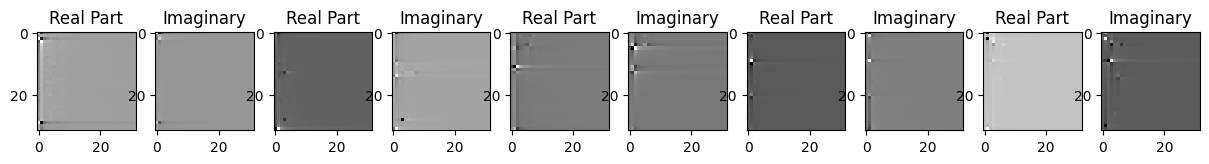

Epoch-79 lr: 0.0006561000000000001
Loss:  1.158308123194729e-06
torch.Size([5, 2, 32, 32])


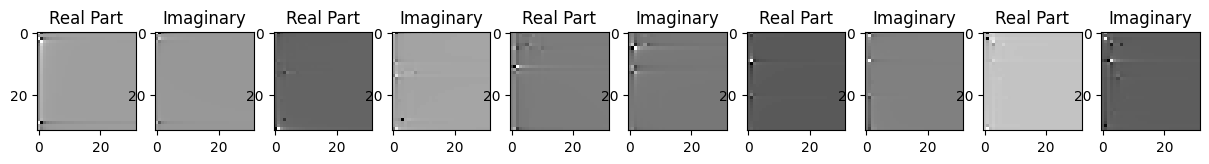

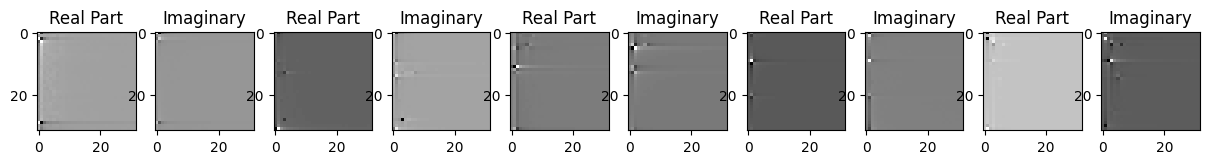

Epoch-80 lr: 0.0006561000000000001
Loss:  1.1553134982023039e-06
torch.Size([5, 2, 32, 32])


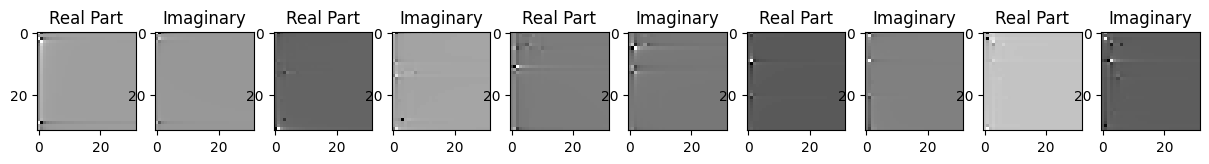

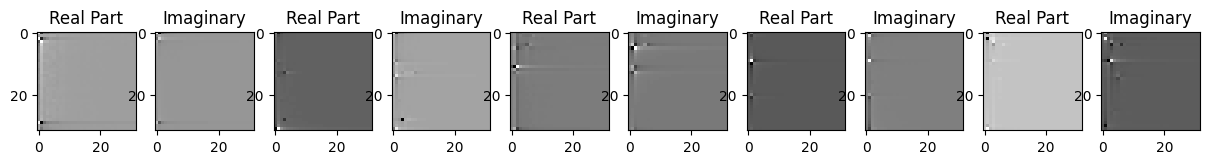

Epoch-81 lr: 0.0006561000000000001
Loss:  1.1431799293859513e-06
torch.Size([5, 2, 32, 32])


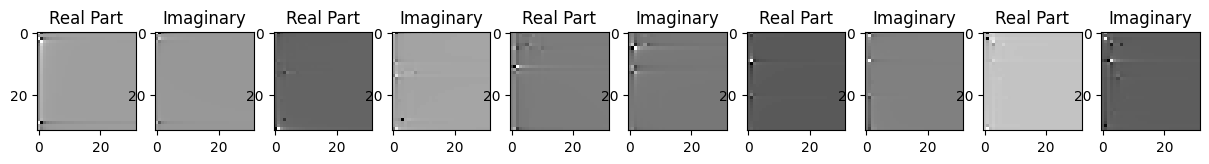

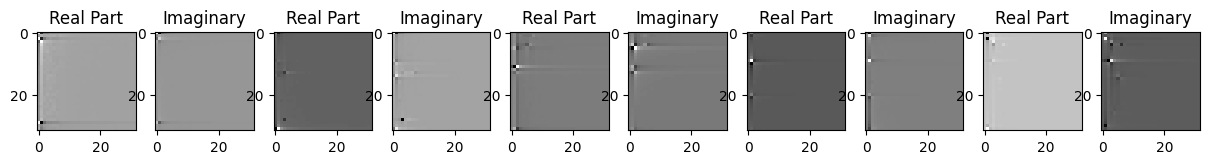

Saving model to: /content/drive/MyDrive/saved_model/_model_80_indoor_512.pth
Epoch-82 lr: 0.0006561000000000001
Loss:  1.149234662989329e-06
torch.Size([5, 2, 32, 32])


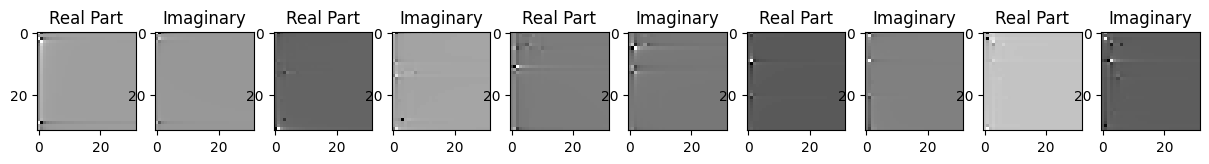

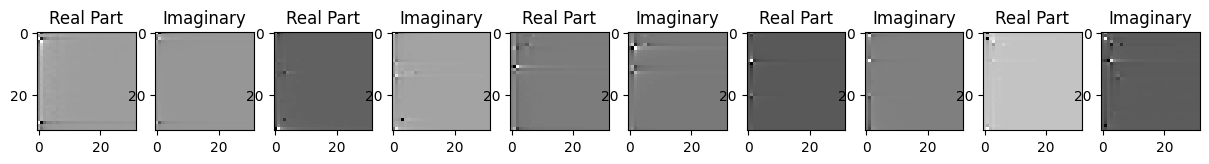

Epoch-83 lr: 0.0006561000000000001
Loss:  1.1339576531099738e-06
torch.Size([5, 2, 32, 32])


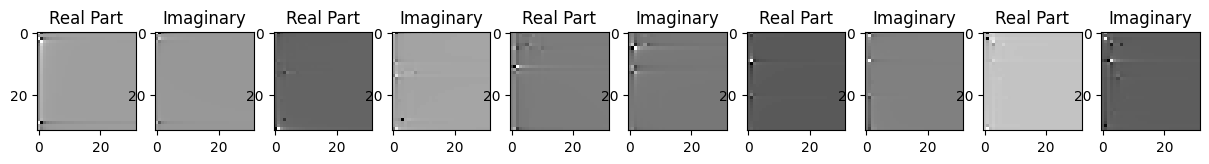

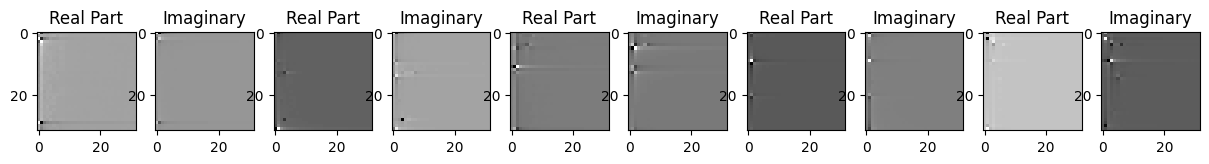

Epoch-84 lr: 0.0006561000000000001
Loss:  1.1338739795974107e-06
torch.Size([5, 2, 32, 32])


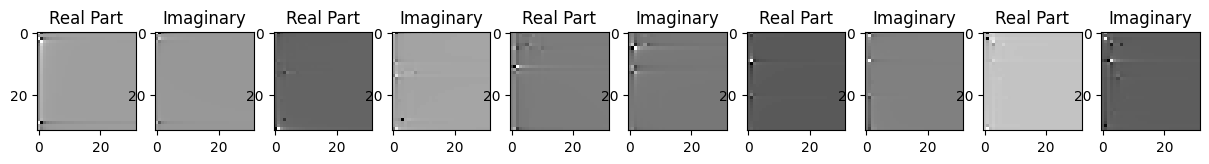

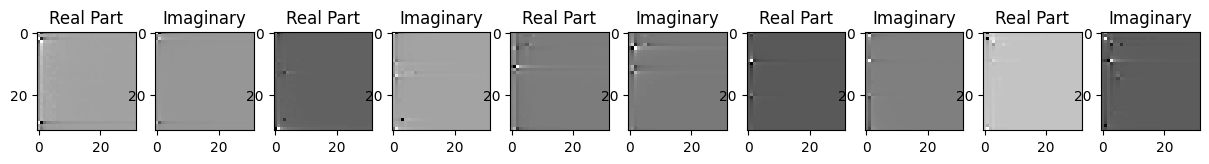

Epoch-85 lr: 0.0006561000000000001
Loss:  1.128854023590975e-06
torch.Size([5, 2, 32, 32])


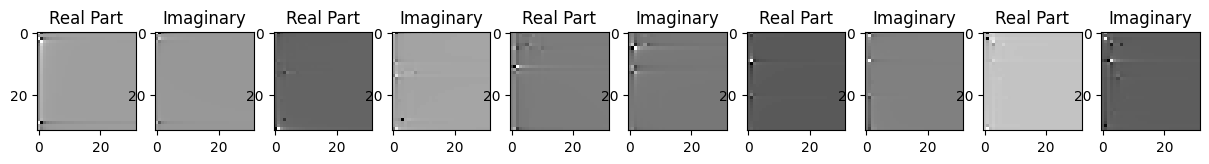

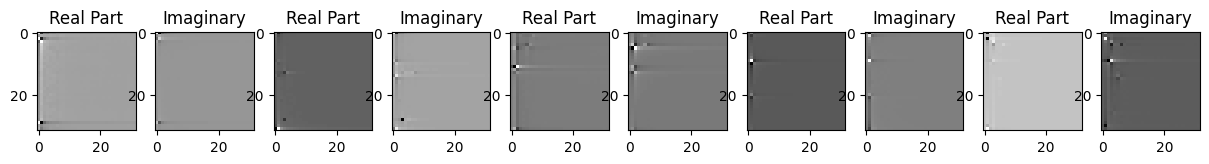

Epoch-86 lr: 0.0006561000000000001
Loss:  1.1545241704880027e-06
torch.Size([5, 2, 32, 32])


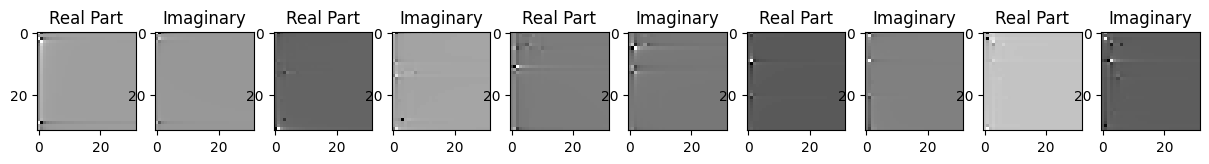

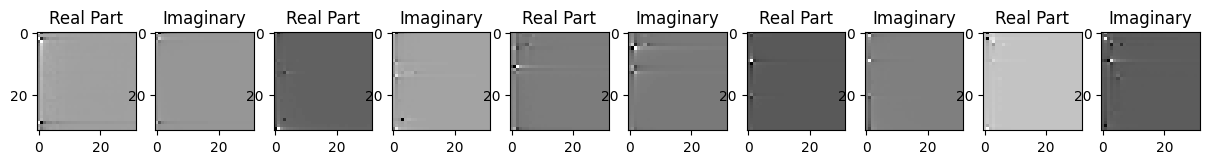

Epoch-87 lr: 0.0006561000000000001
Loss:  1.1888956805705675e-06
torch.Size([5, 2, 32, 32])


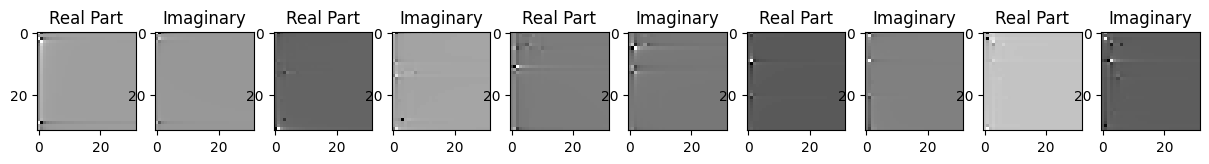

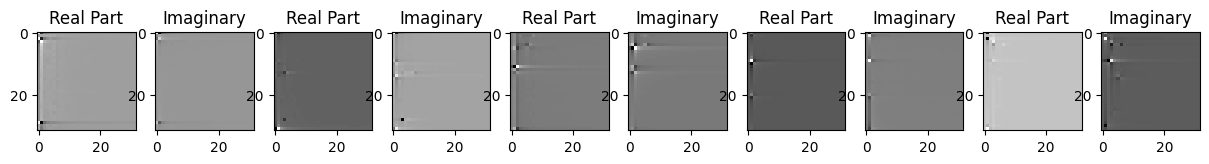

Epoch-88 lr: 0.0006561000000000001
Loss:  1.2486513014664524e-06
torch.Size([5, 2, 32, 32])


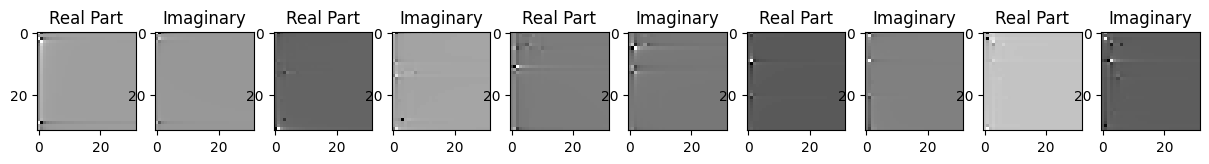

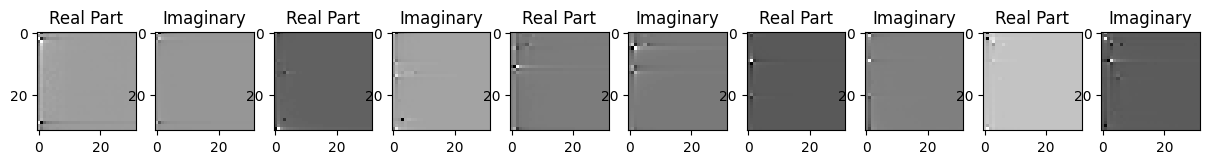

Epoch-89 lr: 0.0006561000000000001
Loss:  1.3063454389339313e-06
torch.Size([5, 2, 32, 32])


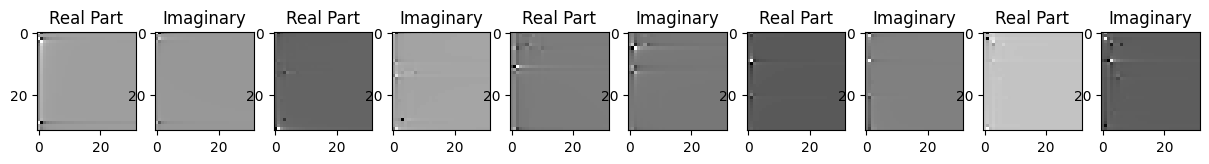

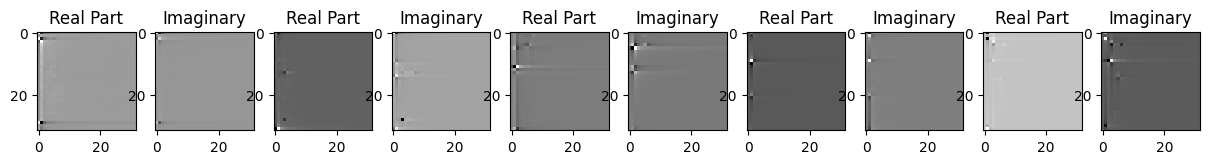

Epoch-90 lr: 0.0006561000000000001
Loss:  1.519051011200645e-06
torch.Size([5, 2, 32, 32])


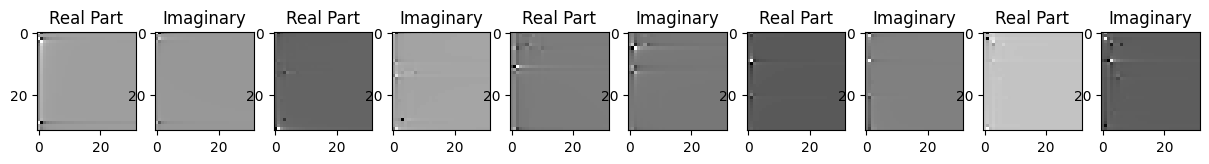

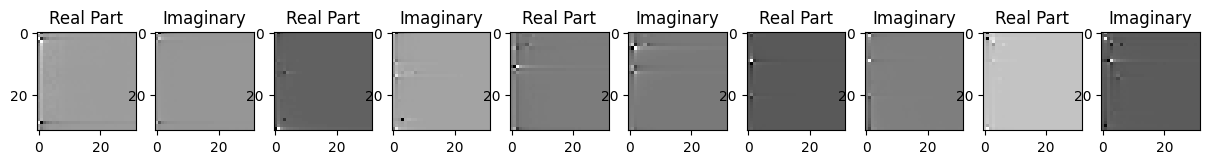

Epoch-91 lr: 0.0006561000000000001
Loss:  1.8188736703450559e-06
torch.Size([5, 2, 32, 32])


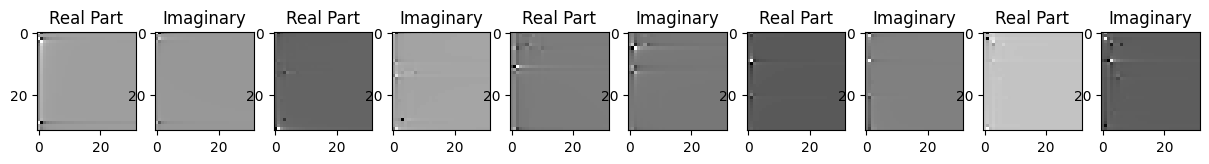

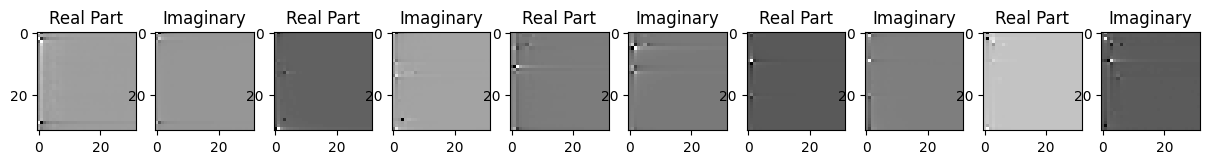

Epoch-92 lr: 0.0006561000000000001
Loss:  1.941925120263477e-06
torch.Size([5, 2, 32, 32])


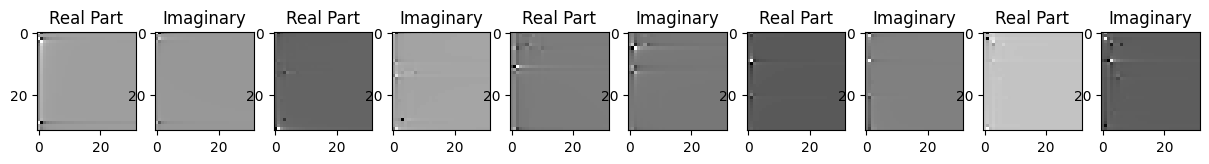

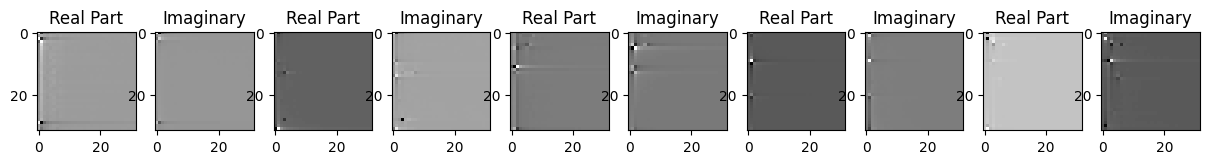

Epoch-93 lr: 0.0006561000000000001
Loss:  1.7086205161831458e-06
torch.Size([5, 2, 32, 32])


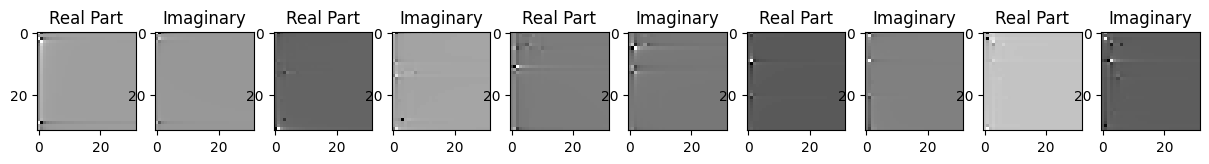

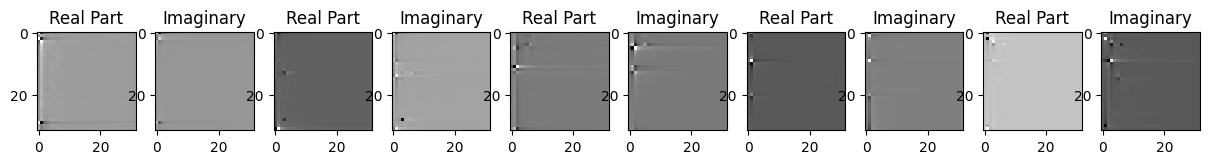

Epoch-94 lr: 0.0006561000000000001
Loss:  1.6639854720779113e-06
torch.Size([5, 2, 32, 32])


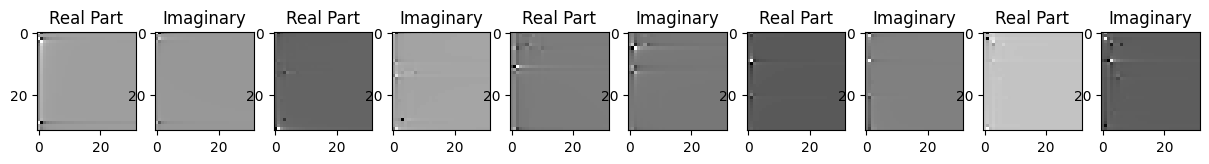

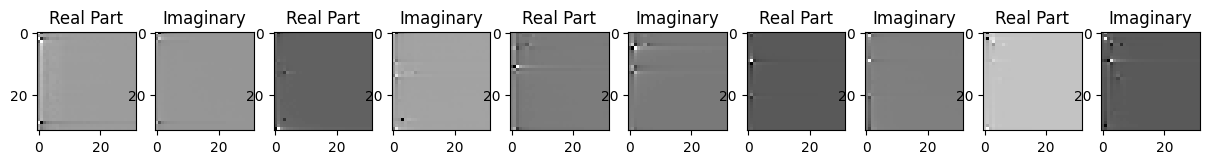

Epoch-95 lr: 0.0006561000000000001
Loss:  1.4972277995184413e-06
torch.Size([5, 2, 32, 32])


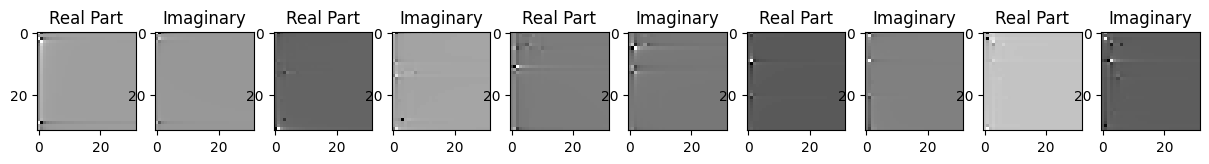

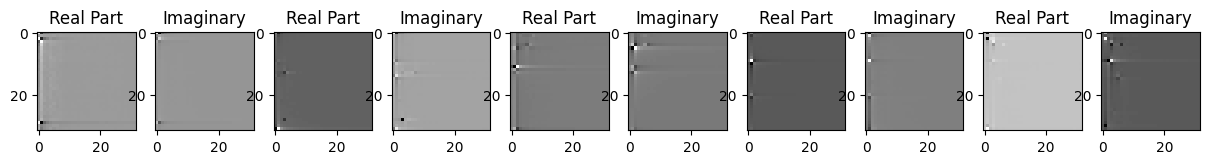

Epoch-96 lr: 0.0006561000000000001
Loss:  1.2857187812187476e-06
torch.Size([5, 2, 32, 32])


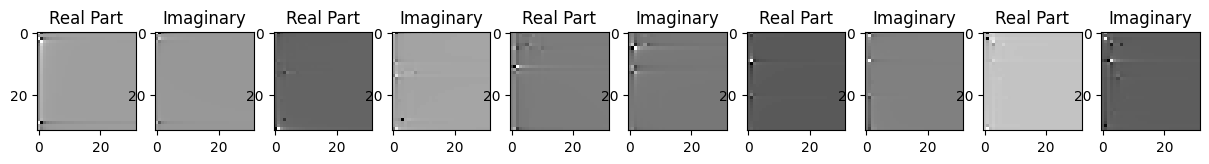

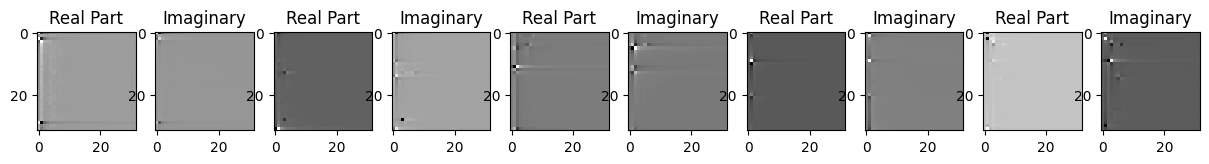

Epoch-97 lr: 0.0006561000000000001
Loss:  1.265060632249515e-06
torch.Size([5, 2, 32, 32])


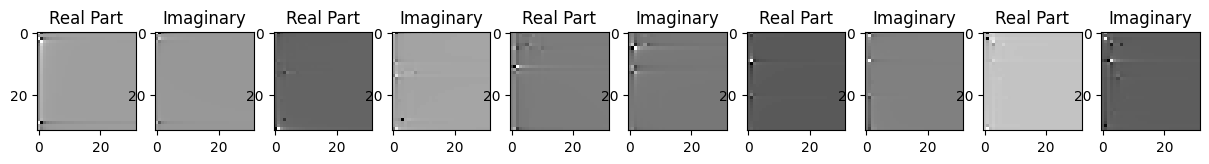

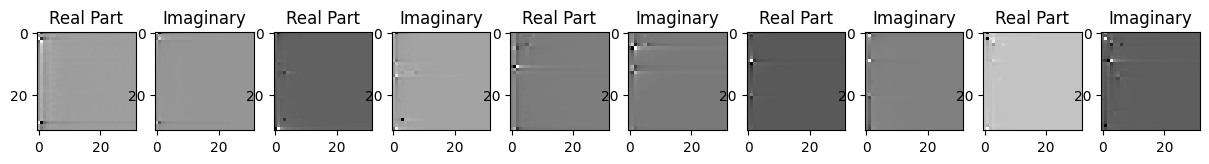

Epoch-98 lr: 0.0006561000000000001
Loss:  1.279872662962589e-06
torch.Size([5, 2, 32, 32])


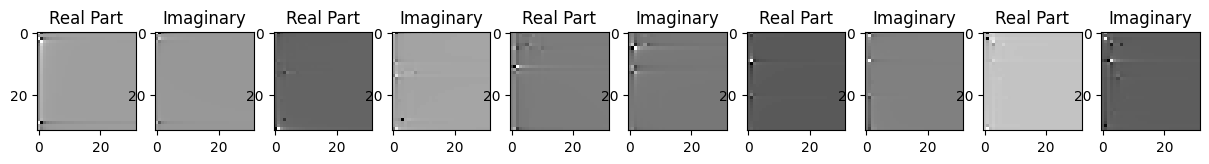

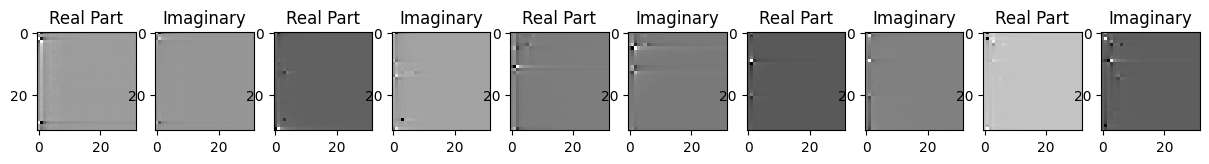

Epoch-99 lr: 0.0006561000000000001
Loss:  1.2892337508674245e-06
torch.Size([5, 2, 32, 32])


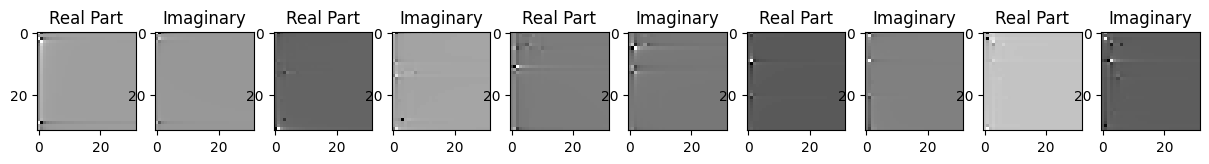

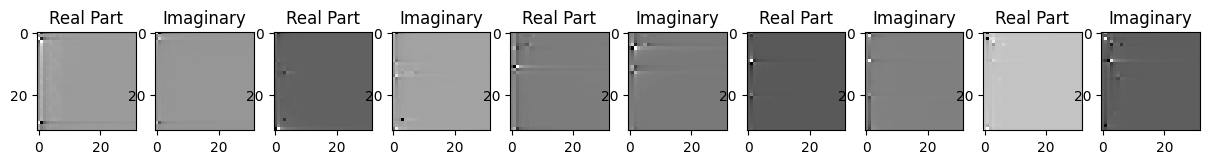

Epoch-100 lr: 0.0006561000000000001
Loss:  1.2882820783488569e-06
torch.Size([5, 2, 32, 32])


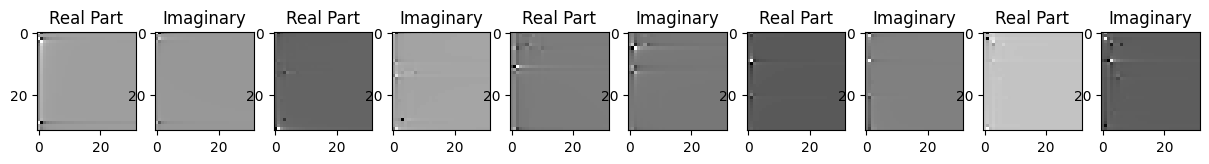

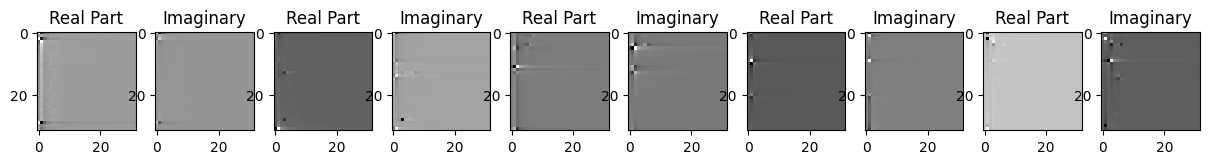

Epoch-101 lr: 0.0006561000000000001
Loss:  1.2663011830227333e-06
torch.Size([5, 2, 32, 32])


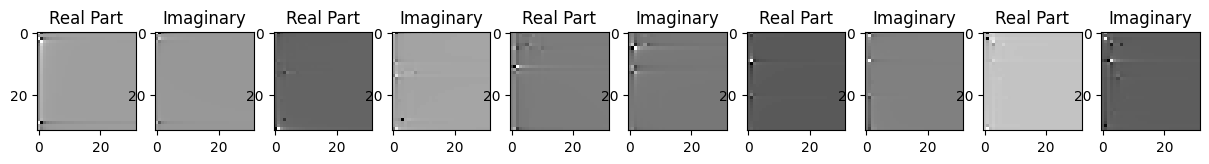

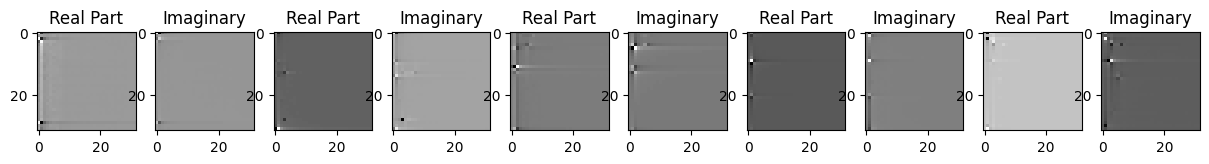

Saving model to: /content/drive/MyDrive/saved_model/_model_100_indoor_512.pth
Epoch-102 lr: 0.0006561000000000001
Loss:  1.293423565584817e-06
torch.Size([5, 2, 32, 32])


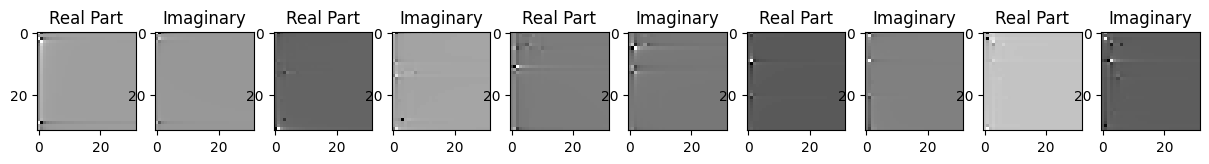

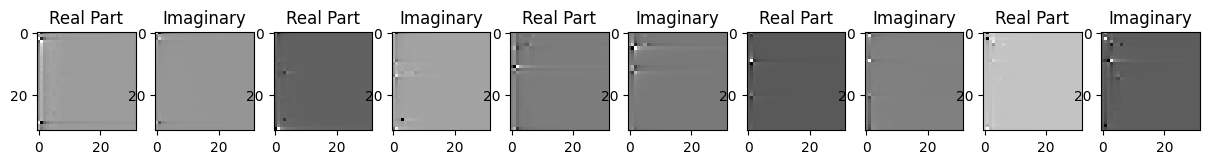

Epoch-103 lr: 0.0006561000000000001
Loss:  1.2752371958413278e-06
torch.Size([5, 2, 32, 32])


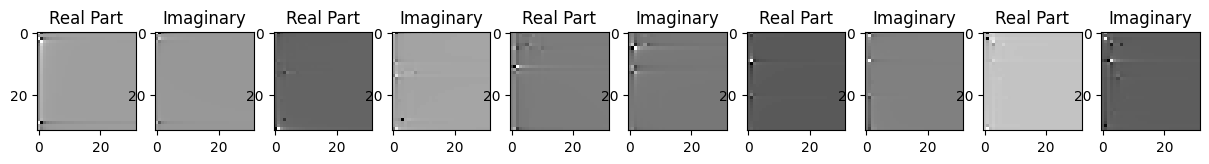

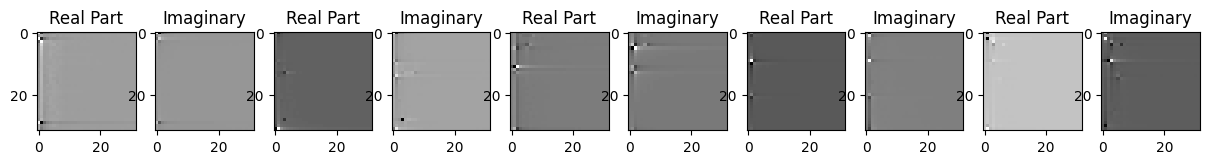

Epoch-104 lr: 0.0006561000000000001
Loss:  1.329362362412212e-06
torch.Size([5, 2, 32, 32])


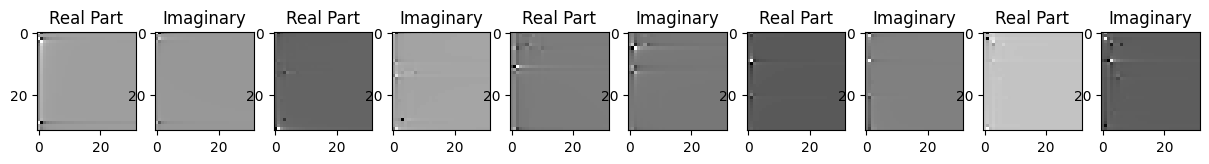

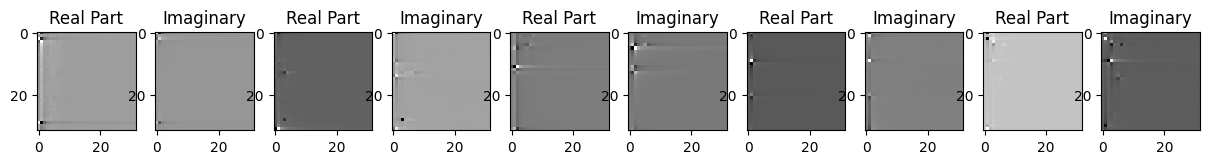

Epoch-105 lr: 0.0006561000000000001
Loss:  1.2939686939716921e-06
torch.Size([5, 2, 32, 32])


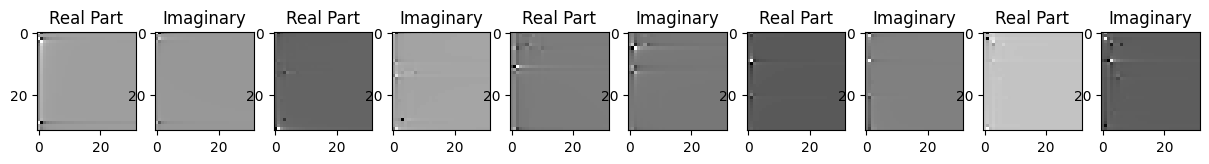

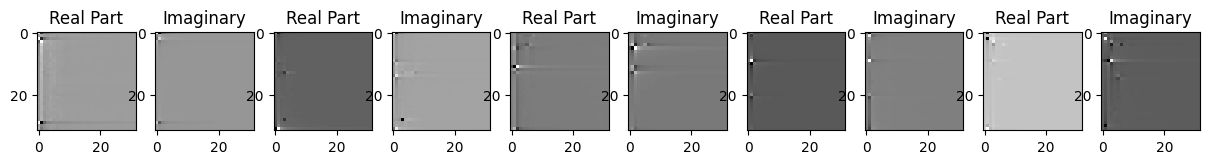

Epoch-106 lr: 0.0006561000000000001
Loss:  1.2802966011804529e-06
torch.Size([5, 2, 32, 32])


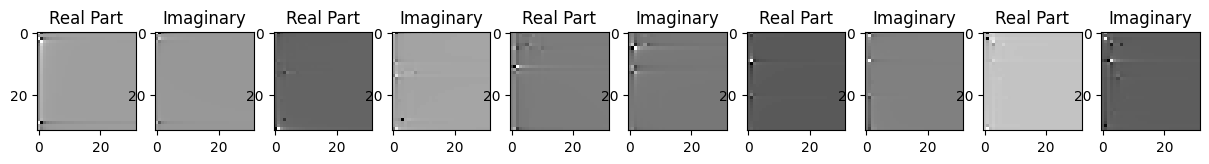

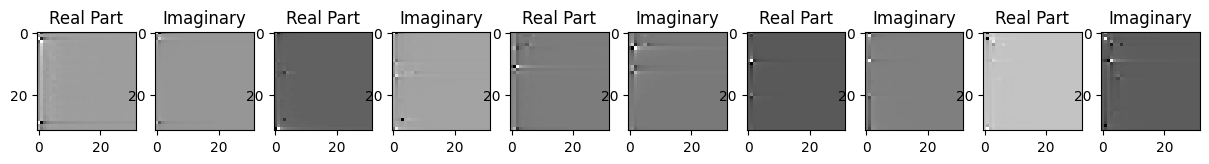

Epoch-107 lr: 0.0006561000000000001
Loss:  1.2935122413182398e-06
torch.Size([5, 2, 32, 32])


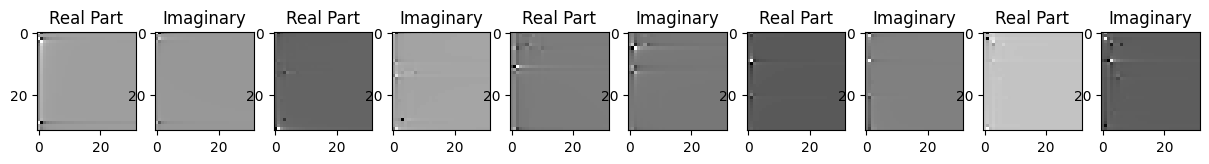

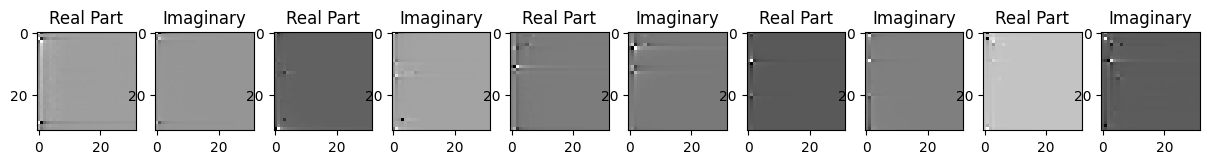

Epoch-108 lr: 0.0006561000000000001
Loss:  1.3348098946153186e-06
torch.Size([5, 2, 32, 32])


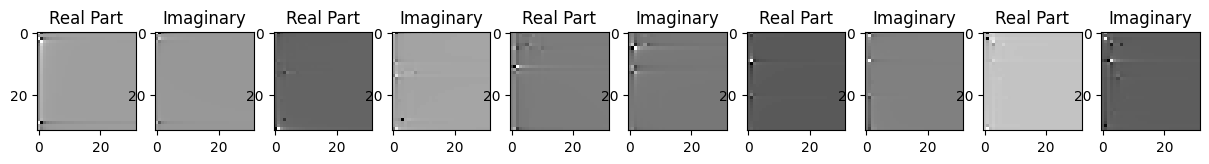

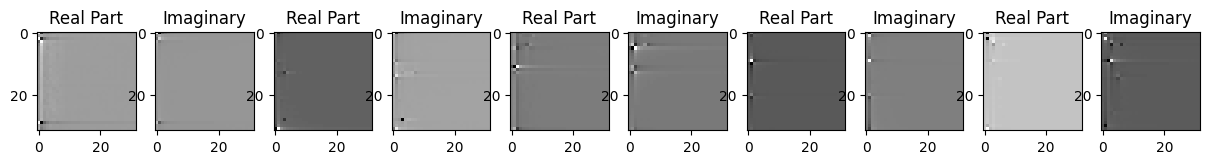

Epoch-109 lr: 0.0006561000000000001
Loss:  1.3063648793831817e-06
torch.Size([5, 2, 32, 32])


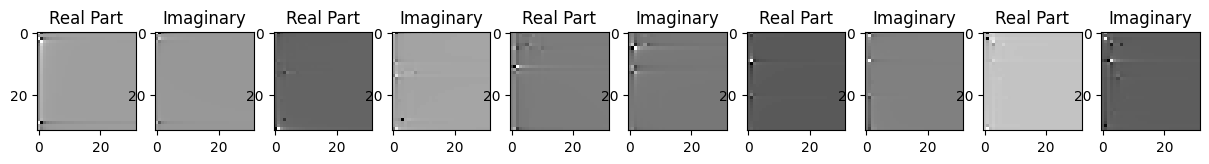

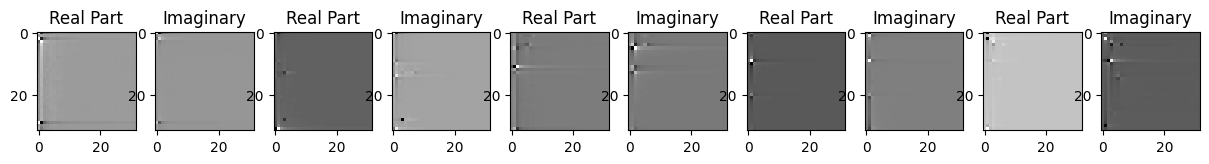

Epoch-110 lr: 0.0006561000000000001
Loss:  1.247609247911896e-06
torch.Size([5, 2, 32, 32])


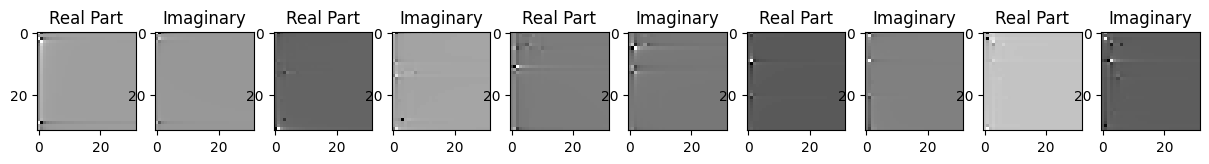

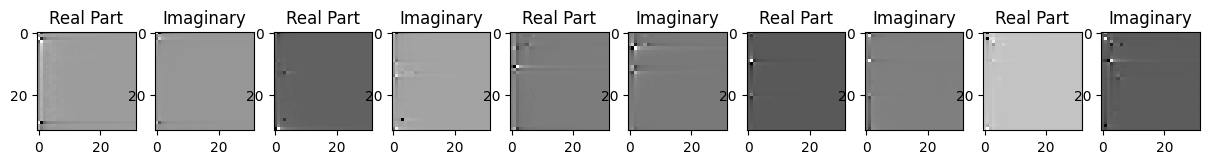

Epoch-111 lr: 0.0006561000000000001
Loss:  1.149233867181465e-06
torch.Size([5, 2, 32, 32])


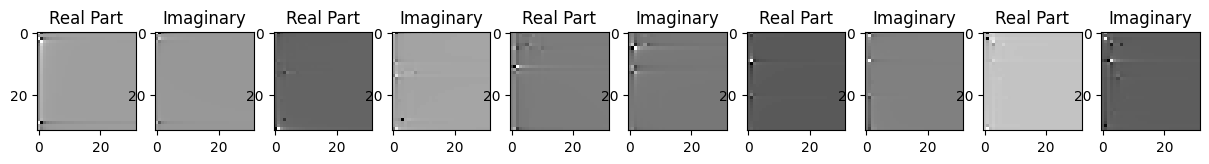

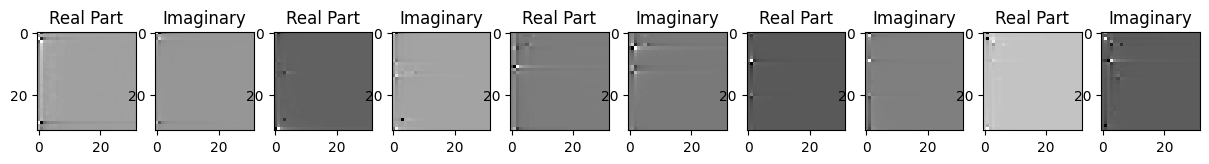

Epoch-112 lr: 0.0006561000000000001
Loss:  1.0979335911542876e-06
torch.Size([5, 2, 32, 32])


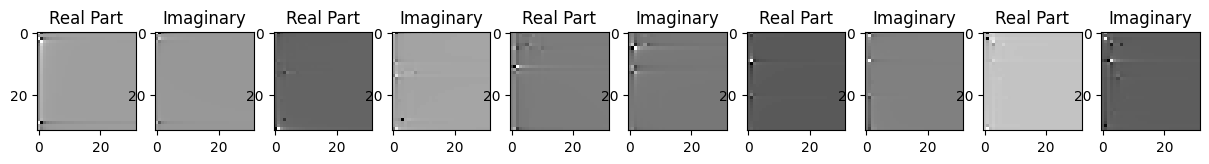

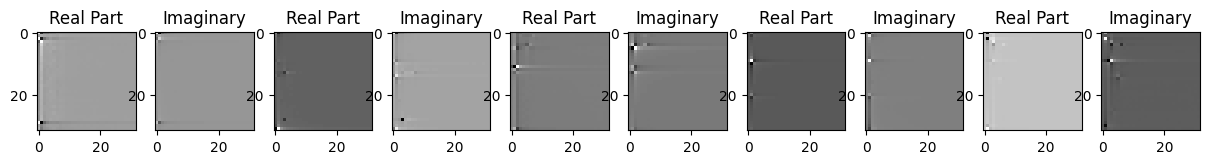

Epoch-113 lr: 0.0006561000000000001
Loss:  1.0582731420072378e-06
torch.Size([5, 2, 32, 32])


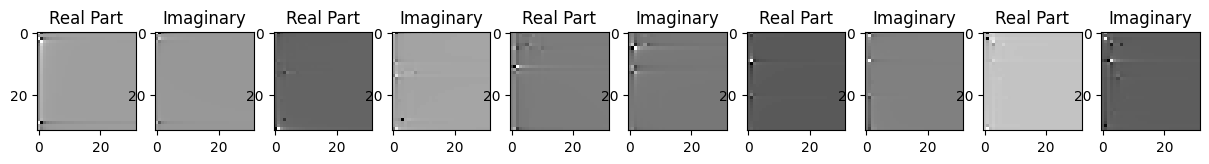

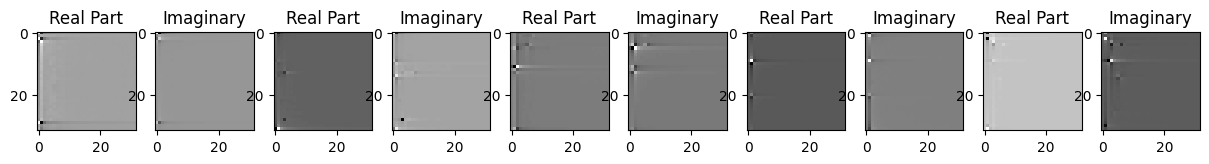

Epoch-114 lr: 0.0006561000000000001
Loss:  1.0621492947393563e-06
torch.Size([5, 2, 32, 32])


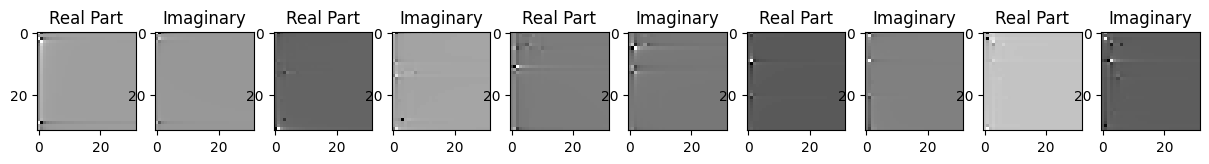

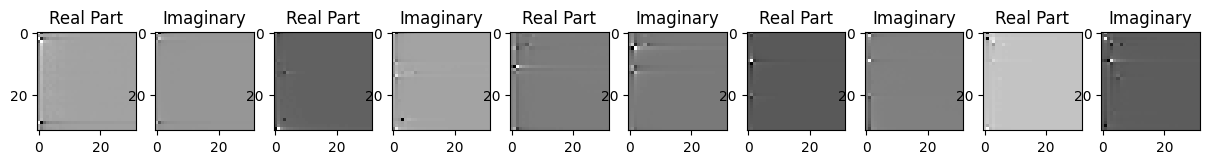

Epoch-115 lr: 0.0006561000000000001
Loss:  1.049571665134863e-06
torch.Size([5, 2, 32, 32])


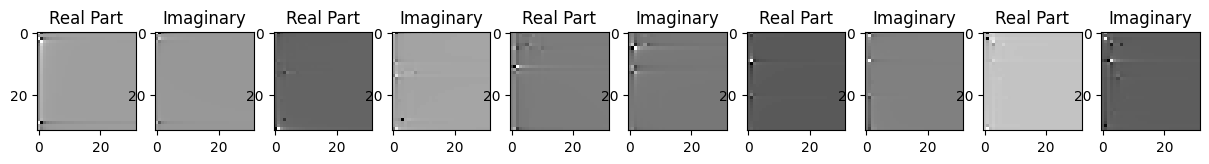

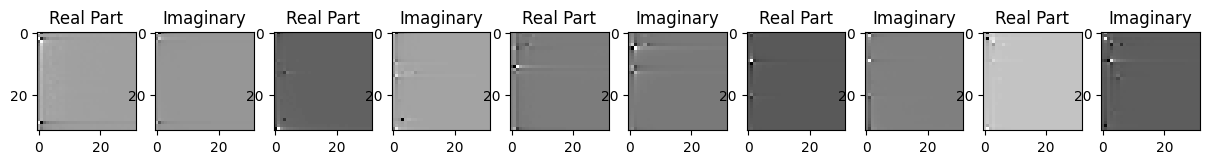

Epoch-116 lr: 0.0006561000000000001
Loss:  1.0434795285618748e-06
torch.Size([5, 2, 32, 32])


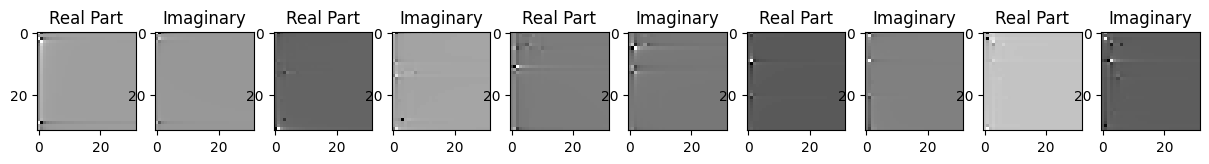

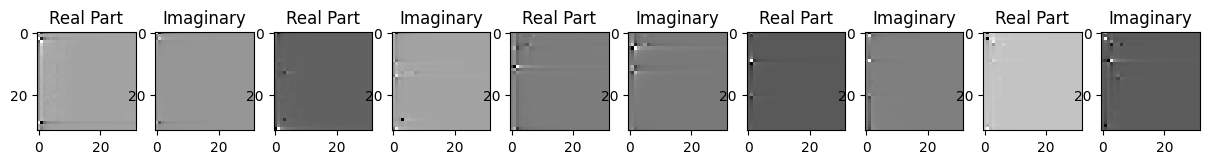

Epoch-117 lr: 0.00059049
Loss:  1.4349014918479952e-06
torch.Size([5, 2, 32, 32])


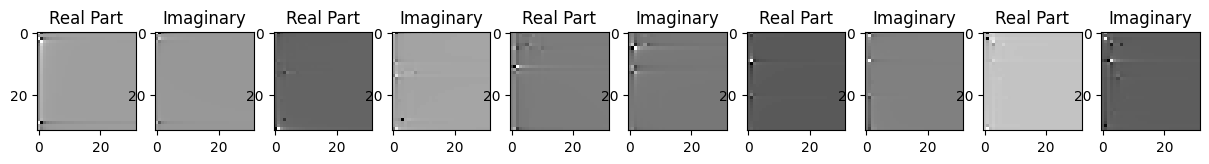

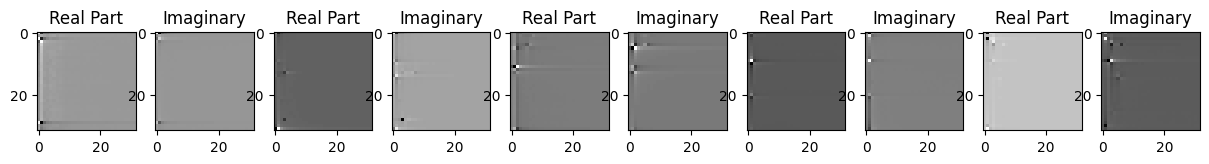

Epoch-118 lr: 0.00059049
Loss:  1.567821527714841e-06
torch.Size([5, 2, 32, 32])


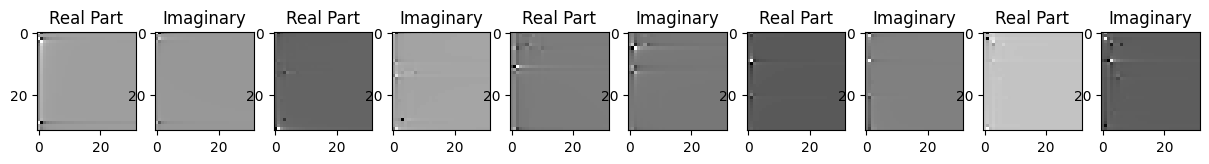

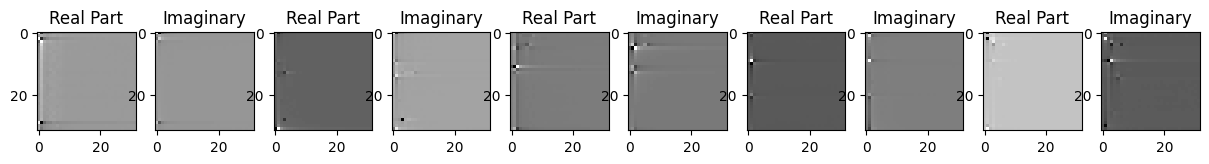

Epoch-119 lr: 0.00059049
Loss:  1.5119749150471762e-06
torch.Size([5, 2, 32, 32])


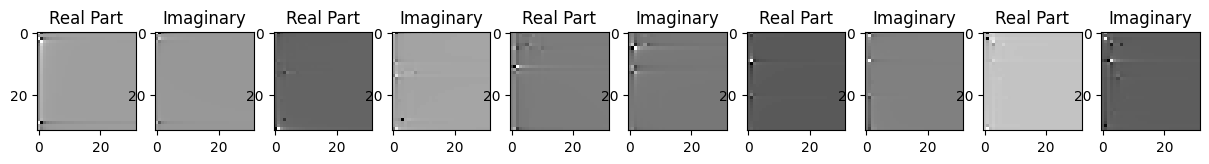

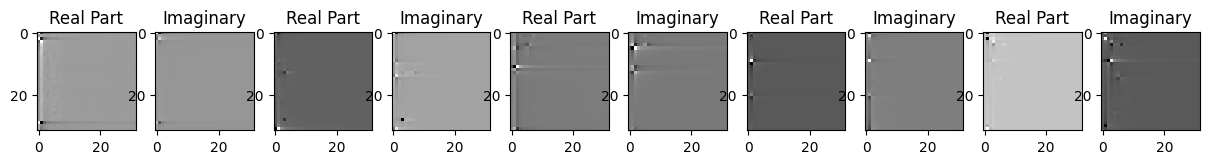

Epoch-120 lr: 0.00059049
Loss:  1.3272916703499504e-06
torch.Size([5, 2, 32, 32])


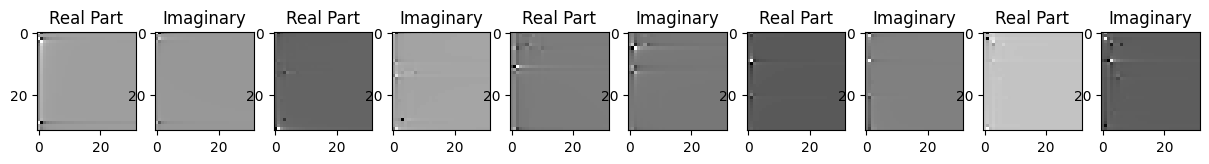

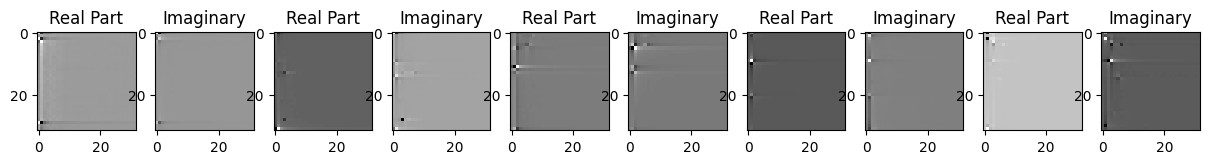

Epoch-121 lr: 0.00059049
Loss:  1.1938681154788355e-06
torch.Size([5, 2, 32, 32])


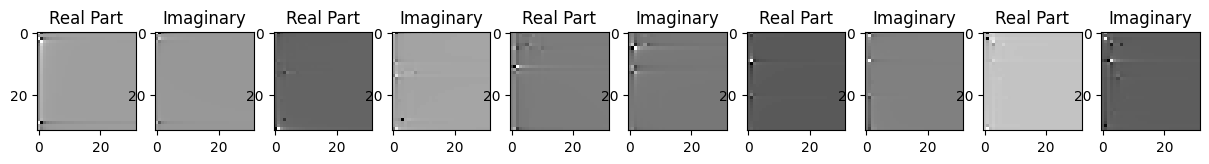

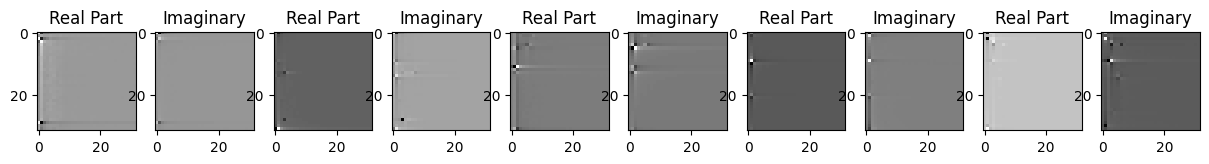

Saving model to: /content/drive/MyDrive/saved_model/_model_120_indoor_512.pth
Epoch-122 lr: 0.00059049
Loss:  1.059753458321211e-06
torch.Size([5, 2, 32, 32])


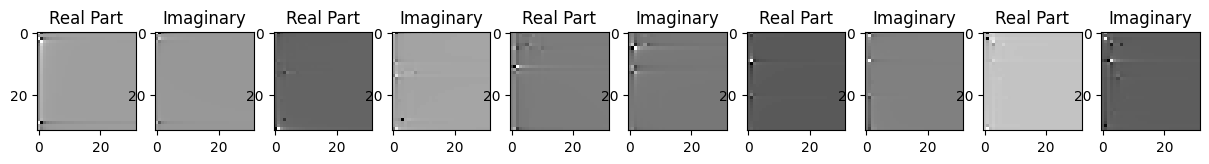

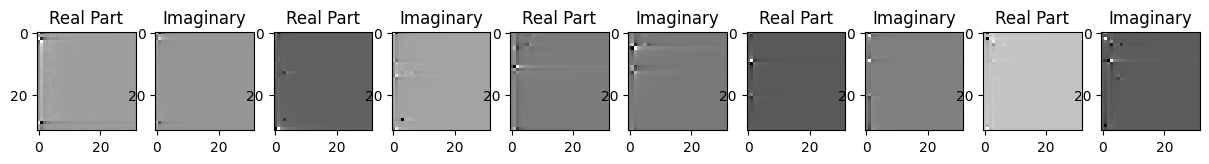

Epoch-123 lr: 0.00059049
Loss:  1.109742129301594e-06
torch.Size([5, 2, 32, 32])


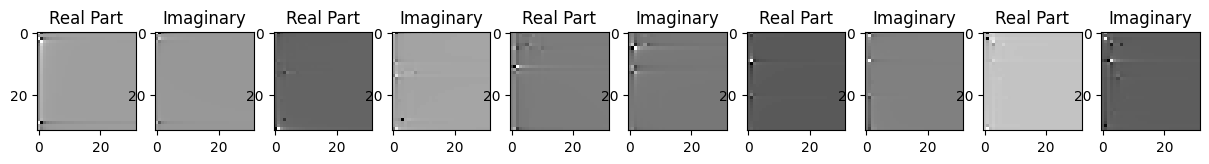

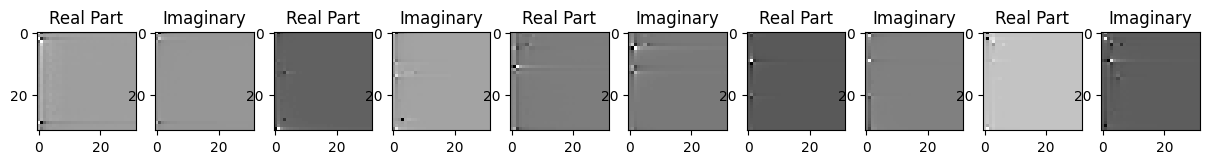

Epoch-124 lr: 0.00059049
Loss:  1.1388815437385347e-06
torch.Size([5, 2, 32, 32])


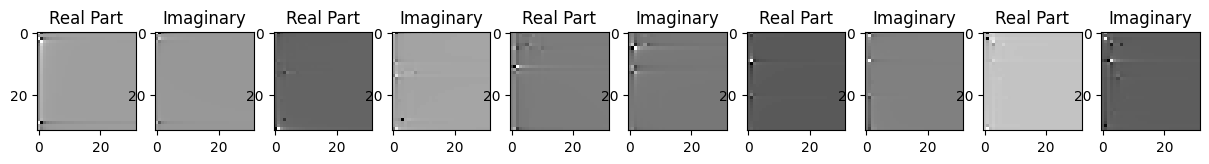

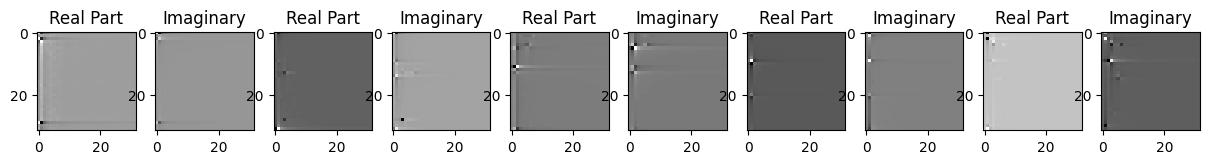

Epoch-125 lr: 0.00059049
Loss:  1.1587650305955322e-06
torch.Size([5, 2, 32, 32])


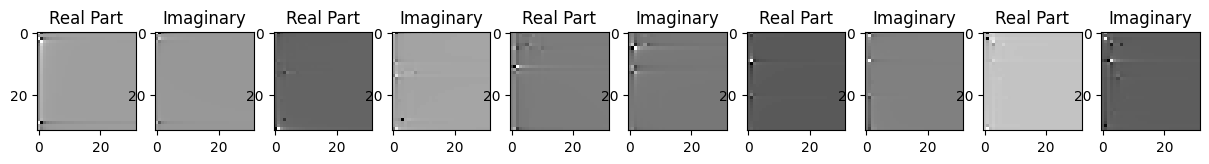

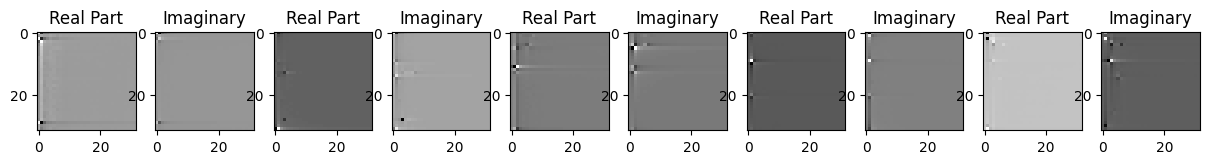

Epoch-126 lr: 0.00059049
Loss:  1.1198151241842424e-06
torch.Size([5, 2, 32, 32])


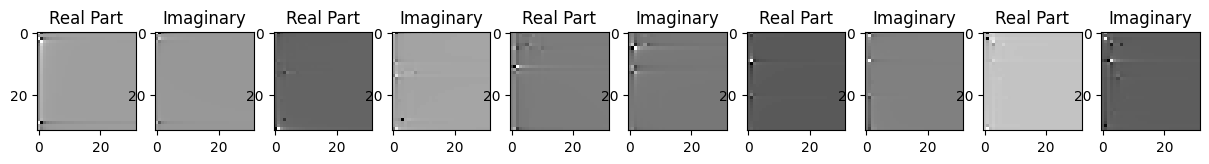

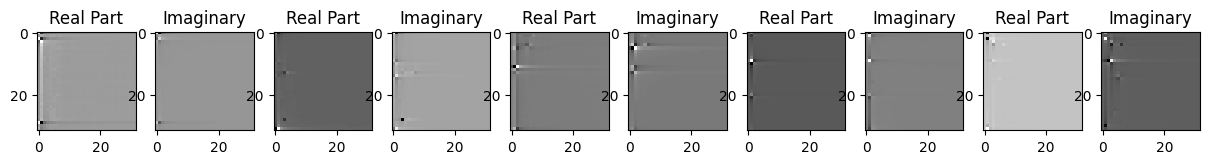

Epoch-127 lr: 0.00059049
Loss:  1.0855441132662236e-06
torch.Size([5, 2, 32, 32])


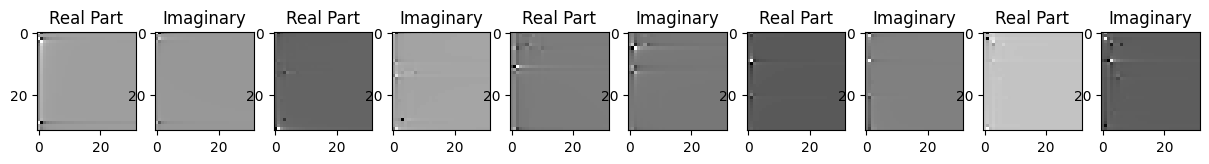

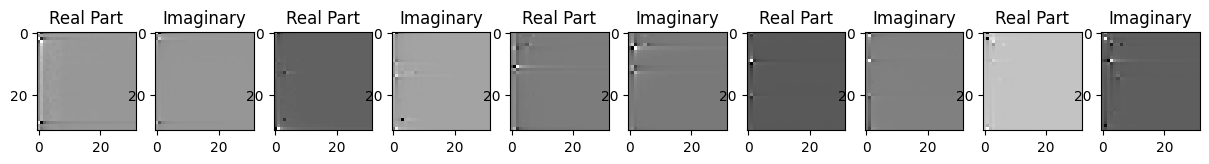

Epoch-128 lr: 0.00059049
Loss:  1.074221586350177e-06
torch.Size([5, 2, 32, 32])


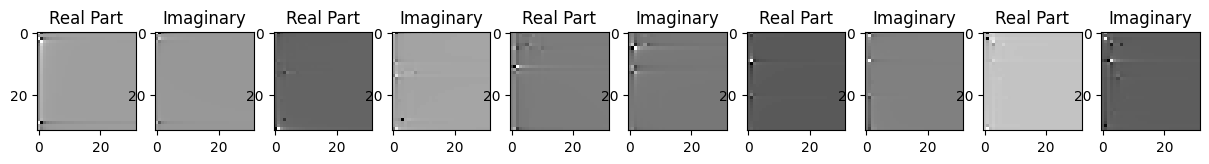

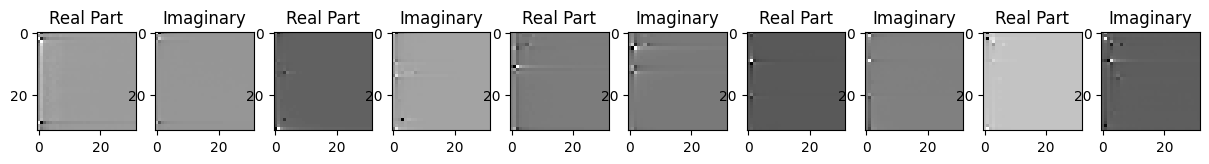

Epoch-129 lr: 0.00059049
Loss:  1.0498442861717194e-06
torch.Size([5, 2, 32, 32])


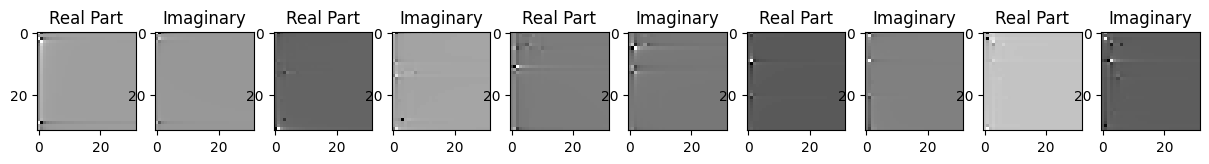

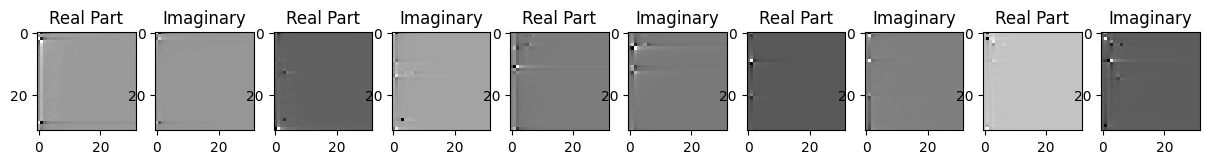

Epoch-130 lr: 0.00059049
Loss:  1.047280193233746e-06
torch.Size([5, 2, 32, 32])


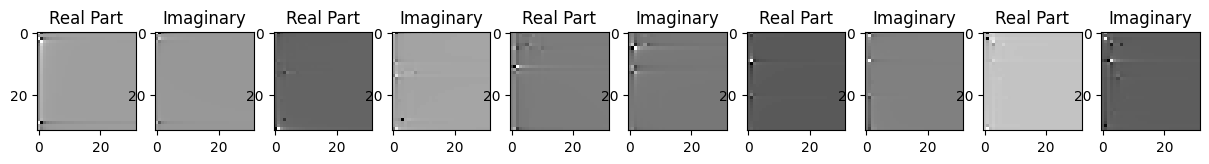

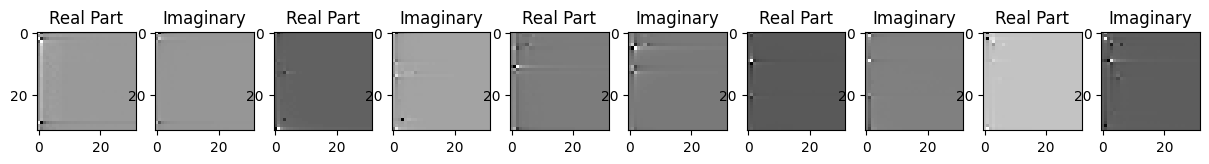

Epoch-131 lr: 0.00059049
Loss:  1.0353630841564154e-06
torch.Size([5, 2, 32, 32])


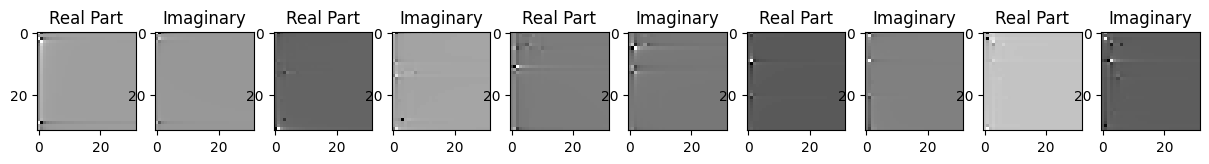

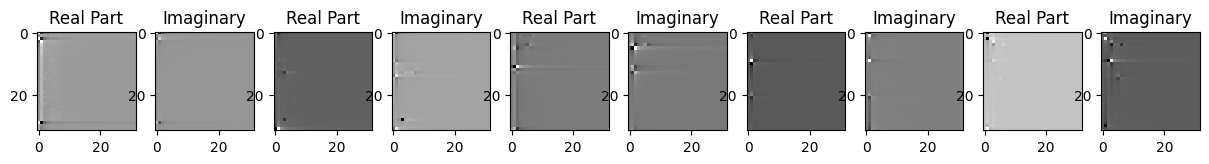

Epoch-132 lr: 0.00059049
Loss:  1.0275750810251338e-06
torch.Size([5, 2, 32, 32])


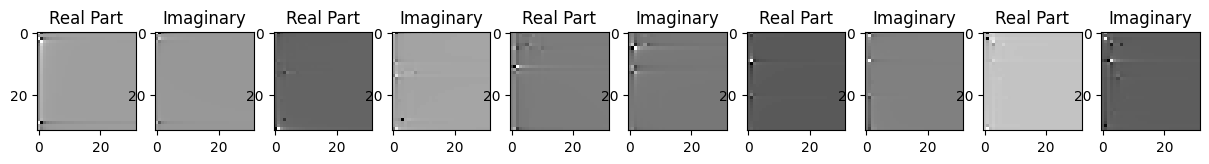

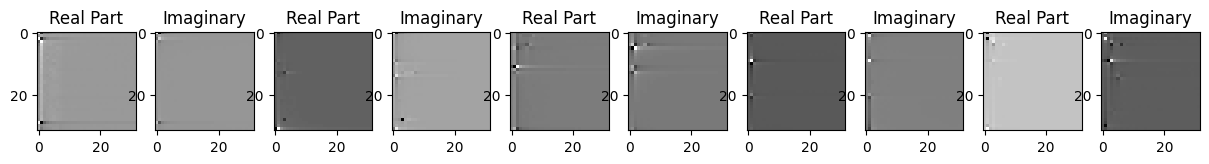

Epoch-133 lr: 0.00059049
Loss:  1.0403726946606184e-06
torch.Size([5, 2, 32, 32])


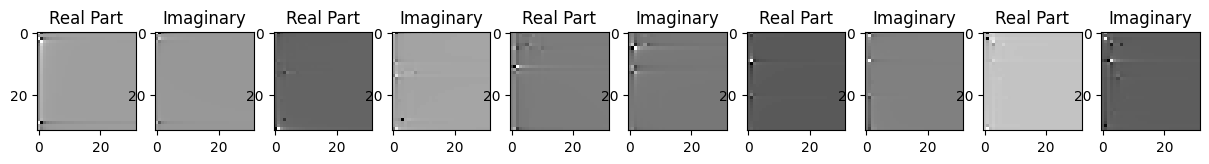

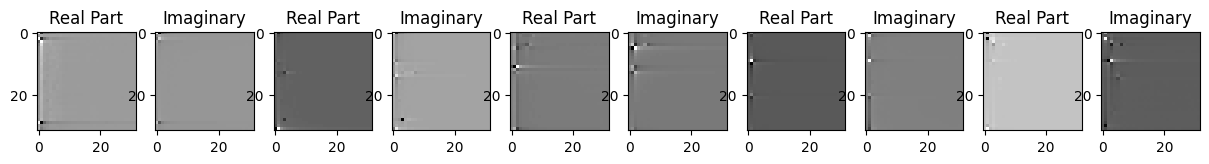

Epoch-134 lr: 0.00059049
Loss:  1.0704001169870025e-06
torch.Size([5, 2, 32, 32])


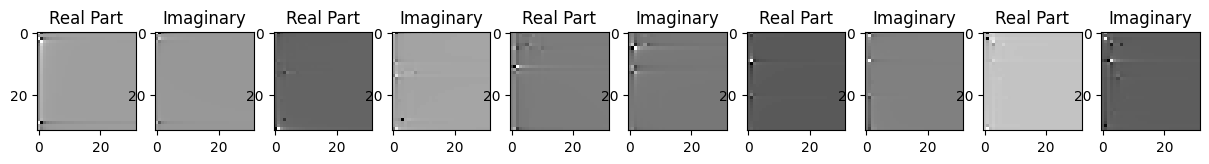

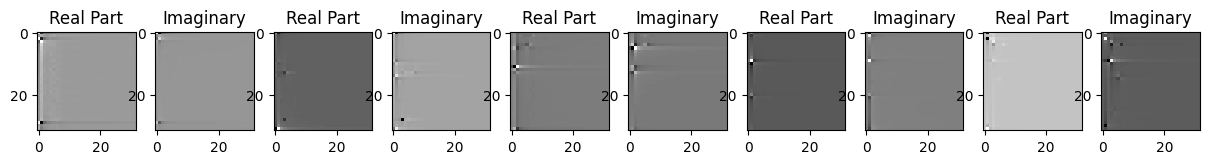

Epoch-135 lr: 0.00059049
Loss:  1.1347971167197102e-06
torch.Size([5, 2, 32, 32])


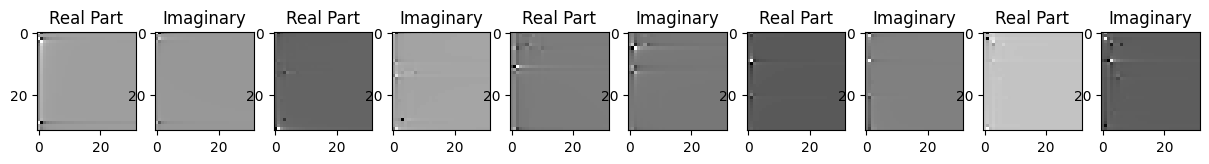

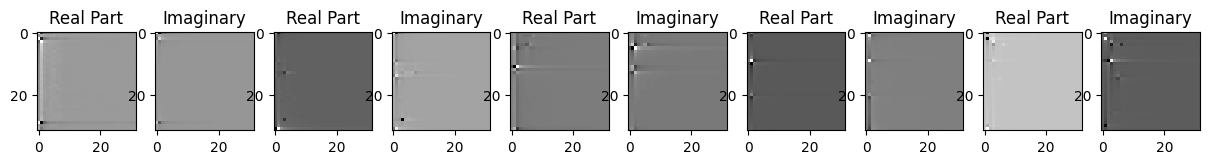

Epoch-136 lr: 0.00059049
Loss:  1.1370445918146288e-06
torch.Size([5, 2, 32, 32])


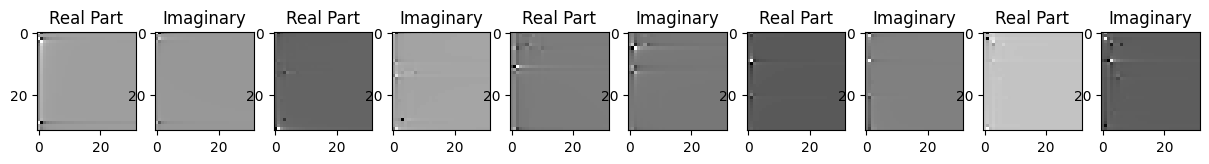

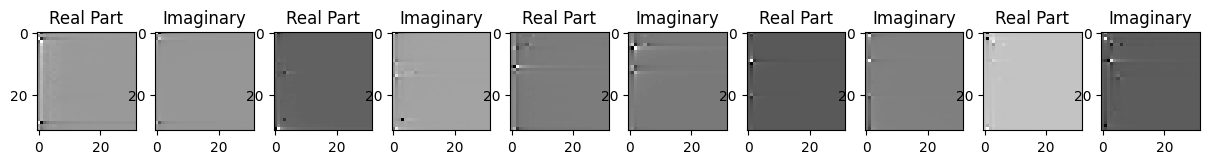

Epoch-137 lr: 0.00059049
Loss:  1.1774071708714473e-06
torch.Size([5, 2, 32, 32])


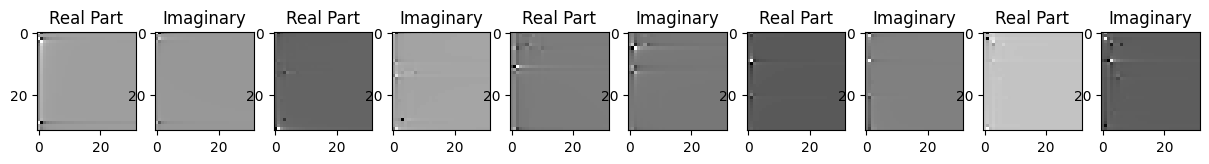

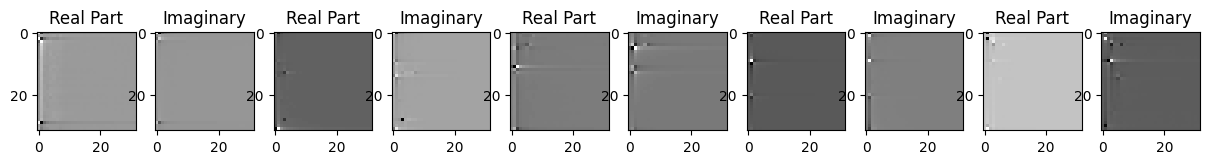

Epoch-138 lr: 0.00059049
Loss:  1.2522169754447532e-06
torch.Size([5, 2, 32, 32])


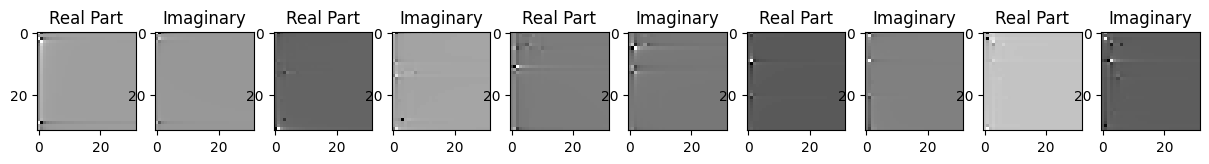

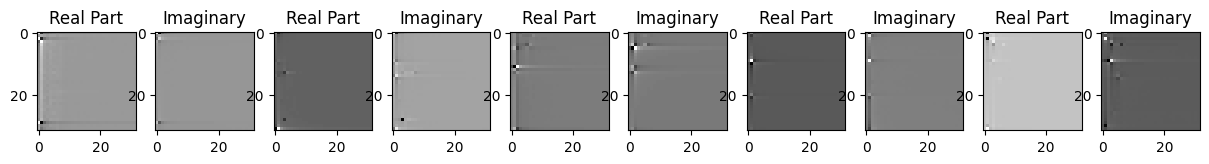

Epoch-139 lr: 0.00059049
Loss:  1.2679998917519697e-06
torch.Size([5, 2, 32, 32])


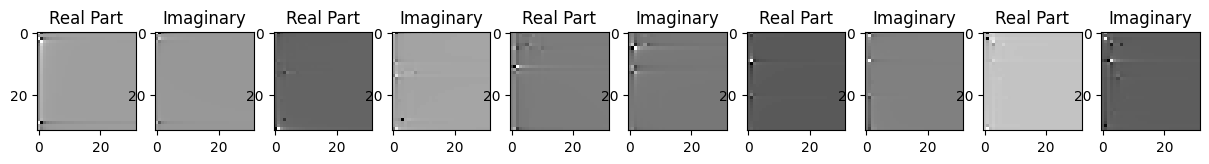

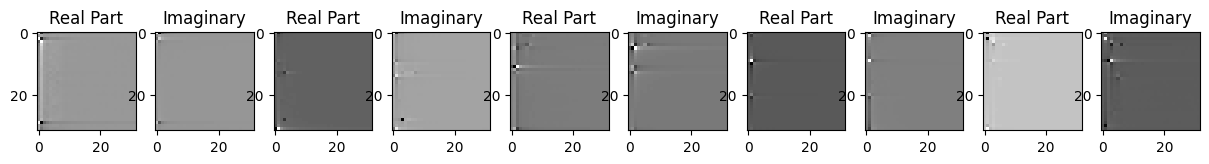

Epoch-140 lr: 0.00059049
Loss:  1.267456582354498e-06
torch.Size([5, 2, 32, 32])


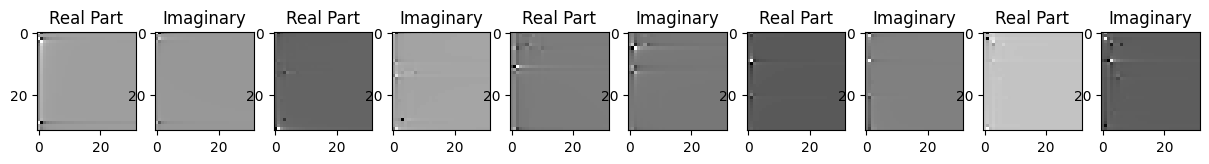

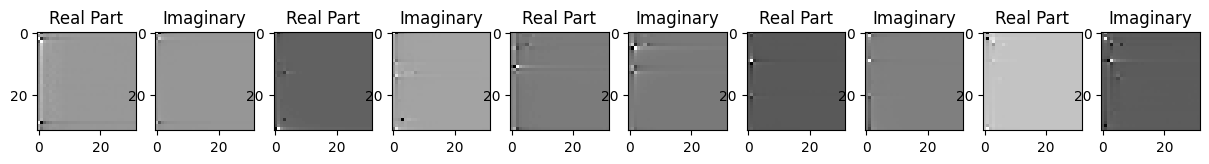

Epoch-141 lr: 0.00059049
Loss:  1.2646872846744373e-06
torch.Size([5, 2, 32, 32])


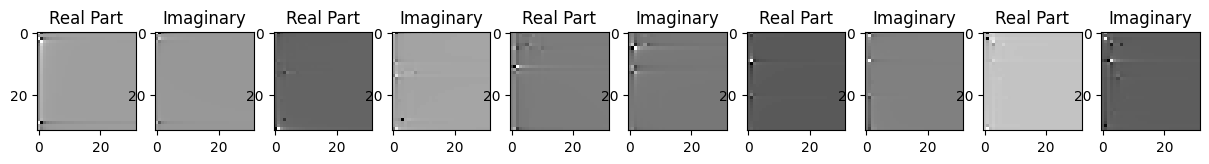

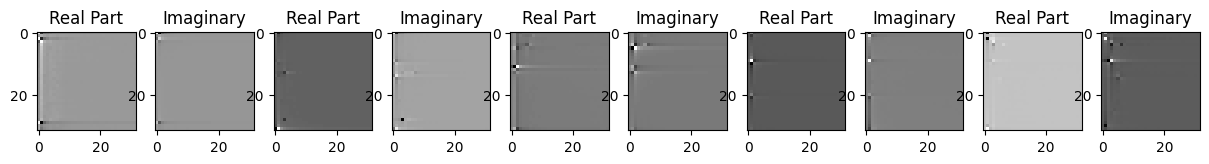

Saving model to: /content/drive/MyDrive/saved_model/_model_140_indoor_512.pth
Epoch-142 lr: 0.00059049
Loss:  1.2868374597019283e-06
torch.Size([5, 2, 32, 32])


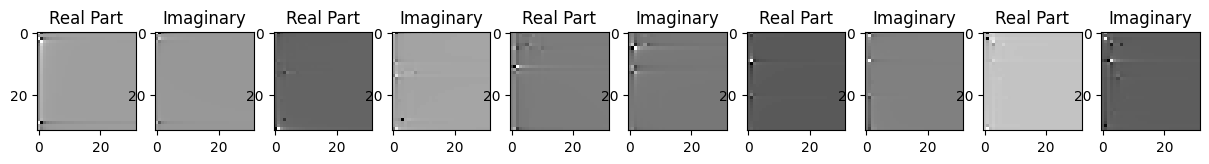

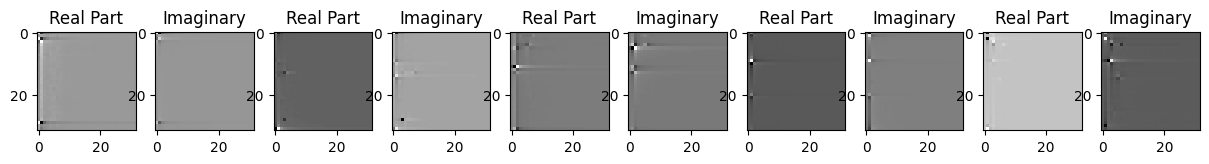

Epoch-143 lr: 0.00059049
Loss:  1.2485883189583546e-06
torch.Size([5, 2, 32, 32])


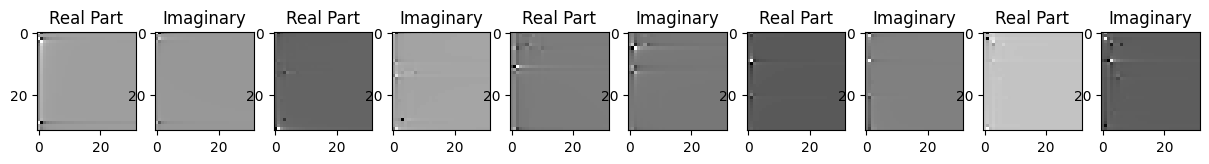

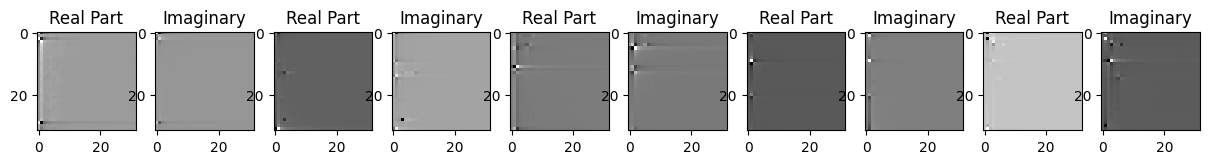

Epoch-144 lr: 0.00059049
Loss:  1.2394002624205314e-06
torch.Size([5, 2, 32, 32])


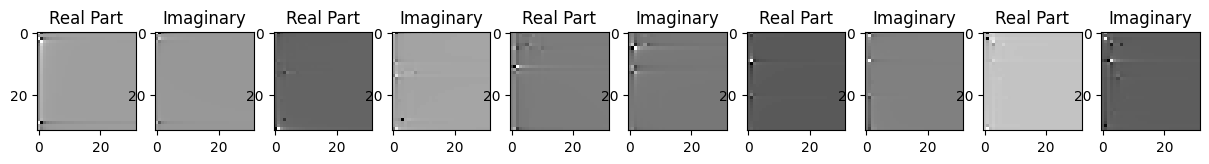

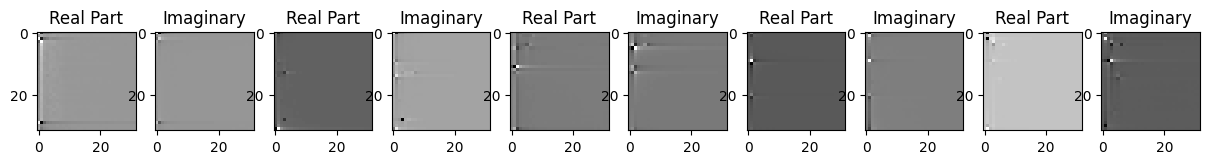

Epoch-145 lr: 0.00059049
Loss:  1.2198987633382785e-06
torch.Size([5, 2, 32, 32])


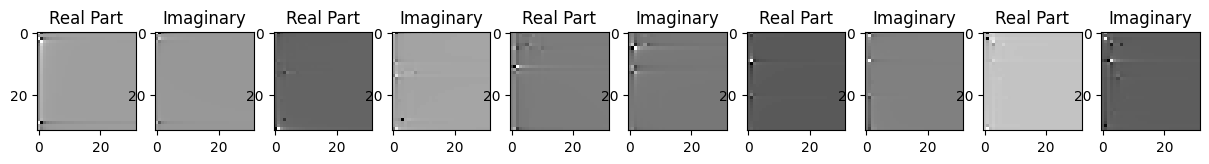

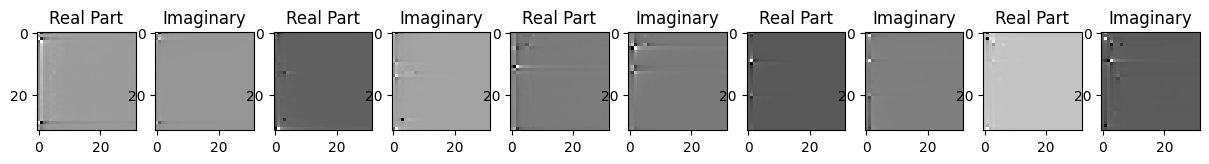

Epoch-146 lr: 0.00059049
Loss:  1.2140947092120769e-06
torch.Size([5, 2, 32, 32])


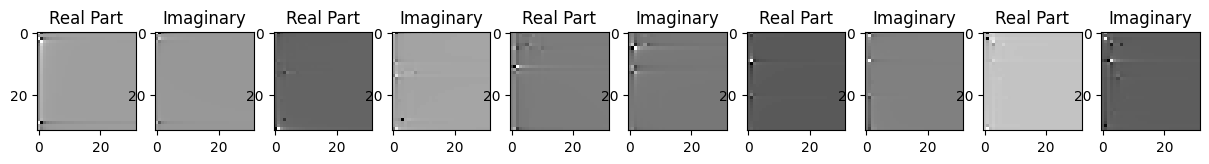

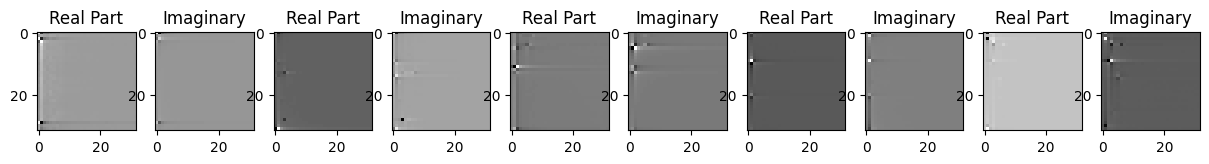

Epoch-147 lr: 0.00059049
Loss:  1.1939935120608425e-06
torch.Size([5, 2, 32, 32])


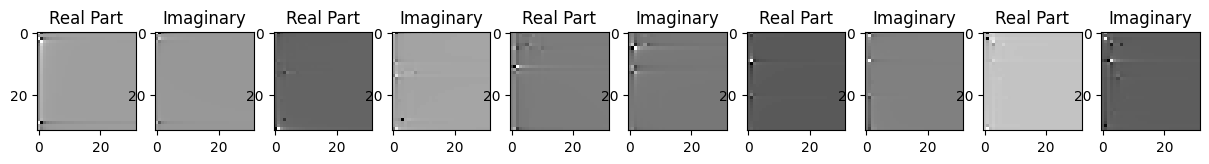

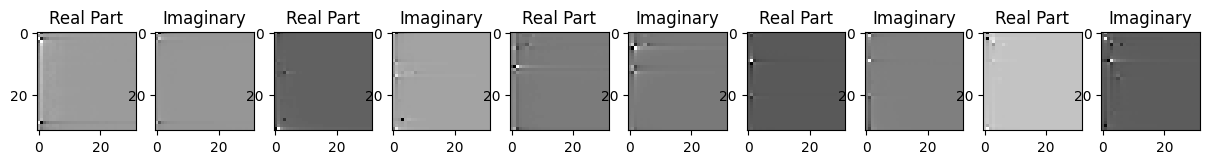

Epoch-148 lr: 0.00059049
Loss:  1.176107048195263e-06
torch.Size([5, 2, 32, 32])


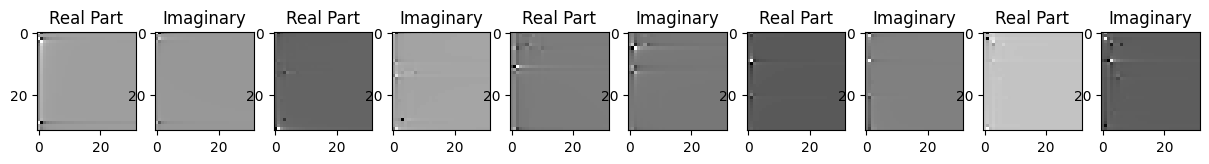

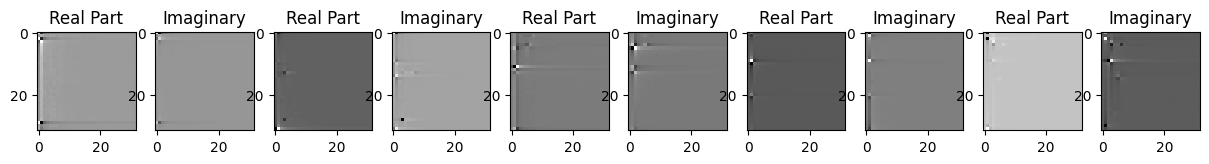

Epoch-149 lr: 0.00059049
Loss:  1.1257055803071125e-06
torch.Size([5, 2, 32, 32])


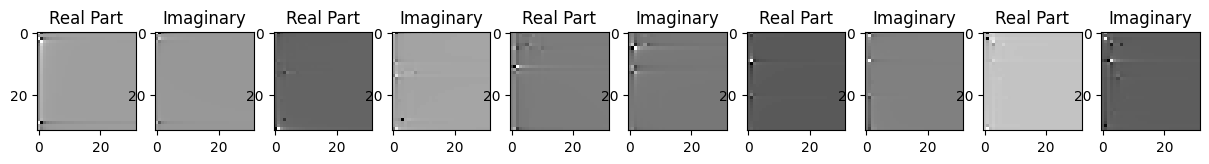

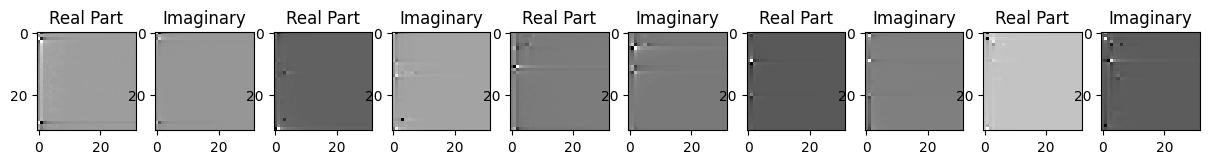

Epoch-150 lr: 0.00059049
Loss:  1.1574733207453392e-06
torch.Size([5, 2, 32, 32])


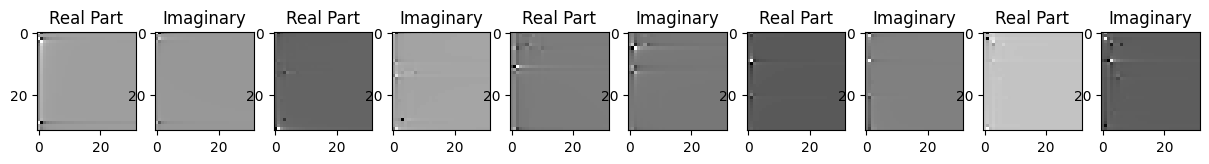

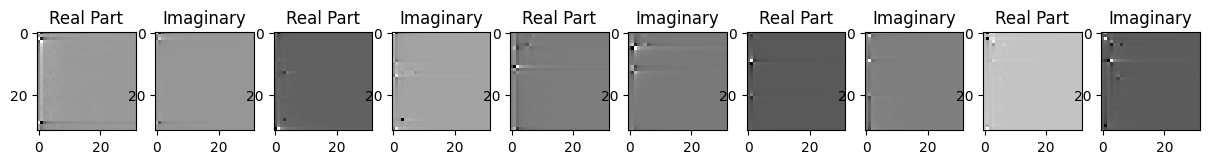

Epoch-151 lr: 0.00059049
Loss:  1.1336436500641867e-06
torch.Size([5, 2, 32, 32])


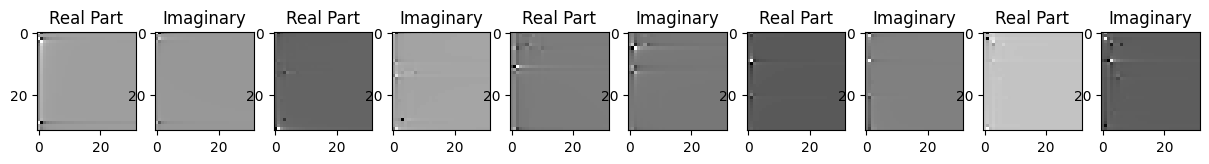

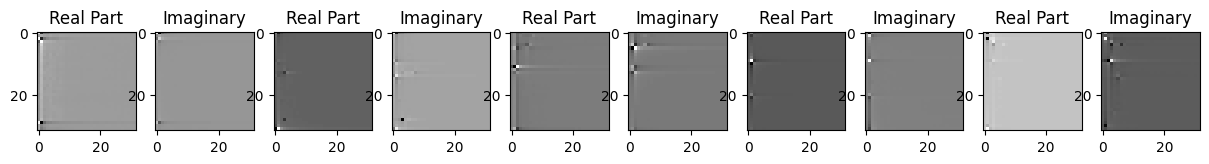

Epoch-152 lr: 0.00059049
Loss:  1.1481649835332064e-06
torch.Size([5, 2, 32, 32])


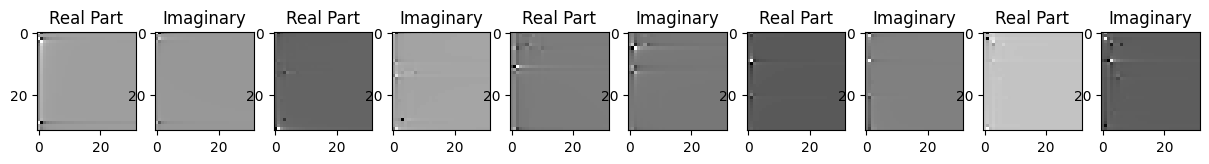

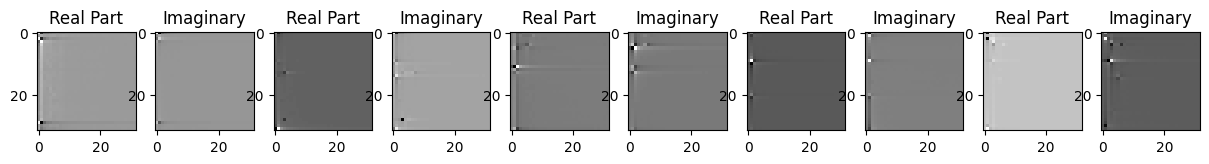

Epoch-153 lr: 0.00059049
Loss:  1.1053849675590754e-06
torch.Size([5, 2, 32, 32])


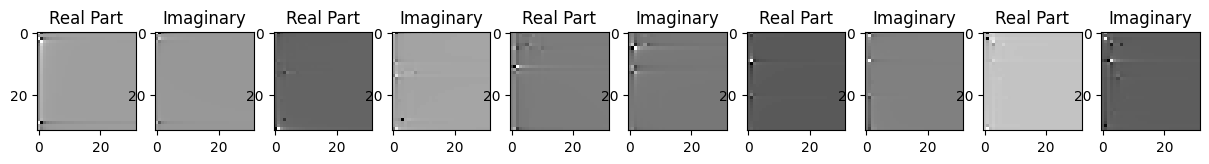

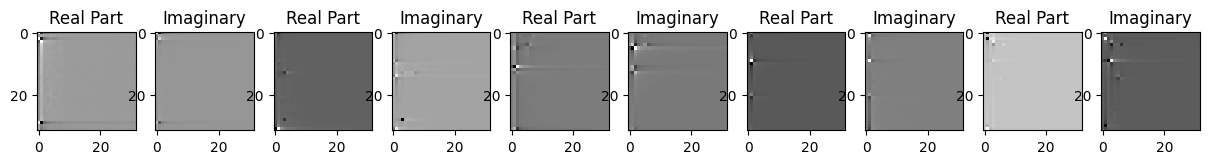

Epoch-154 lr: 0.00059049
Loss:  1.117590841204219e-06
torch.Size([5, 2, 32, 32])


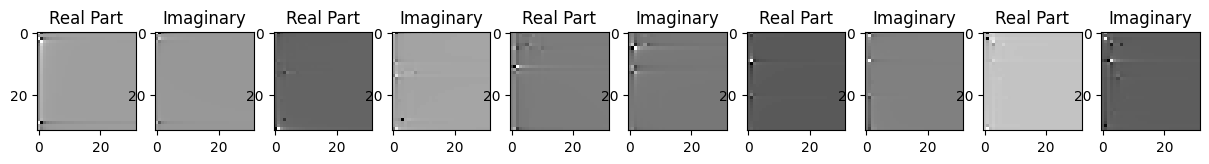

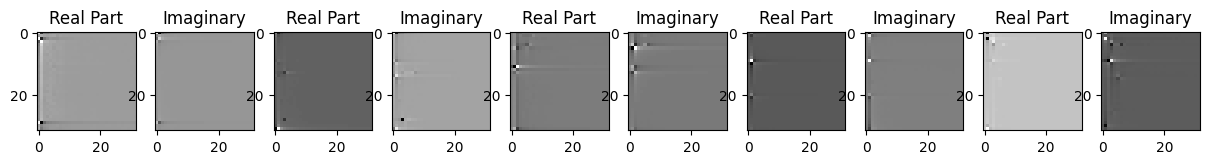

Epoch-155 lr: 0.00059049
Loss:  1.1166379181304364e-06
torch.Size([5, 2, 32, 32])


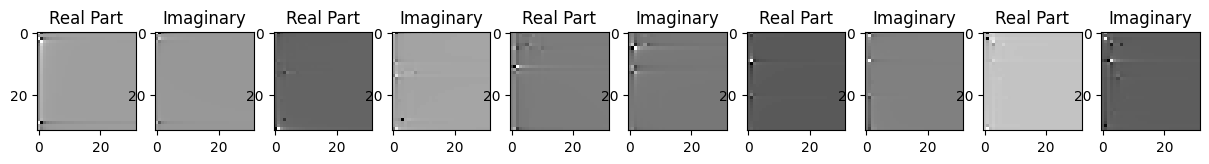

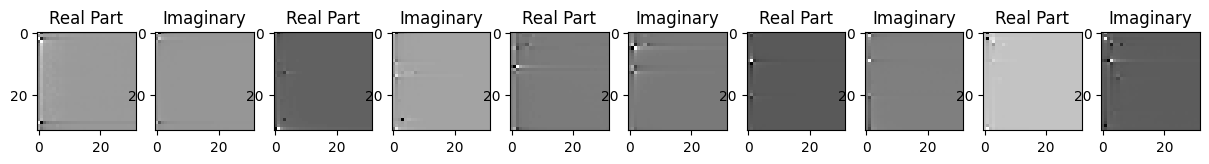

Epoch-156 lr: 0.00059049
Loss:  1.1184579307155218e-06
torch.Size([5, 2, 32, 32])


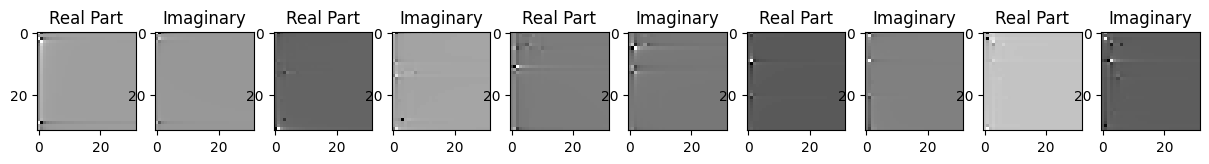

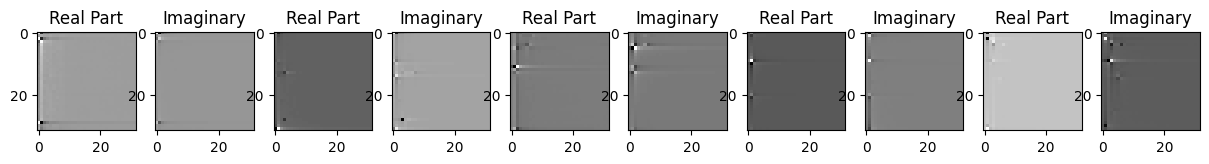

Epoch-157 lr: 0.00059049
Loss:  1.1219718771826592e-06
torch.Size([5, 2, 32, 32])


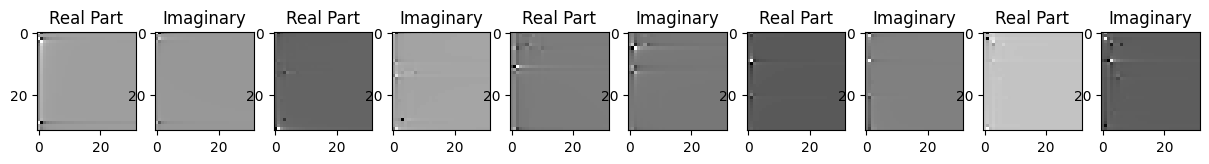

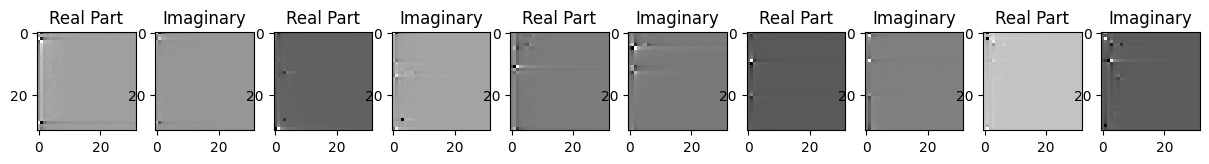

Epoch-158 lr: 0.00059049
Loss:  1.1181770105395117e-06
torch.Size([5, 2, 32, 32])


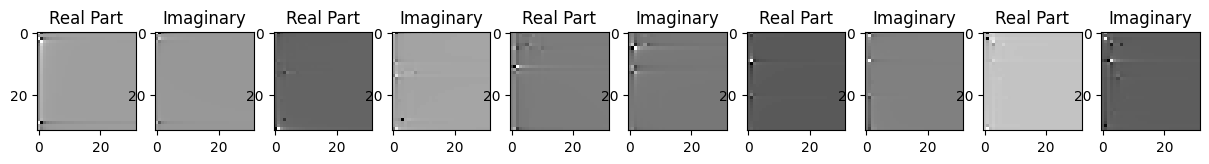

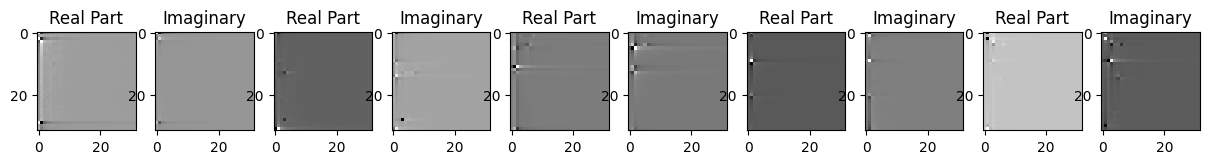

Epoch-159 lr: 0.00059049
Loss:  1.10248117834999e-06
torch.Size([5, 2, 32, 32])


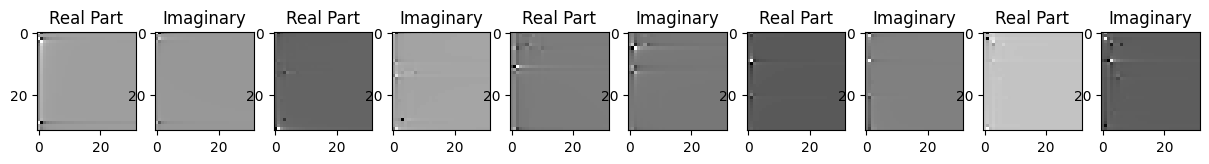

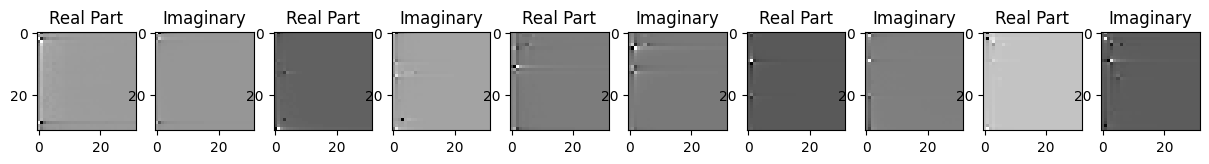

Epoch-160 lr: 0.00059049
Loss:  1.0916752444245503e-06
torch.Size([5, 2, 32, 32])


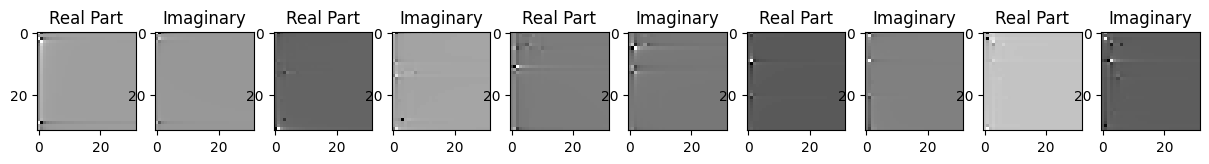

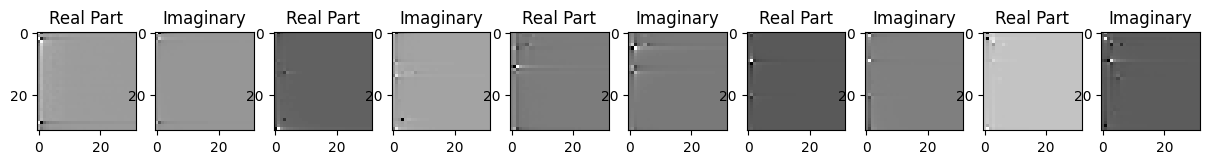

Epoch-161 lr: 0.00059049
Loss:  1.121061245612509e-06
torch.Size([5, 2, 32, 32])


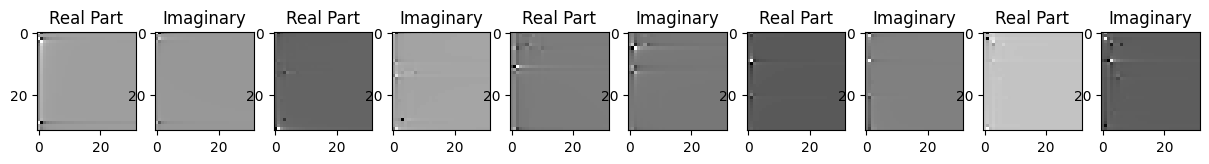

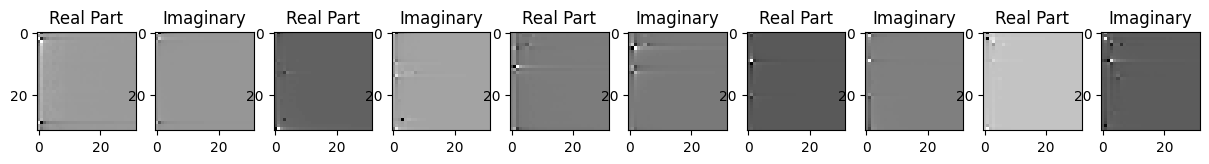

Saving model to: /content/drive/MyDrive/saved_model/_model_160_indoor_512.pth
Epoch-162 lr: 0.00059049
Loss:  1.0984126674884465e-06
torch.Size([5, 2, 32, 32])


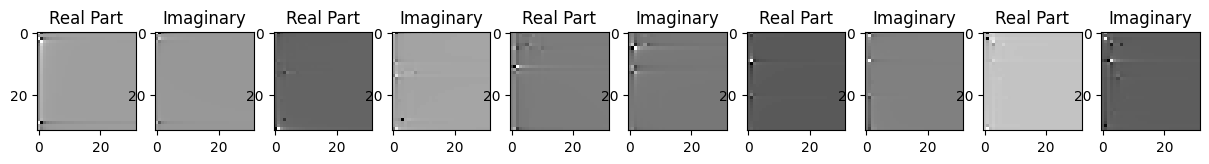

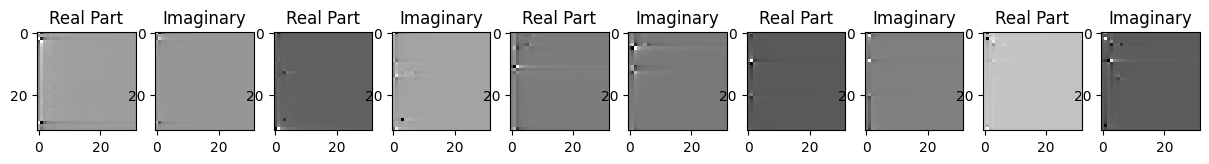

Epoch-163 lr: 0.00059049
Loss:  1.1212964636797551e-06
torch.Size([5, 2, 32, 32])


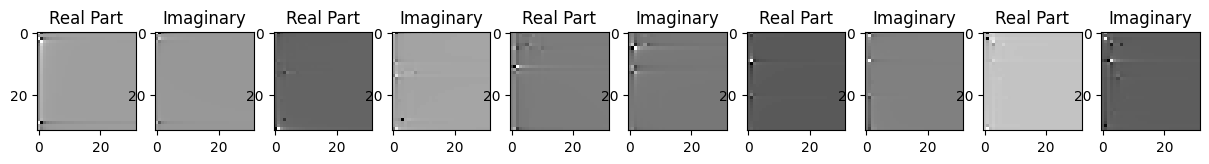

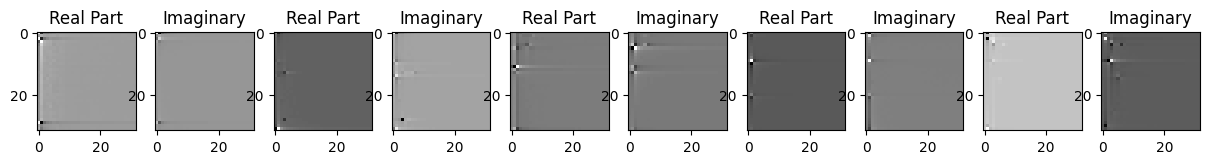

Epoch-164 lr: 0.00059049
Loss:  1.1201349252587534e-06
torch.Size([5, 2, 32, 32])


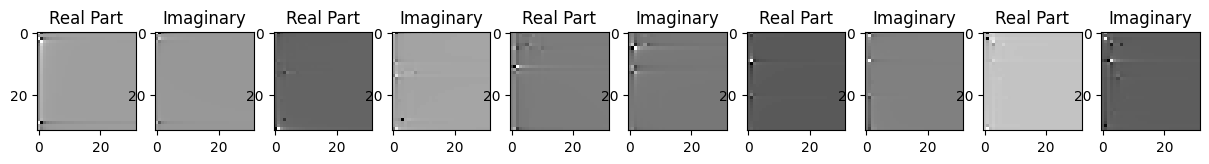

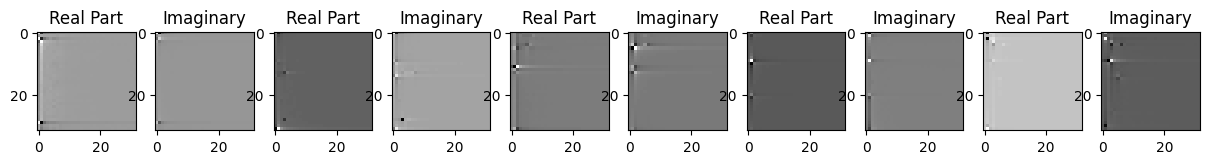

Epoch-165 lr: 0.00059049
Loss:  1.0986630059051095e-06
torch.Size([5, 2, 32, 32])


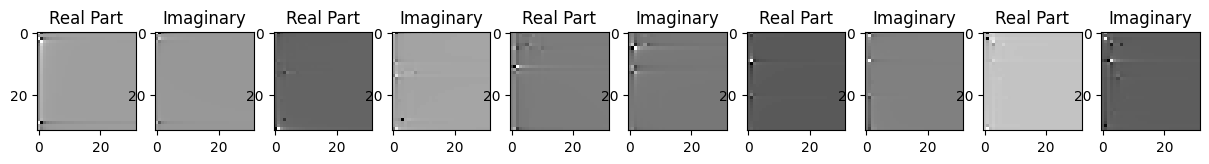

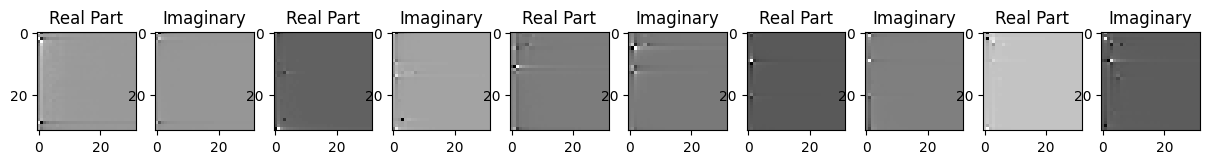

Epoch-166 lr: 0.00059049
Loss:  1.1168173159603612e-06
torch.Size([5, 2, 32, 32])


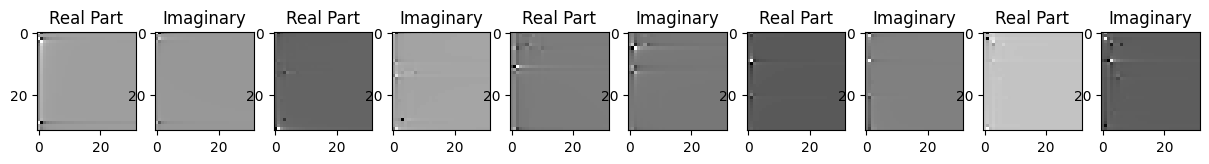

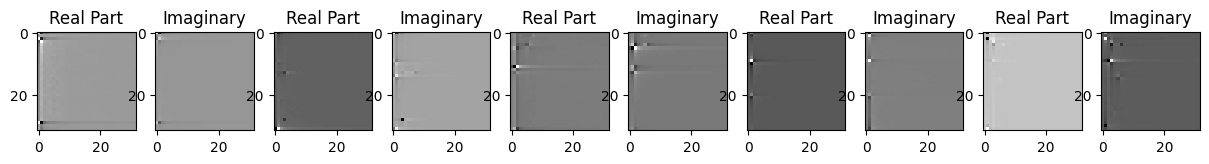

Epoch-167 lr: 0.00059049
Loss:  1.11809924874251e-06
torch.Size([5, 2, 32, 32])


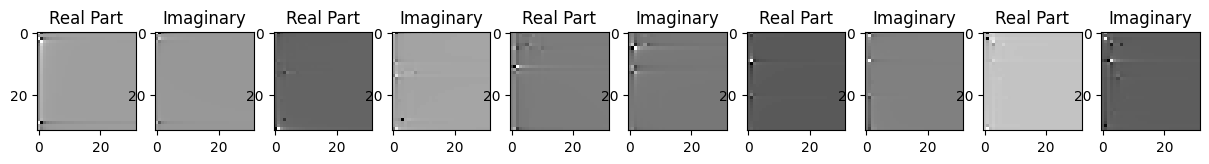

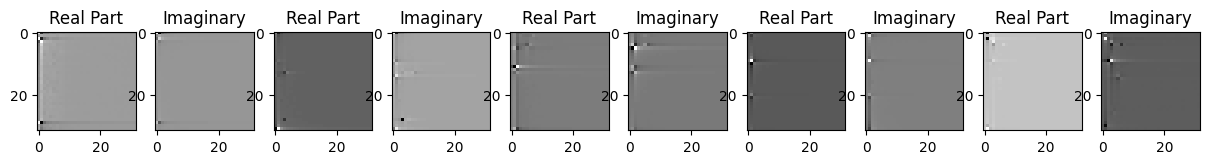

Epoch-168 lr: 0.00059049
Loss:  1.1146224778713076e-06
torch.Size([5, 2, 32, 32])


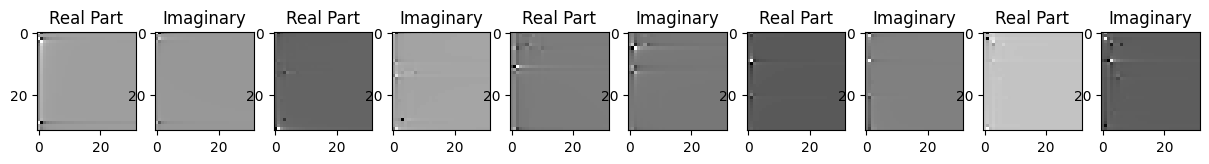

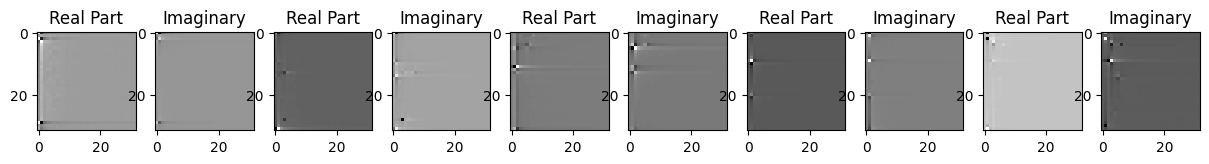

Epoch-169 lr: 0.00059049
Loss:  1.1363904377503786e-06
torch.Size([5, 2, 32, 32])


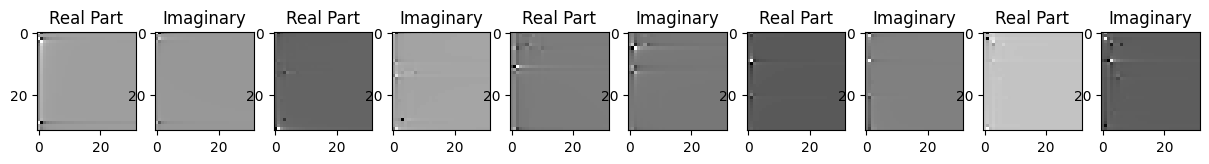

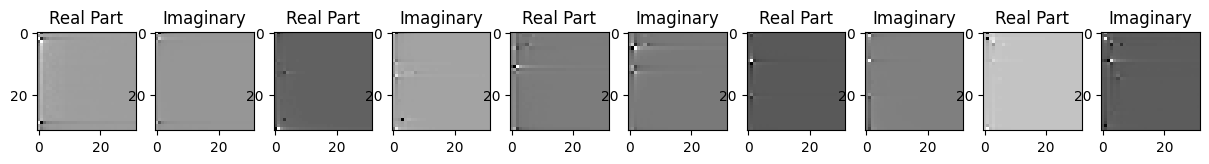

Epoch-170 lr: 0.00059049
Loss:  1.1369410231054644e-06
torch.Size([5, 2, 32, 32])


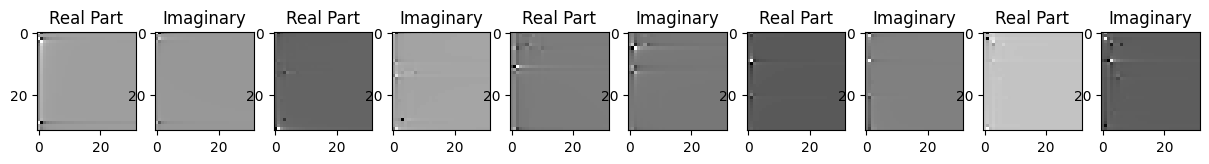

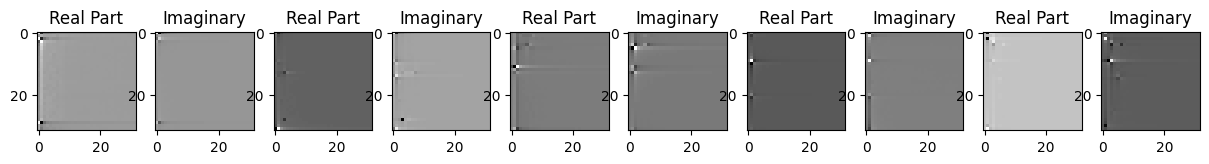

Epoch-171 lr: 0.00059049
Loss:  1.0961264251818648e-06
torch.Size([5, 2, 32, 32])


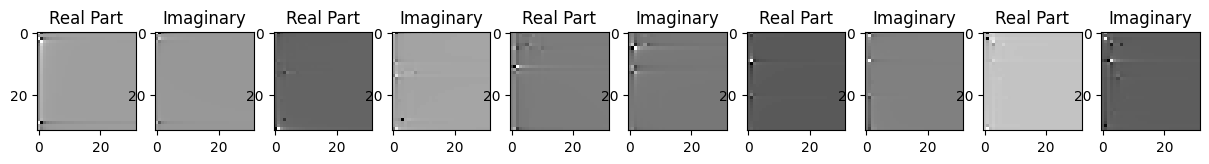

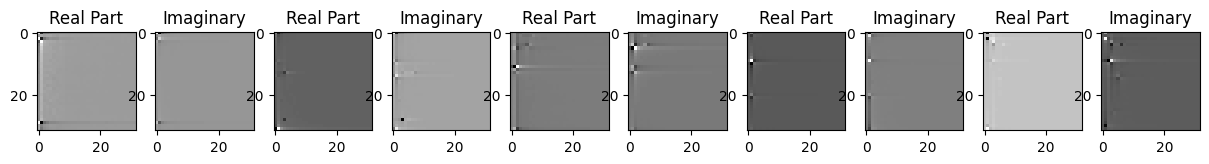

Epoch-172 lr: 0.00059049


In [ ]:
#epoch=550
with torch.autograd.set_detect_anomaly(True):
  for epoch in range(n_epochs):
      print('Epoch-{0} lr: {1}'.format(epoch+1, optimizer.param_groups[0]['lr']))
      for i in range(total_batches):
          x_batch = x_train[i*batch_size:(i+1)*batch_size,]
          #print(i*batch_size,(i+1)*batch_size)

          # criterion = nn.MSELoss()
          # model.to(device)
          # optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-07)
          # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)


          model.train()

          out = model(x_batch)

          loss = criterion(out, x_batch)
          train_loss_history.append(loss.item())
          loss.backward()

          optimizer.step()
          optimizer.zero_grad()

      scheduler.step()

      # Validating
      with torch.no_grad():
          model.eval()

          out = model(x_val_1)
          loss = criterion(out, x_val_1)
          print("Loss: ",loss.item())
          val_loss_history.append(loss.item())



      with torch.no_grad():
        input=x_val[0:5,:,:,:]
        print(input.shape)
        model.eval()
        out = model(input)
        CSI_img_ = out.cpu()


        fig, axs = plt.subplots(1, 10, figsize=(15,8))
        for j, l in it.zip_longest(range(0, 5), range(1, 10,2)):
          in_img=input[j,0,:,:].cpu()
          axs[j*2].imshow(np.array(in_img.squeeze(0)), cmap='gist_gray')
          axs[j*2].set_title('Real Part')
          in_img=input[j,1,:,:].cpu()
          axs[l].imshow(np.array(in_img.squeeze(0)), cmap='gist_gray')
          axs[l].set_title('Imaginary')

        fig, axs = plt.subplots(1, 10, figsize=(15,8))
        for i, x in it.zip_longest(range(0, 5), range(1, 10,2)):

          #print(i)
          #CSI_img = random.choice(CSI_img_.cpu())
          img=CSI_img_[i,0,:,:]
          axs[i*2].imshow(np.array(img.squeeze(0)), cmap='gist_gray')
          axs[i*2].set_title('Real Part')
          img=CSI_img_[i,1,:,:]
          axs[x].imshow(np.array(img.squeeze(0)), cmap='gist_gray')
          axs[x].set_title('Imaginary')

        plt.show()


        if epoch%20==0:
          MODEL_PATH = Path("/content/drive/MyDrive/saved_model")
          MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                          exist_ok=True # if models directory already exists, don't error
          )


          # Create model save path
          MODEL_NAME = "_model_{}_{}_{}.pth".format(epoch,envir,encoded_dim)
          MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

          # Save the model state dict
          print(f"Saving model to: {MODEL_SAVE_PATH}")
          torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),
                      'lr_state_dict': scheduler.state_dict()}, # only saving the state_dict() only saves the learned parameters
                      f=MODEL_SAVE_PATH)

      #if epoch%50==0:
      # with torch.no_grad():
      #   model.eval()
      #   x_hat = model(x_test)
      #   x_test = x_test.to(device)
      #   x_hat=x_hat.to(device)
      #   X_test = torch.reshape(X_test, (len(X_test), img_height, 125))
      #   x_test_real = torch.reshape(x_test[:, 0, :, :], (len(x_test), -1))
      #   x_test_imag = torch.reshape(x_test[:, 1, :, :], (len(x_test), -1))
      #   x_test_C = x_test_real - 0.5 + 1j * (x_test_imag - 0.5)
      #   x_hat_real = torch.reshape(x_hat[:, 0, :, :], (len(x_hat), -1))
      #   x_hat_imag = torch.reshape(x_hat[:, 1, :, :], (len(x_hat), -1))
      #   x_hat_C = x_hat_real - 0.5 + 1j * (x_hat_imag - 0.5)
      #   x_hat_F = torch.reshape(x_hat_C, (len(x_hat_C), img_height, img_width))
      #   X_hat = torch.fft.fft(torch.cat((x_hat_F, torch.zeros((len(x_hat_C), img_height, 257 - img_width)).to(device)), axis=2), axis=2)
      #   X_hat = X_hat[:, :, 0:125]

      #   n1 = torch.sqrt(torch.sum(torch.conj(X_test) * X_test, axis=1)).to(device)
      #   n2 = torch.sqrt(torch.sum(torch.conj(X_hat) * X_hat, axis=1)).to(device)
      #   aa = abs(torch.sum(torch.conj(X_test.to(device)) * X_hat, axis=1).to(device)).to(device)
      #   rho = torch.mean(aa / (n1 * n2), axis=1).to(device)
      #   X_hat = torch.reshape(X_hat, (len(X_hat), -1))
      #   X_test = torch.reshape(X_test, (len(X_test), -1))
      #   power = torch.sum(abs(x_test_C) ** 2, axis=1).to(device)
      #   power_d = torch.sum(abs(X_hat) ** 2, axis=1).to(device)
      #   mse = torch.sum(abs(x_test_C - x_hat_C) ** 2, axis=1).to(device)
      #   NMSE = 10 * math.log10(torch.mean(mse / power))
      #   Correlation = torch.mean(rho).item().real

      #   print("In " + envir + " environment")
      #   print("When dimension is", encoded_dim)
      #   print("NMSE is ", NMSE)
      #   print("Correlation is ", Correlation)






tEnd = time.time()
training_time = tEnd - tStart
print("It cost %f sec for training." % training_time)